In [1]:
from rdkit import Chem

from My_Pka_Model_Output_Atom_Features import Pka_basic,Pka_acidic
import torch

import dgl
import dgllife
from torch.utils.data import DataLoader
from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, CanonicalBondFeaturizer
import torch.optim as optim
import numpy as np
import random 
import pandas as pd

from torch.nn.utils import clip_grad_norm

Using backend: pytorch


In [2]:
seed = 0
random.seed(seed) 
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [3]:
def collate(samples):
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

node_featurizer = CanonicalAtomFeaturizer(atom_data_field='h')
edge_featurizer = CanonicalBondFeaturizer(bond_data_field='h')

def load_data(file_name,batch_size = 128,shuffle = True,split_ratio = False):
    dataset = []
    with open(file_name) as f:
        for line in f.readlines():
            line = line.replace('\n','').split('\t')
            g = smiles_to_bigraph(smiles=line[0], 
                          node_featurizer=node_featurizer,
                          edge_featurizer=edge_featurizer,
                          canonical_atom_order= False)
            dataset.append((g,float(line[1])))
            
    if split_ratio == False:
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,collate_fn=collate)
        return dataloader
    else:
        random.shuffle(dataset)
        length = len(dataset)
        dataloader_list = []
        for i in split_ratio:
            num = round(length * i)
            dataset_part = dataset[:num]
            dataset = dataset[num:]
            dataloader = DataLoader(dataset_part, batch_size=batch_size, shuffle=shuffle,collate_fn=collate)
            dataloader_list.append(dataloader)
        dataset_part = dataset
        dataloader = DataLoader(dataset_part, batch_size=batch_size, shuffle=shuffle,collate_fn=collate)
        dataloader_list.append(dataloader)
        return dataloader_list

In [4]:
batch_size = 1024
epoch_num = 1000
layer_num = 6
learning_rate = 0.0003
weight_decay = 0.0003

In [5]:
model = Pka_acidic(node_feat_size = 74,
                   edge_feat_size = 12,
                   output_size = 1,
                   num_layers= layer_num,
                   graph_feat_size=200,
                   dropout=0.2)

model.load_state_dict(torch.load('./Trained_model/site_acidic_new_2.pkl',map_location='cuda:3'))
model = model.to('cpu')

In [6]:
smiles_lis = []
with open('./Dataset/all_acidic_smiles.txt') as f:
    for line in f.readlines():
        line = line.replace('\n','').split('\t')
        smiles_lis.append(line[0])
        print(line)

['CC(=O)OO', '8.2']
['O=C(c1ccc(-c2nn[nH]n2)cc1)N1CCC(N2CCC(Oc3ccc(Cl)c(Cl)c3)CC2)CC1', '3.6']
['CCCC(=O)OO', '8.2']
['O=COO', '7.1']
['O=C(NS(=O)(=O)N1CCC(N2CCC(Oc3ccc(Cl)c(Cl)c3)CC2)CC1)c1ccccc1', '4.3']
['CCC(=O)OO', '8.2']
['N#Cc1c(O)nc(N)nc1-c1ccccc1', '6.52']
['Cn1ccc(O)nc1=O', '9.71']
['Oc1ncnc2ccccc12', '9.87']
['Cn1cc(Br)c(O)nc1=O', '7.84']
['CN(C)c1cc(O)ncn1', '10.49']
['Cc1cc(O)nc(C)n1', '9.82']
['Oc1cc2ccccc2nn1', '8.63']
['CSc1ncnc(O)c1C', '9.12']
['Oc1cncc2cccnc12', '8.35']
['CSc1cc(O)ncn1', '8.52']
['Cc1cc(O)ncn1', '9.1']
['Oc1cc2ccccc2cn1', '9.62']
['Cc1cncnc1O', '9.17']
['COc1cc(O)ncn1', '8.47']
['COc1cncnc1O', '8.64']
['Oc1ccncn1', '8.63']
['COc1nc(C)cc(O)n1', '8.5']
['OC(C(F)(F)C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)C(F)(F)F', '10.52']
['Oc1nccc2cccnc12', '12.04']
['Oc1nncc2ccccc12', '11.99']
['O[C@@H](C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)C(F)(F)F', '10.48']
['Oc1ccc2ccccc2n1', '11.76']
['Oc1ccccn1', '11.62']
['Oc1cccnn1', '10.5']
['O=Cc1ncccc1O', '6.95']
['O=C(Nc1ccc(N2CCOCC2)c(F)c

['COc1cccc(O)c(=O)c1', '7.24']
['CC(=O)Nc1ccc(S)cc1', '6.08']
['O=C(O)COc1ccc(Cl)cc1C1CCCCC1', '3.51']
['O=C(Nc1nnc(-c2ccc(F)cc2)o1)c1ccc(Cl)s1', '5.8']
['O=C1OC(C(O)CO)C(O)=C1OCCCOc1no[n+]([O-])c1-c1ccccc1', '3.44']
['C/C(=C\\Cl)C(=O)O', '4.03']
['Clc1ccc(CN(Cc2nn[nH]n2)c2ccccc2)cc1', '4.38']
['O=C(O)Cc1ccccc1Nc1c(Cl)cccc1I', '4.24']
['CC[C@]1(C)NC(=O)c2cc(S(=O)(=O)Nc3ccc(F)cc3F)ccc2NC1=O', '7.3']
['Cc1cccc2ccc(O)cc12', '9.42']
['CC(=O)/C=C(O)/C=C/c1ccc(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)cc1', '9.24']
['CNc1cc[n+](C)c(=O)[nH]1', '4.47']
['O=c1cccc[nH]1', '11.68']
['COc1cccc(O)c1O', '9.28']
['CC(=O)OCCCCc1ccc(S(N)(=O)=O)cc1', '10.48']
['O=S1(=O)Nc2cccc3cccc1c23', '6.2']
['O=C(Nc1cccc(Cl)c1)c1ccc(Cl)cc1O', '6.3']
['CCCCCCCCCOC(=O)c1ccc(OS(N)(=O)=O)cc1', '8.39']
['O=C(c1ccc(Cl)cc1NS(=O)(=O)c1cccc2nsnc12)N1CCCCC1', '5.47']
['O=C(c1ccc2n1CCC2C(=O)O)C1CCC1', '3.54']
['CCCCCCCCCCc1c(-c2ccccc2)[nH]n(-c2ccccc2)c1=O', '6.7']
['O=C1CC(c2ccccc2)CC(O)=C1Oc1ccccc1Cl', '3.7']
['C=C(F)C(=O)O'

['CCCP(=O)(O)O', '2.49000001']
['COc1ccc([Se]CC(=O)O)cc1', '3.960000038']
['O=C(O)C(O)C(=O)O', '2.420000076']
['CCSC(=S)SCC(=O)O', '2.910000086']
['CC(OC1CCCCC1C)C(=O)O', '3.650000095']
['O=C(O)CCC(F)(F)F', '4.159999847']
['CC(Cl)CC(=O)O', '4.0500001910000005']
['O=C(O)CCC(=O)CCC(=O)O', '4.21999979']
['OCC(O)CS', '9.510000229']
['Cc1ccccc1C(=O)NO', '8.729999542']
['CCCC(C)(C)C(=O)O', '4.96999979']
['CCOC(=O)CCC(=O)CCC(=O)O', '4.570000172']
['CC(SCC(=O)O)C(=O)O', '3.3800001139999996']
['O=C(O)C(O)CCl', '3.1199998860000004']
['O=C(O)CCC([N+](=O)[O-])([N+](=O)[O-])[N+](=O)[O-]', '3.640000105']
['O=C(O)CCc1ccccc1F', '4.599999905']
['O=C(O)C1(C(=O)O)CCC1', '3.160000086']
['O=C(O)CSc1ccc(Cl)cc1', '3.529999971']
['CC(SCC(=O)O)(SCC(=O)O)C(=O)O', '2.470000029']
['CCCOC(=S)S', '2.220000029']
['O=S(=O)(O)c1ccc(Br)cc1', '1.8899999859999999']
['C=CCCO', '15.5']
['N#Cc1ccccc1OCC(=O)O', '2.970000029']
['CCOC(=O)C=CC(=O)O', '3.400000095']
['NC(=O)CCCC(=O)O', '4.599999905']
['CC(Oc1ccc(Cl)cc1Cl)C(=O)O'

['NCC/C=C/C(=O)O', '3.8299999239999996']
['NCc1cc(O)c(F)cc1F', '7.699999808999999']
['NCc1ccc(CCOc2cccc(OS(=O)(=O)c3ccccc3)c2)cc1O', '8.300000191']
['NN(CC(=O)O)CC(=O)O', '2.400000095']
['NP(=O)(O)OCCCNCCCl', '2.299999952']
['NS(=O)(=O)c1ccc(/N=N/c2ccc(O)cc2)cc1', '8.229999542']
['N[C@H]1CCCC[C@@H]1C(=O)O', '3.589999914']
['N[C@H]1CC[C@H](C(=O)O)CC1', '4.389999866']
['N[C@H]1CC[C@@H](C(=O)O)CC1', '4.3800001139999996']
['Nc1ccc(O[C@@H]2O[C@H](C(=O)O)[C@@H](O)[C@H](O)[C@H]2O)cc1', '3.099999905']
['Nc1ccc(S(=O)(=O)c2cc(O)ccc2O)cc1', '8.399999618999999']
['Nc1ccc([As](=O)(O)O)cc1[N+](=O)[O-]', '3.5199999810000002']
['Nc1ccc2c(c1)C(O)(OO)N=NC2=O', '10.10000038']
['Nc1ccc2cc3cc(C(=O)O)ccc3nc2c1', '2.299999952']
['Nc1cccc(O[C@@H]2O[C@H](C(=O)O)[C@@H](O)[C@H](O)[C@H]2O)c1', '2.970000029']
['Nc1cccc2c1C(O)(OO)N=NC2=O', '10.39999962']
['Nc1cncnc1NCC(=O)O', '2.900000095']
['Nc1n[nH]c(N)c1/N=N/c1ccc(C(=O)O)cc1', '3.400000095']
['Nc1ncncc1NCC(=O)O', '3.0199999810000002']
['Nc1nonc1C(=O)O', '3.19000

In [7]:
atom_feature_lis = []

In [8]:
counter = 0
for smiles in smiles_lis:
    bg = smiles_to_bigraph(smiles= smiles, 
              node_featurizer=node_featurizer,
              edge_featurizer=edge_featurizer,
              canonical_atom_order= False)

    with torch.no_grad():
        model.eval()
        g_feats,atom_pka,node_feats = model(bg,bg.ndata['h'], bg.edata['h'])
        atom_feature_lis.append(node_feats)
        
    print(smiles)

CC(=O)OO
O=C(c1ccc(-c2nn[nH]n2)cc1)N1CCC(N2CCC(Oc3ccc(Cl)c(Cl)c3)CC2)CC1
CCCC(=O)OO
O=COO
O=C(NS(=O)(=O)N1CCC(N2CCC(Oc3ccc(Cl)c(Cl)c3)CC2)CC1)c1ccccc1
CCC(=O)OO
N#Cc1c(O)nc(N)nc1-c1ccccc1
Cn1ccc(O)nc1=O
Oc1ncnc2ccccc12
Cn1cc(Br)c(O)nc1=O
CN(C)c1cc(O)ncn1
Cc1cc(O)nc(C)n1
Oc1cc2ccccc2nn1
CSc1ncnc(O)c1C
Oc1cncc2cccnc12
CSc1cc(O)ncn1
Cc1cc(O)ncn1
Oc1cc2ccccc2cn1
Cc1cncnc1O
COc1cc(O)ncn1
COc1cncnc1O
Oc1ccncn1
COc1nc(C)cc(O)n1
OC(C(F)(F)C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)C(F)(F)F
Oc1nccc2cccnc12
Oc1nncc2ccccc12
O[C@@H](C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)C(F)(F)F
Oc1ccc2ccccc2n1
Oc1ccccn1
Oc1cccnn1
O=Cc1ncccc1O
O=C(Nc1ccc(N2CCOCC2)c(F)c1)c1nnc(Nc2ccccc2F)o1
Oc1cncc2ccccc12
O=Cc1ccncc1O
CN(C)c1ccccc1S(=O)(=O)NC(=O)N1CCC(N2CCC(Oc3ccc(Cl)c(Cl)c3)CC2)CC1
CCOc1ccnc(O)n1
Oc1ncc2ccccc2n1
Oc1ccnc2ccccc12
OC(C(F)(F)F)C(F)(F)F
Oc1ccnc2cccnc12
CN(C)c1ccc(S(=O)(=O)NC(=O)N2CCC(N3CCC(Oc4ccc(Cl)c(Cl)c4)CC3)CC2)cc1
Nc1ccccc1S
Oc1cccnc1
CCCc1c(C)nc(O)nc1C
Cc1nc(O)nc(C)c1C
Cc1nc2ccccc2nc1O
Cc1cc(C)nc(O)n1
Nc1cnccc1O
C=C

CCc1ccc(O)c2sc(C)c(C)c12
C[n+]1cc(O)cc2ccccc21
OCCCS
Oc1ccc2ccccc2c1/N=N/c1nccs1
COc1ccccc1-c1ccccc1O
CC(C)Cc1ccc([C@@H](C)C(=O)NS(C)(=O)=O)cc1
O=C(O)c1c(O)cccc1O
O=C1c2ccccc2C(=O)c2cc(S(=O)(=O)O)ccc21
CC(C)(O)C(F)(F)F
COc1ccc2c(c1)C(=O)N(CCc1ccc(S(=O)(=O)NC(=O)NC3CCCCC3)cc1)C(=O)C2(C)C
CC(=O)NCCS
O=[N+]([O-])c1cc(Br)c(O)c(Br)c1
CC(C)[P@@H](=O)O
CCC[P@@H](=O)O
O=C(O)C(c1ccccc1)(c1ccccc1)c1ccccc1
CC[C@@](CC(=O)OC)(Cc1ccc([N+](=O)[O-])cc1)C(=O)O
COc1ccc(NS(=O)(=O)c2ccccc2)cc1
CO[C@@]1(NC(=O)CSCC#N)C(=O)N2C(C(=O)O)=C(CSc3nnnn3C)CS[C@@H]21
CC(=O)C[C@H](c1ccccc1)c1c(O)c2ccccc2oc1=O
Cc1ccccc1/N=N/c1ccc(O)c(C(=O)O)c1
O=[N+]([O-])c1cccc(S)c1
COC(=O)c1cccc(C)c1S(=O)(=O)NC(=O)Nc1nc(OCC(F)(F)F)nc(N(C)C)n1
O=C(O)CCCC[C@@H]1CCSS1
CC(C)c1ccccc1C(=O)O
CC(C)(S)CO
O=C(O)c1c(Cl)cccc1CO
CCOc1nc(NC)nc(NC(=O)NS(=O)(=O)c2ccccc2C(=O)OC)n1
O=C(O)C(CO)(CO)CO
Oc1ccccc1Cc1ccccc1O
CCCC[P@@H](=O)O
CCCCCC(=O)NO
O=C(O)COCCN1CCN([C@H](c2ccccc2)c2ccc(Cl)cc2)CC1
O=C(c1ccccc1)N(O)c1ccccc1
O=CNO
CCOC(=O)N1CCC(c2cc(=O)n(-

O=C(O)CCCCCCc1ccccc1
Cc1ccc(C)c(O)c1
O=C(O)c1ccc(C2CCCC2)cc1
C[C@@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23
O=C(O)CC(=O)C(Cl)Cl
C[C@H](C(=O)O)c1cccc(C(=O)c2ccccc2)c1
O=C(O)C(Br)Br
O=C(O)c1cc([N+](=O)[O-])ccc1O
CC1=C(CC(=O)O)c2cc(F)ccc2/C1=C\c1ccc([S@](C)=O)cc1
Cc1cc(Cl)ccc1O
Cc1cccc(O)c1
CCCOc1cccc(C(=O)O)c1
Cc1cc2ccccc2c(C(=O)O)c1C
Oc1cc(Cl)cc(Cl)c1
C[N+](C)(C)c1cccc(CC(=O)O)c1
COc1ccc2cc([C@H](C)C(=O)O)ccc2c1
COc1nc(C)nc(NC(=O)NS(=O)(=O)c2ccccc2OCCCl)n1
Oc1cccc(F)c1
Cc1ccc(C(=O)c2ccccc2C(=O)O)cc1
COC(=O)c1cc(O)c2ccccc2c1
COc1ccc(C(=O)NO)cc1
CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccccc3)C(=O)N2[C@H]1C(=O)O
O=C(O)Cc1c(Cl)ccc(Cl)c1Cl
C[C@H](Oc1ccc(Cl)cc1Cl)C(=O)O
Cc1cc(Br)ccc1C(=O)O
COc1ccc([P@@H](=O)O)cc1
Cc1cc(Cl)ccc1OCC(=O)O
CCCc1nc(C(C)(C)O)c(C(=O)OCc2oc(=O)oc2C)n1Cc1ccc(-c2ccccc2-c2nnn[nH]2)cc1
C=CC[C@@H](C)C(=O)O
Cc1ccc([N+](=O)[O-])c(O)c1
COC(=O)C[C@@H](C(=O)O)c1ccccc1
CCOCC(=O)O
CCc1cccc2c3c([nH]c12)[C@](CC)(CC(=O)O)OCC3
O=C(O)/C=C/c1ccccc1Br
CCc1cc2c(O)ccc(CC)c2s1
CC(C)c1cc

CO[C@H]1/C=C/O[C@@]2(C)Oc3c(C)c(O)c4c(O)c(c(/C=N/N5CCN(C)CC5)c(O)c4c3C2=O)NC(=O)/C(C)=C\C=C\[C@H](C)[C@H](O)[C@@H](C)[C@@H](O)[C@@H](C)[C@H](OC(C)=O)[C@@H]1C
N=C(N)NS(=O)(=O)c1ccc(N)cc1
Cc1ncc(CO)c(CO)c1O
CC(CCc1ccccc1)NCC(O)c1ccc(O)c(C(N)=O)c1
C[C@@H]1OC(=O)CC(O)CC(O)CC(O)CCC(O)C(O)C[C@]2(O)CC(O)C(C(=O)O)C(CC(O[C@H]3O[C@H](C)[C@@H](O)[C@H](N)[C@@H]3O)/C=C/C=C/C=C/C=C/CC/C=C/C=C/[C@H](C)[C@@H](O)[C@H]1C)O2
O=S(Cc1ccccn1)c1nc2ccccc2[nH]1
O=C(CCCCC(=O)Nc1c(I)cc(I)c(C(=O)O)c1I)Nc1c(I)cc(I)c(C(=O)O)c1I
C[C@H]1[C@H](NC(=O)/C(=N\OC(C)(C)C(=O)O)c2csc(N)n2)C(=O)N1S(=O)(=O)O
Nc1nc(=S)c2[nH]cnc2[nH]1
CC(C)NCC(O)c1cc(O)cc(O)c1
Nc1ccc(S(=O)(=O)Nc2nccs2)cc1
Cn1c(=O)c2[nH]c(Cl)nc2n(C)c1=O
S=c1nc[nH]c2nc[nH]c12
CC(=O)Nc1c(I)c(NC(C)=O)c(I)c(C(=O)O)c1I
CCOC(=O)C(c1c(O)c2ccccc2oc1=O)c1c(O)c2ccccc2oc1=O
NC(=O)c1ccccc1O
COc1ccc(-c2nc(C(F)(F)F)[nH]c2-c2ccc(OC)cc2)cc1
CC1(C)[C@@H](OC(=O)CCC(=O)O)CC[C@@]2(C)[C@H]1CC[C@]1(C)[C@@H]2C(=O)C=C2[C@@H]3C[C@@](C)(C(=O)O)CC[C@]3(C)CC[C@]21C
O=C1OC(c2ccc(O)cc2)(c2ccc(

Oc1ccc2c3c1O[C@H]1[C@@H](O)CC[C@@]4(O)[C@@H](C2)N(CC2CCC2)CC[C@]314
CC1(C)S[C@@H]2[C@H](NC(=O)C(C(=O)O)c3ccccc3)C(=O)N2[C@H]1C(=O)O
CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C3C(=O)c4c(O)cccc4[C@@](C)(O)[C@H]3[C@H](O)[C@@H]12
Cn1nnnc1SCC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)[C@H](O)c3ccccc3)[C@H]2SC1
CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](NC(=O)N3CCN(S(C)(=O)=O)C3=O)c3ccccc3)C(=O)N2[C@H]1C(=O)O
Cc1onc(-c2ccccc2)c1C(=O)N[C@@H]1C(=O)N2[C@@H](C(=O)O)C(C)(C)S[C@H]12
CCOc1ccc2ccccc2c1C(=O)N[C@@H]1C(=O)N2[C@@H](C(=O)O)C(C)(C)S[C@H]12
CC(=O)Nc1nnc(S(N)(=O)=O)s1
C[C@H]1c2cccc(O)c2C(=O)C2=C(O)[C@]3(O)C(=O)C(C(N)=O)=C(O)[C@@H](N(C)C)[C@@H]3[C@@H](O)[C@@H]21
CC(=O)Nc1ccc(C(=O)Nn2cnnc2)cc1
Nc1nonc1/C(=N/O)Nc1ccccc1
O=C(NC1=CON=CC=C1)c1cccc(O)c1
COCCNCCn1cnc2c1c(=O)[nH]c(=O)n2C
Nc1ccc(O)c(-c2nc3cc(Cl)ccc3o2)c1
CCOC(=O)c1sc(NC(=S)NC(=O)c2ccccc2)nc1C
O=[N+]([O-])c1ccccc1S(=O)(=O)Nc1ccc(Cl)cc1
ON=Cc1c(O)c(Br)cc2oc3c(c12)CCCC3
COc1cccc(C2Nc3ccccc3C(=O)N2O)c1
NS(=O)(=O)c1ncccc1I
CCS(=O)(=O)c1ncccc1S(N)(=O)=O
COc1c

SC1CC1c1ccccc1
Nc1cccc(S)c1
Nc1ccc(S)cc1
CN(C)c1ccccc1S
CN(C)c1cccc(S)c1
CN(C)c1ccc(S)cc1
COc1ccccc1S
Oc1ccccc1S
Oc1cccc(S)c1
Oc1ccc(S)cc1
CC(C)(C)c1ccccc1S
CC(C)(C)c1cccc(S)c1
CC(C)(C)c1ccc(S)cc1
O=Cc1ccccc1S
O=Cc1cccc(S)c1
O=Cc1ccc(S)cc1
COC(=O)c1ccccc1S
COC(=O)c1cccc(S)c1
COC(=O)c1ccc(S)cc1
O=[N+]([O-])c1ccccc1S
N#Cc1ccccc1S
N#Cc1cccc(S)c1
N#Cc1ccc(S)cc1
Sc1ccco1
Sc1ccoc1
Sc1cccs1
Sc1ccsc1
Sc1ccc[nH]1
Sc1cc[nH]c1
Sc1ccno1
Sc1cnoc1
Sc1ccon1
O=Cc1ccoc1S
O=Cc1coc(S)c1
O=Cc1ccc(S)o1
N#Cc1ccoc1S
N#Cc1coc(S)c1
N#Cc1ccc(S)o1
O=[N+]([O-])c1ccoc1S
O=[N+]([O-])c1coc(S)c1
O=[N+]([O-])c1ccc(S)o1
Nc1ccoc1S
Nc1coc(S)c1
Nc1ccc(S)o1
Oc1ccoc1S
Oc1coc(S)c1
Oc1ccc(S)o1
COc1ccoc1S
COc1coc(S)c1
COc1ccc(S)o1
Sc1occc1-c1ccccc1
Sc1cc(-c2ccccc2)co1
Sc1ccc(-c2ccccc2)o1
O=Cc1occc1S
O=Cc1cocc1S
O=Cc1cc(S)co1
N#Cc1occc1S
N#Cc1cocc1S
N#Cc1cc(S)co1
O=[N+]([O-])c1occc1S
O=[N+]([O-])c1cocc1S
O=[N+]([O-])c1cc(S)co1
Nc1occc1S
Nc1cocc1S
Nc1cc(S)co1
Oc1occc1S
Oc1cocc1S
Oc1cc(S)co1
COc1occc1S
COc1cocc1S
COc1cc(S)co1
Sc1

CCOC(=O)C(Cc1cccc(C)c1)=C(C)O
CCOC(=O)C(Cc1ccccc1)=C(C)O
CCOP(=O)(OCC)c1ccc(-c2cc(=O)o[nH]2)o1
O=S(=O)(Cc1ccccc1)c1ncn[nH]1
CC(=O)C1=C(O)CCCC1
O=c1cc(O)n2ncc(-c3ccccc3)c2[nH]1
COc1ccccc1Oc1c(NS(=O)(=O)c2ccc(C(C)(C)C)cc2)nc(-c2ncccn2)nc1OCCO
O=c1cc(O)n2ncc(-c3ccc(Br)cc3)c2[nH]1
CC(=O)C1=C(O)c2ccccc2C1=O
O=c1cc(O)n2nccc2[nH]1
O=c1c(O)c1-c1ccccc1
Cn1cnc2[nH]c(=O)[nH]c(=S)c21
O=c1c(O)c1-c1ccc(F)cc1
S=c1nc(CCc2ccccc2)[nH]o1
Cn1nc(Cl)nc1NN=O
Cn1ncnc1NN=O
CC(C)(C)c1ccc(-c2c(O)c2=O)cc1
Cc1nc(-c2ccccc2)oc1O
Cc1[nH]nc2c1c(=O)n(C)c(=O)n2C
COc1ccc(-c2c(O)c2=O)cc1
Cn1c(=O)n(NS(C)(=O)=O)c(=O)c2ccc(Cl)cc21
CC1(C)O[C@@H]2CO[C@@]3(CNS(N)(=O)=O)OC(C)(C)O[C@H]3[C@@H]2O1
N#CNS(=O)(=O)c1ccc(N)cc1
O=c1cc(-c2ccccc2)[nH][nH]1
Cc1[nH]n(-c2ccccc2)c(=O)c1C
S=CNc1ccccc1Cl
CC(=O)c1cc(C)c(C)cc1O
Oc1oc(-c2ccccc2)nc1Cc1ccccc1
CC(=O)C(C)=C(O)C(C)C
CONC(=O)CCc1ccccc1
S=C1NC(=S)C(c2ccccc2)N1
COc1ccc(Cn2cc(-c3nn[nH]n3)c(=O)c3c(F)ccc(F)c32)cc1
S=c1[nH]c(=S)c2[nH]cnc2[nH]1
Cc1[nH][nH]c(=O)c1-c1ccccc1
CC(=O)NBr
COc1ccc(Cn2c

O=c1cc(-c2ccccc2)oc2cc(O)c(O)cc12
CCCCCCCc1c(-c2ccccc2)[nH]n(-c2ccccc2)c1=O
CC(C)N=C1Nc2c(Cl)cccc2S(=O)(=O)N1
O=C1NC(c2ccccc2)CC(O)=C1Sc1ccccc1Cl
COc1ccc(/C=C2/SC(=S)NC2=O)cc1
N#Cc1csc(NC(=O)Nc2ccc(Cl)c(Cl)c2)n1
CC(=O)NCc1cc(C)cc(CNC(C)=O)c1O
CN1C(=O)C(C)(C)NC1=S
CC(C)(C)c1ccc(S(=O)(=O)Nc2ccc(Cl)cc2C(=O)c2cc[n+]([O-])cc2)cc1
O=C1NC(=O)c2ccccc21
CS(=O)(=O)Nn1c(=O)[nH]c2cc(C(F)(F)F)ccc2c1=O
CC(C)(C(N)=O)S(=O)(=O)NC(N)=O
CN(n1c(=O)[nH]c2cc(Cl)ccc2c1=O)S(C)(=O)=O
COc1ccccc1-c1cn[nH]n1
Cc1ccc(=O)c(O)c(Br)c1
CCc1oc2ccccc2c1C(=O)Cc1cc(Br)c(O)c(Br)c1
O=c1cc(-c2ccc(O)cc2)ss1
CC(=O)C(=C(C)O)c1ccccc1
O=c1cc(-c2ccc(O)cc2)oc2ccccc12
CCCC12CCC(=O)C=C1c1c(cc(SCC(=O)O)c(Cl)c1Cl)C2
O=C(O)CN1C(=O)c2cccc3cccc(c23)C1=O
O=c1[nH]c(-c2ccc(C(F)(F)F)cc2)nc2c1CCOC2
C[n+]1ccc2cc(O)ccc2c1
S=C1NCCO1
CCCC(=O)c1cc(C(C)=O)n[nH]1
C[n+]1cccc2c(O)cccc21
CC(C)NC(=S)S
CCS(=O)(=O)c1ccc(CC(=O)Nc2nc(-c3ccccc3)c(C(=O)c3ccccc3)s2)cc1
CCN(CC)C(=O)NO
CC/C(C)=C\C(=O)O
Cc1c(-c2ccccc2)[nH]n(-c2ccccc2)c1=O
NC(=O)CS(=O)(=O)NC(N)=O
CO

O=C(C=C(O)c1cccs1)C(F)(F)F
Fc1cccc(-c2cn[nH]n2)c1
Clc1ccc(-c2cn[nH]n2)cc1
O=C(O)c1ccnc2ccccc12
Oc1ccc(/N=N/c2nc3ccccc3s2)c2cccnc12
O=S(=O)(Nc1cncc(Br)c1)c1ccccc1C(F)(F)F
OC[C@H]1O[C@H](Oc2ccc(-c3cc(F)c(O)c(F)c3)cc2)[C@@H](O)[C@@H](O)[C@@H]1O
Cc1c(-c2ccc(=O)n(Cc3ccccc3)n2)c2cc(F)ccc2n1CC(=O)O
Cc1ccnc(NS(=O)(=O)c2ccc(Cl)cc2)n1
O=C(CCc1ccccc1)NO
Cc1cn(C2CC(N=[N+]=[N-])C(COP(=O)(NC(C)C)OCCSC(=O)C(C)(C)C)O2)c(=O)[nH]c1=O
O=C(c1ccccc1)c1ccn[nH]1
O=C(O)C12CC3(F)CC(F)(CC(F)(C3)C1)C2
O=C(O)c1ccnnc1
Cc1[nH]c2ccccc2c1C(=O)O
O=C(O)COc1cc2c(c(Cl)c1Cl)C(=O)C(CC1CCCC1)C2
Cc1c(-c2ccc(=O)n(Cc3ccccc3)n2)c2cc(S(C)(=O)=O)ccc2n1CC(=O)O
O=C(O)[C@H]1C[C@H]2CC[C@@H]1C2
O=C1C=C(O)C(Cc2ccccc2)C1
CC1(Cc2ccccc2)Cc2cc(OCC(=O)O)c(Cl)c(Cl)c2C1=O
Cn1cnc2[nH]c(=O)[nH]c(=O)c21
O=C(NO)Nc1ccccc1
N#Cc1ccc(S(=O)(=O)Nc2ccc3cc[nH]c(=O)c3c2)cc1
O=c1ccc2cc(O)c(O)cc2o1
Clc1cccc(-c2cn[nH]n2)c1
O=C(O)Cc1ccco1
Cc1c(-c2ccccc2)c(=O)oc2cc(O)ccc12
Cc1c(-c2ccc(=O)n(Cc3ccccc3)n2)c2cccc(Br)c2n1CC(=O)O
O=c1cc(O)c2ccccc2o1
CCCCCc1c(-c2cccc

COc1nc(C)cc(=O)[nH]1
COc1cccc2c1c(NS(=O)(=O)c1cccc(Cl)c1Cl)nn2Cc1cccc(CNC(=O)C(C)(C)O)c1
CCCc1c(-c2ccccc2)[nH]n(-c2ccccc2)c1=O
O=C(O)CCCN1C(=O)S/C(=C\C=C\c2ccccc2)C1=O
O=C(O)C1CC1(Br)Br
N#Cc1c(-c2ccc(Cl)cc2)nc(SCC(=O)Nc2ccc(Cl)cc2)[nH]c1=O
COc1ccc([C@H]2C[C@@H]2C(=O)O)cc1
Nc1ccccc1C(=O)O
O=C(O)C12CC3CC(CC(F)(C3)C1)C2
C[C@H]1CC[C@H](C)C1C(=O)O
N#Cc1ccc(NS(=O)(=O)c2ccccc2C(F)(F)F)cc1Cl
O=C1CCCC(=O)N1O
O=C1CC(c2ccccc2)NC(=O)N1
O=C(Cc1cccc2ccccc12)N[C@H](Cc1cc2ccc(F)cc2[nH]1)C(=O)O
N#Cc1ccc(-c2nn[nH]n2)cc1
CCO[C@H]1C[C@H]1C(=O)O
COc1ccccc1/C=C\C(=O)O
O=C(O)c1nsc2ccccc12
NS(=O)(=O)c1cccc(C(F)(F)F)c1
N#Cc1cccc(S(N)(=O)=O)c1
COc1c(O)ccc2c1C[N+]1(C)CCc3cc4c(cc3[C@@H]1C2)OCO4
CCC(=O)c1cc(C(=O)C(C)(C)C)n[nH]1
Oc1cccc2cc3ccccc3cc12
O=C(O)c1ccccc1Cl
CCC1=C(O)C(CC)C1=O
C[C@](Cc1c[nH]c2ccccc12)(NC(=O)OC1C2CC3CC(C2)CC1C3)C(=O)NC[C@@H](NC(=O)CCC(=O)O)c1ccccc1
C[C@@](Cc1c[nH]c2ccccc12)(NC(=O)OC1C2CC3CC(C2)CC1C3)C(=O)NC[C@H](NC(=O)CCC(=O)O)c1ccccc1
O=C(O)C[C@@H]1c2ccccc2C[C@H]1NC(=O)c1cc2cc(F)ccc2[nH]1


O=C(O)c1ccoc1
O=C1OC2C3CC4C2C4(C(=O)O)C13Br
O=C(c1ccc2ccccc2c1)c1ccc2n1CCC2C(=O)O
COC(=O)/C=C/C(=O)O
Cc1ccccc1C(=O)c1ccc2n1CCC2C(=O)O
CC#CCC(=O)O
Cc1ncsc1C(=O)O
O=C(O)[C@@]1(Cl)[C@H]2CCC[C@H]21
O=C(c1cccc(Cl)c1)c1ccc2n1CCC2C(=O)O
Brc1nn[nH]n1
O=C(O)CCc1nc(-c2ccccc2)c(-c2ccccc2)o1
Oc1ccc2c(c1)Cc1ccccc1-2
COc1ccc2cc3[n+](cc2c1O)CCc1cc2c(cc1-3)OCO2
CC([P])C(=O)O
COc1cccc2c1c(NS(=O)(=O)c1ccc(Cl)s1)nn2Cc1cccc(CNC(C)=O)c1
O=Nc1c(O)ccc2ccccc12
CC(=O)c1ccc(O)c2ncccc12
CC(=O)c1cccc(NS(=O)(=O)C(F)(F)F)c1
Nc1ccc(S(=O)(=O)Nc2nncs2)cc1
CS(=O)(=O)Nc1ccc(C(F)(F)F)cc1
N#Cc1ccc(S(=O)(=O)NCc2ccccc2)cc1
CC(=O)N(C)O
Cc1cccc(Cl)c1C(=O)O
CC1(C)CCc2c(cc(Cl)c(O)c2Cl)O1
Cc1c(O)c(=O)ccn1C
O=C(c1cccc(F)c1)c1ccc2n1CCC2C(=O)O
CCCCCOC(=O)c1ccc(OS(N)(=O)=O)cc1
CCOc1ccc(C(=O)c2ccc3n2CCC3C(=O)O)cc1
CC1CCc2c(N3CCC(O)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23
C/C=C/C1=C(O)c2ccccc2C(=O)C1=O
Cc1cnc(-c2ccccc2)c(=O)[nH]1
CCOc1cccc(C(=O)c2ccc3n2CCC3C(=O)O)c1
CCc1cccc2c3c([nH]c12)C(CC)(CC(=O)O)OCC3
Cn1c(=S)[nH]c2cc3c(cc21)CCCC3
Cc1[nH]c

NS(=O)(=O)c1ccc(SCCCO)s1
O=S(=O)(Nc1ccc(F)cc1)c1ccccc1
CCC1(CC)CNc2ccc(S(=O)(=O)Nc3ccc(F)cc3F)cc2C(=O)N1
CC(C)c1cc(=O)c(O)ccc1Br
O=C(O)Cc1ccccc1Nc1cc(Cl)cc(Cl)c1
O=c1cc(Cc2ccccc2)o[nH]1
Cc1c(-c2ccccc2)[nH][nH]c1=O
[N-]=[N+]=Nc1ncnc2nc[nH]c12
Cc1ccc(C(O)C(C(=O)O)c2ccc(-c3ccccc3)cc2)cc1
CSc1ccccc1C(=O)O
O=C(O)c1ccc(-c2ccc(O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]3O)c(Cl)c2)cc1
COc1cc(C(F)(F)F)ccc1-c1cccc2cc(S(=O)(=O)Nc3ncns3)ccc12
COc1cccc(C)c1C(=O)O
C=C=CC(=O)O
O=C(O)Cc1nnnn1-c1ccccc1
CN1c2ccc(C#N)cc2N=C(c2ccc(C(=O)O)cc2)c2cc3c(cc21)C(C)(C)CCC3(C)C
O=C(O)c1cc(-c2ccccc2)oc(=O)c1
O=C(O)[C@@H]1C[C@@H]1c1ccccc1
CC(C)CCOc1ccccc1/C=C\C(=O)O
O=C(O)C1(O)CCC1
Clc1ncnc2nc[nH]c12
O=C(O)c1ccccc1CO
CCCCS(=O)O
CC(=O)OCCCS(=O)(=O)c1ccc(S(N)(=O)=O)s1
COc1ccc(Cl)cc1S(=O)(=O)NC(=O)Nc1ccccc1
CC(=O)[C@H]1CC=CC[C@@H]1C(=O)O
c1ccc(-c2ncn[nH]2)cc1
CC(C#N)(Cc1ccccc1)C(=O)O
Cc1cc(O)cc([N+](C)(C)C)c1
Cc1ccc(C)n1-c1ccc(C(=O)O)c(O)c1
Cc1c(I)cccc1C(=O)O
C[C@]12CC[C@@H]3C(=O)O[C@@H](C(=O)O)C[C@]3(C)[C@H]1[C@H]1CCC2(O

Cc1ccc(C)n1-c1ccc(SCC(=O)O)cc1
Cc1cccc(C(=O)O)c1C
O=C(CCCCC(CO[N+](=O)[O-])O[N+](=O)[O-])Oc1ccccc1C(=O)O
O=C(CCCCCO[N+](=O)[O-])Oc1ccccc1C(=O)O
O=C(CCCC(CO[N+](=O)[O-])O[N+](=O)[O-])Oc1ccccc1C(=O)O
O=C(CCCCCCO[N+](=O)[O-])Oc1ccccc1C(=O)O
Cc1ccc(C(=O)O)c(Br)c1
CC(C#N)C(=O)O
CCC/C=C(\C)C(=O)O
Oc1c(F)cccc1F
O=C1OC(C(O)CO)C(OCCCOc2no[n+]([O-])c2S(=O)(=O)c2ccccc2)=C1O
NC(=O)C(CC(=O)O)c1ccccc1
C=C(CCCC)C(=O)O
C[C@H](C1CC1C(=O)O)[C@H]1CC[C@H]2[C@@H]3[C@@H](O)C[C@@H]4C[C@H](O)CC[C@]4(C)[C@H]3CC[C@@]21C
CC(C1CC1C(=O)O)C1CC[C@H]2[C@@H]3[C@@H](O)CC4C[C@H](O)CCC4(C)[C@H]3CCC12C
Cn1cnc2c(=O)[nH]cnc21
NS(=O)(=O)c1cc2c(s1)S(=O)(=O)CCC2O
Cc1ccc2nc(C(F)F)[nH]c(=O)c2c1
CCCCCOc1ccc(C(=O)O)cc1
Cc1ccc2ccc(O)cc2c1
CC(=O)OCCCCCc1ccc(S(N)(=O)=O)cc1
Cc1cc(C(=O)O)c(C)o1
Fc1cccc(CN(Cc2nn[nH]n2)c2ccccc2)c1
Cc1ccc(Br)c(C(=O)O)c1
CC(C)(C)c1ccc(C(=O)/C=C/C(=O)O)cc1
CC(C)(CO[N+](=O)[O-])C(=O)Oc1ccccc1C(=O)O
O=S(=O)(Cc1ccccc1)c1ccccc1O
CC/C=C/CC(=O)N[C@H]1C(=O)N2[C@H]1SC(C)(C)[C@H]2C(=O)O
C[N+]1(CCC(=O)O)CCCCC1
C[C@@H

Oc1ccc2cccc(Br)c2c1
O=S(=O)(Nc1ccccc1)C(F)(F)F
CC(=O)N(O)c1ccccc1
O=S(=O)(Nc1ccc(F)cc1)c1ccc(Cl)cc1
CC(=O)N(c1ccccc1)c1nnc(S(N)(=O)=O)s1
Cc1ccc(C(C)C)cc1O
Oc1cccc2[nH]ncc12
CC(C)(O)CCS(=O)(=O)c1ccc(S(N)(=O)=O)cc1
O=C(O)c1cccc2cc3ccccc3cc12
NC(=O)CC(=O)O
O=C(O)C1C=Cc2ccccc21
CC(C)S(=O)O
O=C(O)c1cccc2ccccc12
O=C(O)c1ccco1
O=C(O)c1cccnn1
CC(C)c1cccc(C(=O)O)c1
CC(C)(Cl)C(=O)O
CN(C)C(=S)NCC(=O)O
O=C(O)C1CCCOC1
CCC#CC(=O)O
CC(C)Oc1ccccc1C(=O)O
O=C(O)CCCCC1CCSS1
O=C(O)CSCc1ccccc1
O=C(O)CSC(c1ccccc1)(c1ccccc1)c1ccccc1
NC(=O)c1ccccc1C(=O)O
Oc1ccccc1-c1cc2ccccc2cc1O
CC(Cl)C(=O)O
C[As](C)(=O)O
Cc1nc(-c2ccc(OCC(C)C)c(C#N)c2)sc1C(=O)O
CCCCC(CC)C(=O)O
COc1cccc(C(=O)O)c1C
Cc1cccc(C(=O)O)c1I
O=C(O)c1ccccc1-c1ccccc1
CC(C#N)C(C)(C)C(=O)O
Cc1ccc(O)c(CO)c1
CC(=O)Sc1ccc(O)cc1
NS(=O)(=O)c1ccc(SCCO)c(F)c1
O=C(O)c1cc(Br)cs1
C[C@H]1CC[C@H](C(=O)O)CC1
N#Cc1cn([C@H]2C[C@H](O)[C@@H](CO)O2)c(=O)[nH]c1=O
CCC(O)C(C(=O)O)c1ccc(-c2ccccc2)cc1
O=C(O)c1ccccc1Nc1ccc(CCc2ccc(Cl)c(Cl)c2)cc1
CC(C)c1csc(C(=O)O)c1
Cc1ccc2nc(C(

CSC1=NC(C)(C)C(O)=N1
Cc1nc(Cc2ccccc2)c(O)o1
CCOC(=O)c1ccccc1-n1nc(O)cc1-c1ccccc1
Cc1ncc(CO)c(CN)c1O
COc1cc(S(C)=O)ccc1-c1nc2cnncc2[nH]1
CCCCCCCc1c(-c2ccccc2)n[nH]c1O
O=c1ccccc(O)c1
O=NC(Cc1ccccc1)=NO
N#Cc1nn[nH]c1C#N
CCC(N=O)=NO
Cc1nn(-c2ccccc2)c(O)c1-c1ccccc1
Cc1cc(O)nn1-c1ccccc1C(=O)N1CCCCC1
O=C(NOC(=O)c1ccccc1)c1ccccc1
CC(N=O)=NO
Sc1cnc2cncnc2n1
O=C(Nc1ccccc1)ONC(=O)c1ccccc1
Nc1ccncn1
Sc1cccc2cccnc12
Cn1nc([N+](=O)[O-])nc1NN=O
Nc1ncccc1O
Cc1cc(O)nn1-c1ccccc1
Cc1ncc(CO)c(C)c1O
NC(=O)C=C(O)c1cccnc1
O=[N+]([O-])c1[nH]cnc1Cl
CCCCCCc1c(-c2ccccc2)n[nH]c1O
CC(=Nc1ccccc1O)c1ccccc1O
Cc1nn(-c2ccccc2)c(O)c1Cc1ccccc1
CCCC1N=C(N)N=C(Nc2ccc(SC)cc2)N1
CC(C#[N+][O-])=NO
Nc1ccc(B(O)O)c([N+](=O)[O-])c1
Cc1cc(O)n(-c2ccccc2)n1
CCc1c(C)nn(-c2ccccc2)c1O
Cc1nn(-c2ccccc2)c(O)c1C1CCCCC1
Cn1cnc2c1c(O)nc(O)[n+]2C
CCCCCc1c(-c2ccccc2)n[nH]c1O
CC(=S)Nc1ccc([N+](=O)[O-])cc1
CCCCc1c(-c2ccccc2)n[nH]c1O
Cc1nn(-c2ccccc2)c(O)c1C(C)C
O=S(=O)(Cc1ccccc1)c1cnn[nH]1
O=[N+]([O-])c1ccc(NC=S)cc1
Cc1nn(-c2ccccc2)c(O)c1C
O=NNc1

c1ccc(-c2nnn[nH]2)c(-c2nnn[nH]2)c1
O=C(O)C1OC1C(=O)O
c1cncc(-c2nc3ccccc3[nH]2)c1
Nc1c(O)cccc1O
CN1CC(C(=O)O)C=C2c3cccc4[nH]cc(c34)CC21
COC(=O)C(NC(=O)Cc1ccccc1)C1SC(C)(C)C2C(=O)NC(=S)N12
SCc1c[nH]cn1
NCCc1cccc(O)c1O
NC(CCC(=O)O)C(=O)O
O=C(O)c1cccc2cccnc12
CCC(=O)c1cc(C(=O)c2ccccc2)n[nH]1
CN(C)CCCN(C)C(=O)C=NO
CC1(C)SC2C(C(=O)O)N=C(CCCC(N)C(=O)O)N2C1C(=O)O
Oc1ccc(F)cc1CN1CCCCC1
CCOC(=O)c1c(C)nc(C)c(C(=O)OCC)c1-c1cccc(NS(=O)(=O)c2ccc(N)cc2)c1
CCN(c1nnn[nH]1)[N+](=O)[O-]
CC1=CC(=Nc2ccc(O)cc2)C(C(C)C)=CC1=O
Nc1cccc(C(=O)O)c1
O=C(c1ccccc1)c1ccc(O)c(O)c1
ON=CC=Cc1ccccc1
CC1=CC(=O)C(C(C)C)=CC1=Nc1ccc(O)cc1
C#CCO
C=CCc1ccc2cccnc2c1O
CCCCCCC=NO
Sc1cccc2ncccc12
NC(=O)CN(CC(=O)O)CC(=O)O
CC(=O)NC1CC(=O)NC1=O
O=[N+]([O-])c1n[nH]c(Oc2ccccc2)n1
CC(=NO)C(CO)=NO
Oc1ccc(O)c(Cl)c1
CO[n+]1ccc(O)cc1
ON=Cc1ccc(O)cc1O
C[n+]1ccccc1O
CNc1cccc[n+]1O
O=C1CC(S)C(=O)N1
O=[N+]([O-])C(=NO)c1ccc(Cl)cc1
NCCc1ccccc1O
N#CC(C#N)=NNc1ccccc1O
Oc1ccc(Cl)cc1CN1CCCC1
Cc1cc(N=Nc2nc3ccccc3s2)c(O)c2ncccc12
NC(=O)CN(CCN(CC(N)=O)C

Oc1ccc(N=Nc2ccncc2)cc1
O=[N+]([O-])c1ccc2cc(O)ccc2c1
O=C(O)c1cc2cc(Cn3ccnc3)ccc2o1
CCCCCCCc1c(-c2ccccc2)nn(-c2ccccc2)c1O
COc1ccccc1C=NO
Nc1cc(O)ccc1O
Cc1ccc(C(=O)c2cc[nH]n2)cc1
N#Cc1ccc(C(=O)S)cc1
CNC(=O)C=CC(=O)O
O=C1C(O)=C(c2ccccc2)C(=O)c2ccccc21
c1cc(-c2nn[nH]n2)cc(-c2nnn[nH]2)c1
O=C(O)CC1NC(=O)CNC1=O
C[Si](C)(C)CC(=O)O
NCCCCC(=O)O
Cc1csc(-c2ccc(NS(=O)(=O)c3ccc(N)cc3)cc2)n1
c1ccc(-c2nc3ccccc3[nH]2)cc1
CCC(=NO)NO
C#CC(=O)O
Clc1cccc(-c2nnn[nH]2)c1
C=C(C)C1CNC(C(=O)O)C1CC(=O)O
Nc1ccc(S(=O)(=O)Nc2cncnc2)cc1
CCN(CC)C(=S)NC(=O)c1cccc(C)c1
Oc1ccc2cnncc2c1
CC1c2cc(O)ccc2CC1CC(=O)O
Nc1ccc(S(=O)(=O)NCc2ccco2)cc1
Nc1nc(N)c2[nH]c(N)nc2n1
NC1CCCC(C(=O)O)C1
NNC(=O)c1ccccn1
CCN(CC)C(=S)NC(=O)c1ccc(F)cc1
C[n+]1ccsc1N
CN(c1nc([N+](=O)[O-])n[nH]1)[N+](=O)[O-]
O=C(O)C1CC1Br
CCCc1c(-c2ccccc2)nn(-c2ccccc2)c1O
COc1cccc2c1-c1c(O)cccc1-2
CCC(C(=O)O)C1(O)CC2CCC1C2
Cc1cc2nc[nH]c2cc1C
Oc1ccc(C=Nc2ncc3nc[nH]c3n2)cc1
COc1cc2c(cc1OC)C1Cc3ccc(OC)c(O)c3C(C2)N1C
Cc1ccc(S(=O)O)cc1
CCCCN(C(=O)c1cccc(O)c1)c1ccc(N=Nc2c

c1ccc(-c2c[nH]c(-c3ccccc3)n2)cc1
COc1cc(C(=O)O)cc(OC)c1O
Nc1cc2ccccc2cc1O
CC(O)C1CNC(C(=O)O)C1CC(=O)O
CCC(C)C(N)C(=O)O
CC12CCC3c4ccc(O)cc4CCC3C1CC(O)C2O
Cc1cc(O)c(=O)ccc1Br
NC(=O)C#CC#CC=CC(=O)O
O=c1cccccc1O
CC=CC(=O)O
Cc1ccc2[nH]nnc2c1
CC1=NS(=O)(=O)c2ncccc2N1
NCC(O)C1NC(N)=NC1C(=O)O
Oc1ccc(N=Nc2ccccc2)cc1
Nc1nc[nH]n1
Oc1ccc2c(c1)ncc1ccccc12
CC(=O)c1c(C(=O)O)cccc1[N+](=O)[O-]
NCCc1nnn[nH]1
O=S(O)Cc1ccccc1
CN(C)C(=O)c1ncnc2nc[nH]c12
CCCCCP(=O)(O)CCCCC
c1ccc(-c2c[nH]cn2)cc1
NNC(=O)CF
CO[n+]1ccccc1N
CCCCP(=O)(O)CCCC
CCC1=CC(=O)C=C(CC)C1=NO
N#CC(C#N)=NNc1ccc([N+](=O)[O-])cc1
Brc1ccccc1-c1nnn[nH]1
O=C(C1=C(O)C(=O)c2ccccc2C1=O)c1ccccc1
Nc1ccc(S(=O)(=O)Nc2ccc(O)cn2)cc1
CCCCCCP(=O)(O)CCCCCC
COc1cc(C=Nc2ncc3nc[nH]c3n2)ccc1O
NC1CCCCC1C(=O)O
CCOC(=O)COc1ccc(Oc2ccc(O)c(CN)c2)c(Cl)c1Cl
CC(=CC=CC(C)C(=O)O)C1CNC(C(=O)O)C1CC(=O)O
Oc1c(Cl)c(Cl)cc(Cl)c1CN1CCOCC1
CC(=CCl)C(=O)O
CC(=O)c1ccc([N+](=O)[O-])cc1C(=O)O
O=C(O)c1ccc(-c2nnn[nH]2)cc1
Cc1ccc(O)cc1C(=O)O
Oc1cccc2c1-c1cccc(O)c1-2
C#CC#CC=C=CC(O)CCC(=

CC(=O)NS(=O)(=O)c1ccccc1C(=O)O
O=C(O)C#CCl
CC(CCC(=O)O)C1CCC2C3C(O)CC4CC(O)CCC4(C)C3CC(O)C12C
CCCC=CC(=O)O
CC(C)P(=O)(O)C(C)C
O=C(O)c1cc([N+](=O)[O-])ccc1C(=O)c1ccccc1
O=[N+]([O-])c1ccc2c(O)cccc2c1
Nc1cccc(O)c1
CC(=O)C1CC(C(=O)O)C1(C)C
CCCCCCCCc1c(-c2ccccc2)nn(-c2ccccc2)c1O
NC(=O)CC(=O)c1ccncc1
CCCCN(C(=O)c1ccc(O)cc1)c1ccc(N=Nc2ccc3c(c2)OCCOCCOCCOCCOCCO3)cc1
CCNCC(=O)O
CCCNCC(=O)O
O=Cc1cc(Cl)cc([N+](=O)[O-])c1O
CC[Se](=O)O
CN(C)c1ccc(C=NO)cc1
CCOc1ccccc1C=CC(=O)O
C[Se](=O)O
c1coc(CSc2ncnc3nc[nH]c23)c1
CCOC(=O)COc1ccc(S(=O)(=O)c2ccc(O)c(CN)c2)c(Cl)c1Cl
O=C(O)C(=O)C=Cc1ccccc1
O=C(O)C1OC(Oc2ccc(Br)cc2)C(O)C(O)C1O
CCOC(=O)C(=NO)c1ccccc1
CS(N)(=O)=O
CCCc1nnn[nH]1
O=C(O)C[Se]c1cccc([N+](=O)[O-])c1
O=[N+]([O-])c1cc2cc(O)ccc2cc1Cl
CC(N)C(=O)NC(Cc1c[nH]cn1)C(=O)O
CCCCNCC(=O)O
NC(Cc1c[nH]cn1)C(=O)O
NCCCCC(NO)C(=O)O
Cn1cnc(CC(N)C(=O)O)c1
CCOC(=O)NO
NC(CC(=O)O)C(=O)O
N=C(N)NCCCC(N)C(=O)O
NCCC(N)C(=O)O
O=C(O)CNC(CO)(CO)CO
NC(Cc1ccccc1F)C(=O)O
NCCNCC(=O)O
NC(CCCC(F)(F)F)C(=O)O
NC(Cc1cc(I)c(O)c(I)c1)

CC(C(=O)O)S(=O)(=O)c1ccccc1
CCOc1ccc(C(=O)O)c(O)c1
NS(=O)(=O)c1ccc(P(=O)(O)O)cc1
O=P(O)(O)c1ccccc1
OCC1OC(O)C(O)C(O)C1O
O=C(O)CC(C(=O)O)C(O)C(=O)O
O=[Se](=O)(O)c1ccccc1
CSCCC(N)C(=O)O
O=C(O)C(O)CO
O=C(O)c1cc(=O)c2cc3c(cc2o1)CCCC3
OC(c1cccc(Br)c1)C(F)(F)F
O=P(O)(O)CCBr
O=C(O)c1ccc(I)cc1O
Cc1cccc(P(=O)(O)O)c1
CC(C)(C)OC(=O)NC(Cc1ccccc1)C(=O)O
O=P(O)(O)c1cccc(O)c1
CCOC(=O)C(CC)(CC)C(=O)O
O=P(O)(O)Cc1ccccc1
O=P(O)(O)c1cccc(Cl)c1
CCCCc1ccc(C(O)C(=O)O)cc1
COc1cc(C=CC(=O)O)ccc1O
C=C(CC)C(CCCC)(C(=O)O)C(=O)O
O=C(O)C1CCCC(C(=O)O)C1
CC(O)=S
O=C(O)C=Cc1ccccc1O
COc1ccc(C(=O)O)cc1OC
Cc1cc(Br)cc(C)c1O
OCC(O)C(O)C(O)C(O)CS
CC(C)(C)Oc1ccccc1C(=O)O
COc1ccc(C=CC(=O)O)cc1OC
CC1CC(=O)NC(=O)N1C
O=C(O)CCCCCCCCC(=O)O
O=C(O)Cc1cc(O)ccc1O
O=C(O)C(Cl)C(O)c1ccccc1
O=C(O)CS
CC(O)(CCl)C(=O)O
O=C(O)COc1ccccc1O
O=C(O)Cc1c[nH]cn1
N#CC12CC(C(=O)O)(C1)C2
O=C(O)c1cc(Cl)ccc1Cl
N#Cc1cccc(OCC(=O)O)c1
O=C(O)c1cccc(OP(=O)(O)O)c1
O=P(O)(O)CCP(=O)(O)O
O=P(O)(O)Oc1ccccc1
O=C(O)C=CC(F)(F)C(F)(F)C(F)F
O=[N+]([O-])c1ccc(O)c([N+](=

CNCC(=O)NCC(=O)NCC(=O)NCC(=O)O
CP(=O)(O)O
O=C(O)C1CCCC(O)CC1
CCCCCCCCCc1ccc(O)cc1
O=C(O)CCc1cccc([N+](=O)[O-])c1
CCCOC(=O)c1cc(O)c(O)c(O)c1
O=c1cc[nH]c(=O)[nH]1
Cc1cc(C(=O)O)c(C)c(C)c1C
O=C(O)CCc1ccccc1Br
O=NN(CCCl)C(=O)NC1CCCCC1
CSc1ccc(SCC(=O)O)cc1
C=C(C)CC1(CC(C)C)C(=O)NC(=O)NC1=O
C=CCC1(CC(C)C)C(=O)NC(=O)NC1=O
COc1ccccc1P(=O)(O)O
CCOC(=O)C(O)C(O)C(O)C(O)C(=O)O
CCP(=O)(CC)CCCCC(=O)O
Cn1c(=O)[nH]c(=O)c2[nH]cnc21
CCOC(=O)C(N)Cc1ccc(O)cc1
Cc1cc(C)c(C)c(C(=O)O)c1
CN(C)CC(=O)NCC(=O)O
O=C(O)C(c1ccccc1)C(C(=O)O)c1ccccc1
O=C(O)Cc1ccccc1F
CC(C)C(N)C(=O)NCC(=O)O
O=C(O)C1CCCC1C(=O)O
COc1c(C)c2c(c(O)c1CCC(C)=CCC(=O)O)C(=O)OC2
O=C(NO)C(CO)c1ccccc1
CCP(=O)(CC)CCC(=O)O
O=C(O)C=Cc1ccccc1Br
O=C(O)c1cc([N+](=O)[O-])cc2ccccc12
O=C(O)C1(O)CC(O)C(O)C(O)C1
CC(Cl)CCCC(=O)O
O=C(O)C=Cc1cccc(F)c1
COc1cc(C(=O)O)cc(OC)c1OC
Cc1ccc(O)cc1[N+](=O)[O-]
CC(Cl)CCC(=O)O
CC(SSC(C)C(=O)O)C(=O)O
O=C(O)C1CC(C(=O)O)CC(C(=O)O)C1
Cc1cc([N+](=O)[O-])c(C)c(C(=O)O)c1O
O=C(O)CSc1cccc(Br)c1
O=Cc1ccc(O)c(C(=O)O)c1
O=P(O)(O)CCCP(=O

COC(=O)C=Cc1ccc(O)cc1
CC(N)=S
O=[N+]([O-])c1cccc([Se](=O)(=O)O)c1
OC(O)(C(F)F)C(F)(F)F
O=C(O)C(=O)Nc1ccccc1
O=C(Nc1ccc(Br)cc1)c1ccccc1O
CC(C)(CC(=O)O)CC(=O)O
CCOc1ccc(C(=O)O)c(C(=O)O)c1
O=C(O)Cn1nnnc1-c1cccc(Br)c1
Cc1ccc(C(=O)O)c(C)c1C
O=C(O)c1c(F)cc(F)cc1F
Cc1cccnc1NC(P(=O)(O)O)P(=O)(O)O
O=C(Cc1c[nH]c2ccccc12)NO
SCCS
C[N+](C)(C)CC(=O)O
O=C(O)c1cc([N+](=O)[O-])c2cccccc1-2
OC=C(c1ccccc1)c1ccccc1
ON=Cc1ccc(O)c(O)c1
O=C1C=C(O)C(I)O1
O=C(O)c1csc(I)c1
O=[N+]([O-])c1cc(O)cc2ccccc12
O=c1ccc(Br)cc(Br)c1O
O=c1c(Br)cccc(Br)c1O
O=C(O)c1ccccc1S(=O)(=O)CCl
CCOP(=O)(O)CCP(=O)(O)OCC
C[N+](C)(C)C(Cc1ccc(O)cc1)C(=O)O
CC1CCC(CC(=O)O)(CC(=O)O)C1
Cc1cc(C(=O)O)no1
O=[N+]([O-])Nc1ccc([N+](=O)[O-])cc1
COC(=O)C(C)(C)C(C)(C)C(=O)O
O=C(O)c1csc(F)c1
Cc1c([N+](=O)[O-])cc(C(C)C)c(O)c1[N+](=O)[O-]
O=C1CN(N=Cc2ccc([N+](=O)[O-])o2)C(=O)N1
Oc1onc2c1CNCC2
NCC(=O)CCC(=O)O
CC(=O)c1cc(C(=O)O)c2cccccc1-2
C[N+](C)(C)CC(=O)NN=CCc1ccccc1
O=C(O)CCC(=O)C(=O)O
CP(=O)(O)F
O=P(O)(O)CBr
O=C(O)CC(=O)C(F)(F)F
O=C(Nc1ccccc1)c1cc([N+](

OCc1ccccc1O[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O
COC(=O)C=C(O)c1cc[n+](C)cc1
CCCCCCP(=O)(O)SC(C)C
O=C(/C=C/c1ccc(O)cc1)c1ccc(F)cc1
O=S(=O)(O)c1ccc2ccccc2c1
CCCCCCP(=O)(O)SCCCC
C/C(C(=O)O)=C(\C)c1ccc(Br)cc1
CC(=O)/C=C/c1ccc(O)cc1
OCC(F)C(F)(F)C(F)(F)C(F)(F)F
O=C(/C=C(\O)C(F)(F)F)c1cccs1
C/C(=C\c1ccc(O)c(O)c1)C(=O)O
O=[N+]([O-])c1ccc(OS(=O)(=O)/C=C/c2ccc(O)cc2)cc1
COC(=O)CSC(C)O
C/C(O)=C/C(=O)O
O=[N+]([O-])c1ccc(OS(=O)(=O)/C=C/c2ccc(O)cc2)c(Cl)c1
O=[N+]([O-])c1ccc(OS(=O)(=O)/C=C/c2ccc(O)cc2)cc1[N+](=O)[O-]
CC(C[S+]([O-])CC(C)C(=O)O)C(=O)O
O=P(O)(O)O[C@H]1CC[C@H](OP(=O)(O)O)[C@H](OP(=O)(O)O)C1
O=[N+]([O-])c1ccc([N+](=O)[O-])c(OS(=O)(=O)/C=C/c2ccc(O)cc2)c1
O=C(COP(=O)(O)O)[C@@H](O)[C@H](O)[C@H](O)COP(=O)(O)O
CC(=O)Oc1ccccc1/C=C\C(=O)O
CC1(C)C(O)=CC(=O)C=C1O
O=C(CO)[C@@H](O)[C@H](O)[C@H](O)CO
CCC(=O)/C=C(\O)CC
O=P(O)(O)O[C@H]1CC[C@@H](OP(=O)(O)O)[C@H](OP(=O)(O)O)C1
CC1(C)[C@@H]2CC[C@@]1(C)[C@@H](O)[C@H]2C(=O)O
C[C@]12CC[C@@H]3c4ccc(OP(=O)(O)O)cc4CC[C@H]3[C@@H]1CCC2=O
O=[N+]([O-])c1ccc(O

CCCSP(=O)(O)CC
CCC(C)OC(=O)c1ccccc1C(=O)O
CC1(C)[C@@H]2CC[C@@](C(=O)O)(C2)[C@@H]1O
O=C(O)CC(c1ccccc1)C(CC(=O)O)c1ccccc1
O=C(O)C[C@H](c1ccccc1)[C@H](CC(=O)O)c1ccccc1
O=[N+]([O-])c1cc2c(O)c(c1)COCCOCCOCCOC2
O=C(O)[C@H]1C[C@@H](O)[C@@H](O)[C@H](O)C1
O=C(O)c1cc([N+](=O)[O-])ccc1S(=O)(=O)c1ccccc1
O=C(O)c1cc([N+](=O)[O-])ccc1S
C[S+](C)c1ccc(C(=O)O)cc1
O=C(O)c1cc(C(=O)O)c(C(=O)O)c(C(=O)O)c1C(=O)O
O=C(O)CC(Cc1ccccc1)(Cc1ccccc1)C(=O)O
C[N+]1(CCCC(=O)O)CCCC1
O=C(O)[C@H]1O[C@@H](Oc2cccc3ccccc23)[C@H](O)[C@@H](O)[C@@H]1O
O=C(O)[C@@H]1[C@@H]2C=C[C@@H](CC2)[C@H]1C(=O)O
COc1ccc(P(=O)(O)O)cc1
Cc1cc([N+](=O)[O-])c(C(C)C)c([N+](=O)[O-])c1O
O=C(O)[C@H](Cl)[C@H](Cl)C(=O)O
C[S+](C)c1cccc(C(=O)O)c1
O=C(O)c1ccc(/C=C/[N+](=O)[O-])cc1
CC(SC(SC(C)C(=O)O)C(=O)O)C(=O)O
O=C(O)[C@H]1OC(O)[C@H](O)[C@@H](O)[C@@H]1O
O=[N+]([O-])c1ccc([As](=O)(O)O)cc1
OC1=Cc2cc(Cl)ccc2CC1
O=C(O)CC(Cc1ccccc1)C(=O)O
O=C(O)[C@@H](O)[C@@H](O)c1ccccc1
CSc1ccccc1SCC(=O)O
O=C(O)c1cccc2ccc(O)cc12
CSc1ccccc1[Se]CC(=O)O
O=C(O)CC(O)(O)C(F)(F)F
O=

O=C(O)CCCCCCCC(C(=O)O)c1ccccc1
O=C(Oc1ccccc1)c1c(O)cccc1O
CCOP(=O)(O)COc1ccc(Cl)cc1Cl
O=C(O)CC(Oc1ccccc1)C(=O)O
COC(=O)[C@@]1(C)CCC[C@@](C)(C(=O)O)[C@@H]1C(=O)O
CC(C)(C)[C@H]1CC[C@H](C(=O)O)[C@@H](C(=O)O)C1
C/C(=C/C(=O)O)C(=O)O
O=C1CC(c2ccc(O)cc2)Oc2cc(O)ccc21
O=C(C=Cc1ccc(O)c(O)c1)O[C@@H]1C[C@](O)(C(=O)O)C[C@@H](O)[C@H]1O
Oc1c(Cl)cc(Cl)cc1Cc1cc(Cl)cc(Cl)c1O
COc1ccc([Se](=O)O)cc1
C[C@H]1C[C@H]1C(=O)O
O=[Se](O)c1cccc(Cl)c1
CO[C@@H]1O[C@H](CO)[C@H](O)[C@H]1O
CC([N+](=O)[O-])([N+](=O)[O-])C(CCC(=O)O)([N+](=O)[O-])[N+](=O)[O-]
COc1ccc(C(=O)O)c(OC(C)c2ccc(C)cc2)c1
O=C[C@H](O)[C@@H](O)[C@H](O)[C@H](O)C(=O)O
O=C(O)[C@H]1O[C@@H](Oc2ccc(I)cc2)[C@H](O)[C@@H](O)[C@@H]1O
CC1(C(=O)O)OC(=O)CS1
O=C(O)c1c(OP(=O)(O)O)ccc2ccccc12
C[C@@]12C[C@@H](C(=O)O)OC(=O)[C@@H]1CC[C@]1(C)[C@H]2[C@H]2CCC1(O)C(=O)O2
O=C(O)[C@@H](P)CC[C@@H](P)C(=O)O
O=C(O)[C@H](Br)[C@H](Br)C(=O)O
O=[N+]([O-])c1cc2c(O)c(c1)COCCOCCOCCOCCOC2
O=C(O)c1ccc(I)cc1CO
COC(=O)[C@@]1(C)CCC[C@@](C)(C(=O)OC)[C@@H]1C(=O)O
CC(O)C([N+](=O)[O-])([N+](=O

O=P(O)(CSc1ccccc1)CSc1ccccc1
O=C(O)c1ccc(C[n+]2ccccc2)cc1
O=C(O)CC[As](=O)(O)O
O=C1OC(C(O)CO)C(=O)C1=O
O=C1C[C@H](C(=O)O)[C@H](C(=O)O)O1
COC(=O)/C=C/c1ccc(O)cc1
O=C(Oc1ccccc1)c1ccc(O)cc1O
COc1ccc(/C=C/C(=O)c2c(O)cc(OC)cc2O)cc1
O=C(O)c1c2cccc1COCCOCCOCCOCCOCCOCCOC2
COC(=O)CCCCCC(C(=O)O)(c1ccccc1)c1ccccc1
O=C(O)c1ccccc1OP(=O)(O)O
O=P(O)(O)COc1ccc(Cl)cc1Cl
C[C@H]([Se][Se][C@H](C)C(=O)O)C(=O)O
C[C@H]([Se][Se][C@@H](C)C(=O)O)C(=O)O
O=S1(=O)OC(c2cc(I)c(O)c(I)c2)(c2cc(I)c(O)c(I)c2)c2ccccc21
CC1OP(=S)(S)OC1C
CCOC(=O)C(C(=O)/C=C/c1ccccc1)=C(O)/C=C/c1ccccc1
O=C(O)[C@H]1C2CCC(CC2)[C@H]1C(=O)O
CC(C)[C@H]1CC[C@@H](C)C[C@@H]1O[C@@H]1O[C@H](C(=O)O)[C@@H](O)[C@H](O)[C@H]1O
C=C(OP(=O)(O)O)C(=O)O
Cc1ccc(C)c(C(=O)CC(=O)c2ccco2)c1O
C[N+](C)(C)[C@@H](Cc1ccc(O)cc1)C(=O)O
O=C(O)[C@H]1CCCC[C@@H]1[C@@H]1CCCC[C@H]1C(=O)O
CCCCCCOP(=O)(OCCCCCC)C(Cl)(Cl)P(=O)(O)O
Oc1c2cccc1COCCOCCOCCOCCOCCOC2
O=P(O)(O)COc1cc(Cl)c(Cl)cc1Cl
Oc1c2cccc1OCCOCCOCCOCCOCCOCCO2
C[C@@H]1CC[C@@H](C)C1C(=O)O
CCO[C@@H]1C[C@@H]1C(=O)O
CC1(C)SCP

CCC1(CC)C(=O)NC(=O)N(C(=O)c2ccccc2C)C1=O
CCC1(CC)C(=O)NC(=O)N(c2ccc([N+](=O)[O-])cc2)C1=O
CCC1(CC)C(=O)NC(=O)N(Cc2ccc(Cl)cc2)C1=O
CCC1(CC)C(=O)NC(=O)N(Cc2ccc([N+](=O)[O-])cc2)C1=O
CCC1(CC)C(=O)N=C(OC(C)C)NC1=O
C=C(C)CC1(CCC)C(=O)NC(=O)NC1=O
CCCCC1(Br)C(=O)NC(=O)NC1=O
CCCCC1(CC)C(=O)NC(=S)NC1=O
C=CCC1(CCCC)C(=O)NC(=S)NC1=O
CCCCNC(=O)NN(C(=O)NCCCC)C([N+](=O)[O-])[N+](=O)[O-]
CCCCOC(=S)NC(=O)c1ccccc1
CCCCOP(=O)(NC1CCCCC1)NC1CCCCC1
CCCCOP(=O)(NP(=O)(OCC)OCC)OCCCC
CCCN(CCN[N+](=O)[O-])C(=O)N[N+](=O)[O-]
CCCO/C(=N\CCN[N+](=O)[O-])N[N+](=O)[O-]
CCN(CC)c1ccc2nc3c(cc(N)c4ccccc43)[o+]c2c1
CCOC(=O)C(=O)NC(=O)OC(C)(C)C
CCOC(=O)C(C)(C)N(C)C(=O)Nc1ccccc1
CCOC(=O)CN(C)C(=O)NC
CCOC(=O)CN(C)C(=O)Nc1ccccc1
CCOC(=O)CNC(=O)NC
CCOC(=O)NN(C(=O)NC)C([N+](=O)[O-])[N+](=O)[O-]
CCOC(=O)NN(C(=O)OCC)C([N+](=O)[O-])[N+](=O)[O-]
CCOC(=O)NN=C(Cl)[N+](=O)[O-]
CCOC(=O)[C@H](C)N(C)C(=O)NC
CCOP(=O)(NP(=O)(OCC)OCC)OCC
CCOP(=O)(NS(=O)(=O)c1ccccc1)OCC
CCOP(=O)(NS(C)(=O)=O)OCC
CCOc1ccc(Nc2nnn[nH]2)cc1
CCP(=O)(CC)C(=NNc1ccc(

O=C1N/C(=C\c2ccc(OCc3ccccc3)cc2)C(=O)N1c1ccccc1
N#Cc1ccc(/C=C2\NC(=O)N(c3ccccc3)C2=O)cc1
O=C1N/C(=C\c2cccc([N+](=O)[O-])c2)C(=O)N1c1ccccc1
O=C1N/C(=C\c2ccccc2)C(=O)N1c1ccccc1
O=C1N/C(=C\c2ccccc2[N+](=O)[O-])C(=O)N1c1ccccc1
O=C1OCCOCCOC(=O)c2cc(n[nH]2)C(=O)OCCOCCOC(=O)c2cc1n[nH]2
N#Cc1ccc(NC=CC=O)cc1
O=CC=CNc1ccc([N+](=O)[O-])cc1
O=CC=CNc1cccc([N+](=O)[O-])c1
O=CC=CNc1ccccc1
O=CNOC(=O)/C=C/c1ccccc1
N#CCCN[N+](=O)[O-]
O=[N+]([O-])N/C(=N\c1ccccc1)NCCNc1ccccc1
O=[N+]([O-])Nc1ccccn1
O=[N+]([O-])Nc1nc[nH]n1
O=[N+]([O-])Nc1nnn[nH]1
O=[N+]([O-])c1cc([N+](=O)[O-])c(Nc2cc3c(cc2[N+](=O)[O-])OCCOCCOCCOCCOCCO3)c([N+](=O)[O-])c1
O=[N+]([O-])c1cc([N+](=O)[O-])c(Nc2ccc3c(c2)OCCOCCOCCOCCOCCO3)c([N+](=O)[O-])c1
O=[N+]([O-])c1cc([N+](=O)[O-])c(Nc2ccccc2)c([N+](=O)[O-])c1
O=[N+]([O-])c1ccc(N/N=C/c2ccc3c(c2)OCCOCCOCCOCCOCCO3)c([N+](=O)[O-])c1
O=[N+]([O-])c1ccc(N/N=C/c2ccc3c(c2)OCCOCCOCCOCCOCCO3)nc1
O=[N+]([O-])c1ccc(N/N=C/c2ccc3c(c2)OCCOCCOCCOCCO3)c([N+](=O)[O-])c1
O=[N+]([O-])c1ccc(N/N=C/c2ccc3c(c2)OCCOCC

CC(=O)c1cc(F)cc(C(=O)Nc2nnn[nH]2)c1O
CC(C(C)N(CC(=O)O)CC(=O)O)N(CC(=O)O)CC(=O)O
CC(C)(C)C(=O)Nc1cccc(NC(=O)C(C)(C)C)c1C(=O)O
CC(C)(C)CCN(CC(=O)O)CC(=O)O
CC(C)(C)OC(=O)NC(Cc1c[nH]c2ccccc12)C(=O)O
CC(C)(C(=O)O)N(CC(=O)O)CC(=O)O
CC(C)([Se]C#N)C(=O)O
CC(C)C(NC(=O)CN)C(=O)O
CC(C)C(NC(=O)c1cccc(F)c1)C(=O)O
CC(C)C(NC(N)=O)C(=O)O
CC(C)C([Se]C#N)C(=O)O
CC(C)CC(N)P(=O)(O)CCC(=O)O
CC(C)CN(C[C@@H](OP(=O)(O)O)[C@H](Cc1ccccc1)NC(=O)O[C@H]1CCOC1)S(=O)(=O)c1ccc(N)cc1
CC(C)CNC(=O)c1c(O)ccc[n+]1C
CC(C)NC(=O)/C(=C(\C(=O)O)C(C)C)C(C)C
CC(CN(CC(=O)O)CC(Cc1ccc([N+](=O)[O-])cc1)N(CC(=O)O)CC(=O)O)N(CC(=O)O)CC(=O)O
CC(CN(CC(=O)O)CC(=O)O)N(CC(=O)O)CC(Cc1ccc([N+](=O)[O-])cc1)N(CC(=O)O)CC(=O)O
CC(CN)c1cc(O)no1
CC(CO)[N+]1=C(c2ccccc2)c2cc(Cl)ccc2NC(=O)C1
CC(CO)[N+]1=C(c2ccccc2Cl)c2cc(Cl)ccc2NC(=O)C1
CC(C(=O)NO)N(C)C
CC(C(=O)O)(c1ccccc1)N(CC(=O)O)CC(=O)O
CC(C(=O)O)N(CC(=O)O)CC(=O)O
CC(C(=O)O)N(CCN(C(C)C(=O)O)C(C)C(=O)O)C(C)C(=O)O
CC(N)C(=O)NCC(=O)NCC(=O)O
CC(N)C(=O)NO
Cc1c(O)noc1C(C)N
CC(NC(=O)CN)(NC(=O)CN)C(=O)O
C

Cc1nnn(O)c1CC(N)C(=O)O
Cn1ccnc1C(O)(CS)CS
Cn1cnc(/N=N/O)n1
Cn1nc(/N=N/O)nc1Cl
Cn1nc(/N=N/O)nc1N
Cn1nc(/N=N/O)nc1N1CCCCC1
Cn1ncnc1/N=N/O
Cn1nnnc1NC(=O)c1ccccc1O
FC(F)(F)CNC(=S)S
NC(=O)/C(=N\O)c1ccccc1
NC(=O)/C(=N/O)c1ccccc1
NC(=O)C=C(O)c1ccccc1
NC(=O)N(CC(=O)O)c1ccc(Cl)cc1
NC(=O)N(CC(=O)O)c1ccccc1
NC(=O)NC(Cc1ccccc1)C(=O)O
NC(=O)NN=C(CS)C(=O)O
NC(=O)[C@@H]1CC(=O)N[C@H]1C(=O)O
NC(=O)/C=C/c1ccc(O)cc1
NC(=S)NN(CC(=O)O)CC(=O)O
NC(C(=O)CCC(=O)O)C(=O)OCc1ccccc1
NC(C(=O)O)C(CC(=O)O)C(=O)O
NC(C(=O)O)C(F)(F)C(F)(F)F
NC(CC(N)C(=O)O)C(=O)O
NC(CO)C(=O)NCC(=O)O
NC(CO)C(=O)NO
NC(CS(=O)(=O)O)P(=O)(O)O
N=C(N)NCCCC(NC(=O)C(N)Cc1ccccc1)C(=O)O
NC(Cc1ccccc1)C(=O)NO
NC(Cc1ccnn1O)C(=O)O
NC(N)=NC(=O)c1nc(Cl)c(O)nc1N
NC(N)=NC(=O)c1nc(Cl)c(S)nc1N
NCC(=O)N1CCC[C@H]1C(=O)NCC(=O)O
NCC(=O)NC(C(=O)O)C(CC(=O)O)C(=O)O
NCC(=O)NC(CCC(N)=O)C(=O)O
NCC(=O)NC(CO)C(=O)NCC(=O)O
NCC(=O)NCC(=O)N1CCC[C@H]1C(=O)NCC(=O)O
NCC(=O)NCC(=O)NCC(=O)N1CCC[C@H]1C(=O)O
NCC(N)C(=O)O
NCCCOP(=O)(O)NCCCl
NCCCc1cc(O)no1
NCC/C=C/C(=O)O
NCc1cc(O)c

OB(O)c1ccnc(-c2ccccn2)c1
O=C(O)[C@@H](O)CCN[C@@H](CCN1CC[C@H]1C(=O)O)C(=O)O
O=C(O)[C@@H](O)CCN[C@H](C(=O)O)[C@@H](O)CN1CC(O)[C@H]1C(=O)O
O=C(O)[C@@H](O)CCN[C@H](C(=O)O)[C@@H](O)CN1CC[C@H]1C(=O)O
N#Cc1ccc(O[C@@H]2O[C@H](C(=O)O)[C@@H](O)[C@H](O)[C@H]2O)cc1
O=C(N[C@@H](CO[C@@H]1O[C@H](C(=O)O)[C@@H](O)[C@H](O)[C@H]1O)[C@@H](O)c1ccc([N+](=O)[O-])cc1)C(Cl)Cl
O=C(O)[C@H]1CNCC[C@@H]1O
O=C(O)[C@@H]1CNC[C@H](O)C1
O=C(O)[C@H]1O[C@@H](Oc2ccc3cccnc3c2)[C@H](O)[C@@H](O)[C@@H]1O
O=C(O)[C@H]1O[C@@H](Oc2ccc3nc(O)ccc3c2)[C@H](O)[C@@H](O)[C@@H]1O
O=C(O)[C@H]1O[C@@H](Oc2ccc3nccc(O)c3c2)[C@H](O)[C@@H](O)[C@@H]1O
O=C(O)[C@H]1O[C@@H](Oc2ccc3ncccc3c2)[C@H](O)[C@@H](O)[C@@H]1O
O=C(O)[C@H]1O[C@@H](Oc2cccc3ncccc23)[C@H](O)[C@@H](O)[C@@H]1O
O=C(O)[C@H]1O[C@@H](Oc2cnc3ccccc3c2)[C@H](O)[C@@H](O)[C@@H]1O
O=C(/C(=N\O)c1ccccc1)c1ccccc1
O=[N+]([O-])/C(=N/O)c1ccc(Cl)cc1
O=[N+]([O-])/C(=N/O)c1cccc([N+](=O)[O-])c1
O=C(/C(=N/O)c1ccccc1)c1ccccc1
O=[N+]([O-])c1ccc(/C(=N\O)c2ccccc2)cc1
O/N=C\C=Cc1ccccc1
O=[N+]([O-])c1cccc(/C=

O=C(O)[C@H](Cc1ccc(O)cc1)NC(=O)C(F)(F)F
NCC(=O)N[C@@H](Cc1ccccc1)C(=O)O
Cc1ncc(CO)c(CN[C@@H](Cc2ccccc2)C(=O)O)c1O
N[C@H](C(=O)O)[C@@H](O)C(F)(F)F
N[C@H](C(=O)O)[C@H](O)C(=O)O
CC(C)C[C@H](NC(=O)[C@H](N)CC(C)C)C(=O)O
CC(C)C[C@@H](N)C(=O)N[C@H](CC(C)C)C(=O)O
CC(=O)OCC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)CCC[C@@H](N)C(=O)O)[C@H]2SC1
NCCCC[C@@H](N)C(=O)NO
NC[C@@H](O)[C@H]1NC(N)=N[C@@H]1C(=O)O
O=C(O)[C@@H]1CSC([C@H](O)[C@H](O)[C@H](O)CO)N1
O=C(O)CN(CC(=O)[C@@H](O)[C@H](O)[C@H](O)CO)CC(=O)[C@@H](O)[C@H](O)[C@H](O)CO
O=C(O)CNCC(=O)[C@@H](O)[C@H](O)[C@H](O)CO
CC(C)[C@H](NCC(=O)[C@@H](O)[C@H](O)[C@H](O)CO)C(=O)O
O=C(NO)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO
O=C(O)[C@@H]1CSC([C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO)N1
O=C(O)[C@@H]1CSC([C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO)N1
OC[C@@H](O)[C@H]1O[C@@H]2NC(=S)O[C@@H]2[C@H]1O
O=C(O)[C@@H]1CS[C@H]([C@H](O)[C@@H](O)[C@H](O)CO)N1
O=C(O)[C@@H]1CS[C@H]([C@H](O)[C@@H](O)[C@@H](O)[C@H](O)CO)N1
COc1ccc2nccc([C@@H](O)[C@@H]3C[C@@H]4CCN3C[C@@H]4C(=O)O)c2c1
CC(=O)N(O)CCC[C@@H]

CC(=NO)[N+](=O)[O-]
Nc1ccc2c(c1)Cc1ccc(O)cc1-2
O=C(O)c1cc(O)cc(C(=O)O)n1
Cn1c(=O)c2nc(C(=O)O)c(=O)[nH]c2n(C)c1=O
COc1ccccc1B(O)O
OB(O)c1ccc(F)cc1
OB(O)c1ccc(Cl)cc1Cl
OB(O)c1ccc(Br)cc1
NCc1ccc(B(O)O)cc1
OB(O)c1cccnc1
OB(O)c1ccncc1
CC(=O)c1cccc(B(O)O)c1
OB(O)c1ccc(F)c(Cl)c1
CC(=O)c1ccc(B(O)O)cc1
O=Cc1ccc(B(O)O)cc1
OB(O)c1ccc(F)cc1F
OB(O)c1cc(F)ccc1F
OB(O)c1cc(F)c(F)c(F)c1
OB(O)c1ccc(F)c(F)c1F
OB(O)c1cc(F)c(F)cc1F
CN(C)Cc1ccccc1B(O)O
O=[N+]([O-])c1ccc(F)c(B(O)O)c1
C[n+]1ccc(B(O)O)cc1
OB(O)c1cc[n+](-c2ccccc2)cc1


In [9]:
mol = Chem.MolFromSmiles('OC1=CC=CC(Cl)=C1')
patt = Chem.MolFromSmarts('[OH]c1ccccc1')
mol.HasSubstructMatch(patt)

True

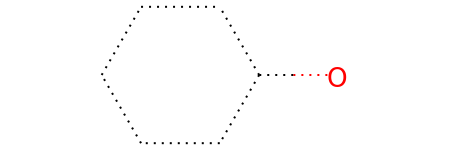

In [10]:
patt

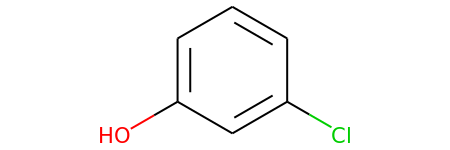

In [11]:
mol

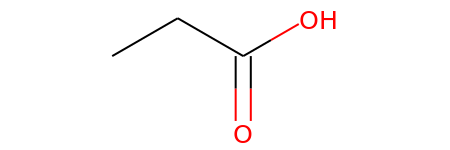

In [12]:
mol = Chem.MolFromSmiles('O=C(O)CC')
mol

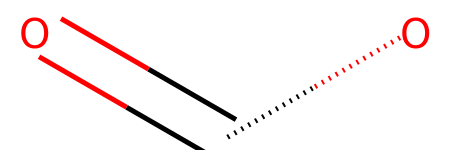

In [13]:
patt = Chem.MolFromSmarts('[OH]C=O')
patt

In [14]:

mol.HasSubstructMatch(patt)

True

In [15]:
CCO

NameError: name 'CCO' is not defined

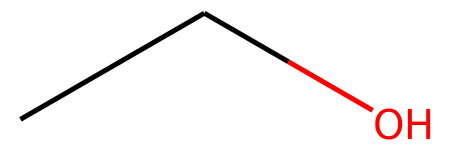

In [17]:
mol = Chem.MolFromSmiles('CCO')
mol

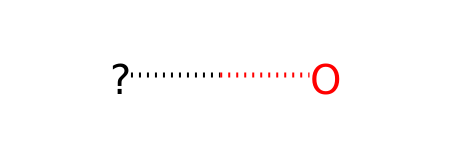

In [18]:
patt = Chem.MolFromSmarts('[C;!#6;!#6][OH]')
patt


In [19]:
mol.HasSubstructMatch(patt)

False

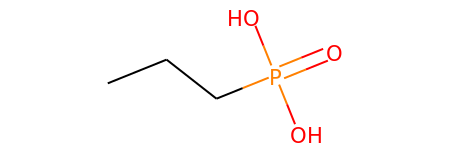

In [280]:
mol = Chem.MolFromSmiles('O=P(CCC)(O)O')
mol

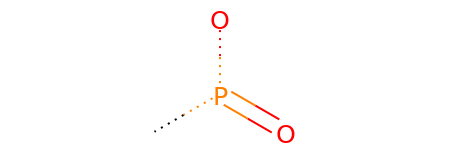

In [299]:
patt = Chem.MolFromSmarts('O=P([C])[OH]')
patt

In [300]:
mol.HasSubstructMatch(patt)

True

In [283]:
def get_acidic_atom_class(Smiles):
    
    atom_class_dic = {}
    
    #patt_1 = Chem.MolFromSmarts('c[OH]') # 酚羟基
    patt_1 = Chem.MolFromSmarts('[OH]c1ccccc1') # 酚羟基
    patt_2 = Chem.MolFromSmarts('Cc[OH]') # 醇羟基
    patt_3 = Chem.MolFromSmarts('C([NH])=O') # 酰胺1
    patt_4 = Chem.MolFromSmarts('C([NH2])=O') # 酰胺2
    patt_5 = Chem.MolFromSmarts('O=S([NH])=O')  # 磺胺1
    patt_6 = Chem.MolFromSmarts('O=S([NH2])=O')  # 磺胺2
    patt_7 = Chem.MolFromSmarts('[OH]C=O')  # 羧基
    patt_8 = Chem.MolFromSmarts('O=P([C])([OH])[OH]')  # 羧基
    
    mol = Chem.MolFromSmiles(Smiles)
    
    if mol.HasSubstructMatch(patt_1):
        atom_ids = mol.GetSubstructMatches(patt_1)
        for i in atom_ids:
            atom_class_dic[i[1]] = 'Phenol'
    
    if mol.HasSubstructMatch(patt_2):
        atom_ids = mol.GetSubstructMatches(patt_2)
        for i in atom_ids:
            atom_class_dic[i[1]] = 'Alcohol'
            
    if mol.HasSubstructMatch(patt_3):
        atom_ids = mol.GetSubstructMatches(patt_3)
        for i in atom_ids:
            atom_class_dic[i[1]] = 'Amide'
            
    if mol.HasSubstructMatch(patt_4):
        atom_ids = mol.GetSubstructMatches(patt_4)
        for i in atom_ids:
            atom_class_dic[i[1]] = 'Amide2'     
            
    if mol.HasSubstructMatch(patt_5):
        atom_ids = mol.GetSubstructMatches(patt_5)
        for i in atom_ids:
            atom_class_dic[i[2]] = 'Sulfa'  
            
    if mol.HasSubstructMatch(patt_6):
        atom_ids = mol.GetSubstructMatches(patt_6)  
        for i in atom_ids:
            atom_class_dic[i[2]] = 'Sulfa2'  
        
    if mol.HasSubstructMatch(patt_7):
        atom_ids = mol.GetSubstructMatches(patt_7)  #羧基放后面就是了
        for i in atom_ids:
            atom_class_dic[i[0]] = 'Carboxylic Acid'  
        
    if mol.HasSubstructMatch(patt_8):
        atom_ids = mol.GetSubstructMatches(patt_8)  #羧基放后面就是了
        for i in atom_ids:
            atom_class_dic[i[-1]] = 'Phosphoric Acid'  
        
    return atom_class_dic

In [284]:
atom_feature_class_lis = []
smiles_lis_ref = []
for smiles,atom_feature in zip(smiles_lis,atom_feature_lis):
    atom_class_dic = get_acidic_atom_class(smiles)
    for i in atom_class_dic.keys():
        #print(smiles)
        #print(atom_feature.size())
        #print(atom_feature[i],atom_class_dic[i])
        atom_feature_class_lis.append((smiles,atom_feature[i],atom_class_dic[i]))

In [285]:
# import pickle
# pickle.dump(atom_feature_class_lis,open('./Atom_Hidden_Features_Analysis/atom_feature_class_lis.pkl','wb'))  #后缀.pkl可加可不加

In [286]:
# import pickle
# atom_feature_class_lis = pickle.load(open('./Atom_Hidden_Features_Analysis/atom_feature_class_lis.pkl','rb'))

In [262]:
import numpy as np

In [263]:
Alcohol = []
Phenol = []
Carboxylic_Acid = []
Amide = []
Sulfa = []
Phosphoric_Acid = []

ref_smiles_lis = []

for smiles,i,j in atom_feature_class_lis:
    if j == 'Alcohol':
        Alcohol.append(i.tolist())
        ref_smiles_lis.append(smiles)
    elif j == 'Phenol':
        Phenol.append(i.tolist())
        ref_smiles_lis.append(smiles)
    elif j == 'Carboxylic Acid':
        Carboxylic_Acid.append(i.tolist())
        ref_smiles_lis.append(smiles)
    elif j == 'Amide2':
        Amide.append(i.tolist())    
        ref_smiles_lis.append(smiles)
    elif j == 'Sulfa2':
        Sulfa.append(i.tolist())   
        ref_smiles_lis.append(smiles)
    elif j == 'Phosphoric Acid':
        Phosphoric_Acid.append(i.tolist())   
        ref_smiles_lis.append(smiles)
        

        
#     if j in ['Alcohol','Phenol','Carboxylic Acid','Amide','Sulfa']:
#         features.append(i.tolist())
#         ss_class.append(j)
# features = np.array(features)

In [264]:
X = Alcohol + Phenol + Carboxylic_Acid + Amide + Sulfa + Phosphoric_Acid

In [265]:
import numpy as np
from sklearn.decomposition import PCA
X = np.array(X)  #导入数据，维度为4
pca = PCA(n_components=3)   #降到2维
pca.fit(X)                  #训练
newX=pca.transform(X)   #降维后的数据
# PCA(copy=True, n_components=2, whiten=False)
print(pca.explained_variance_ratio_)  #输出贡献率
print(newX)   

[0.91142992 0.03729102 0.01075548]
[[ 0.7790316  -0.27100992 -0.40902593]
 [ 0.67407566 -0.36799229 -0.42721554]
 [ 0.32552031 -0.37663188 -0.26623479]
 ...
 [-1.72234497 -0.05663401 -0.07218024]
 [-1.84506993 -0.16421328 -0.02713423]
 [-1.55754742 -0.02683942 -0.06394533]]


In [266]:
print(len(Alcohol))
print(len(Alcohol)+len(Phenol))
print(len(Alcohol)+len(Phenol)+len(Carboxylic_Acid))
print(len(Alcohol)+len(Phenol)+len(Carboxylic_Acid)+len(Amide))
print(len(Alcohol)+len(Phenol)+len(Carboxylic_Acid)+len(Amide)+len(Sulfa))
print(len(Alcohol)+len(Phenol)+len(Carboxylic_Acid)+len(Amide)+len(Sulfa)+len(Phosphoric_Acid))

2181
3888
8137
8272
8458
8573


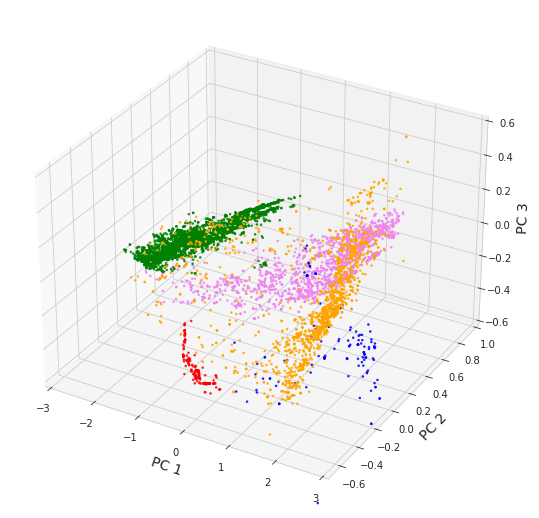

In [267]:
import re, seaborn as sns, numpy as np, pandas as pd, random
from pylab import *
from matplotlib.pyplot import plot, show, draw, figure, cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(7,7))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2


ax.scatter(newX[:2181,0],newX[:2181,1],newX[:2181,2], s= 2.5,alpha = 0.75,c= 'orange')
ax.scatter(newX[2181:3888,0],newX[2181:3888,1],newX[2181:3888,2],s=2.5,alpha = 0.75,c='violet')
ax.scatter(newX[3888:8137,0],newX[3888:8137,1],newX[3888:8137,2],s= 2.5,alpha = 0.75,c='green')
ax.scatter(newX[8137:8272,0],newX[8137:8272,1],newX[8137:8272,2],s= 2.5,alpha = 0.75,c='blue')
ax.scatter(newX[8272:8458,0],newX[8272:8458,1],newX[8272:8458,2],s= 2.5,alpha = 0.75,c='red')
#ax.scatter(newX[8458:,0],newX[8458:,1],newX[8458:,2],s= 10,alpha = 0.75,c='red')

# ax.scatter(newX[:2181,0],newX[:2181,1],newX[:2181,2], s= 2.5,alpha = 0.75,c= 'orange',label='R-OH')
# ax.scatter(newX[2181:3888,0],newX[2181:3888,1],newX[2181:3888,2],s=2.5,alpha = 0.75,c='violet',label= 'Ar-OH')
# ax.scatter(newX[3888:8754,0],newX[3888:8754,1],newX[3888:8754,2],s= 2.5,alpha = 0.75,c='green',label= '- COOH')
# ax.scatter(newX[8754:10470,0],newX[8754:10470,1],newX[8754:10470,2],s= 2.5,alpha = 0.75,c='blue',label= '- CONH${_2}$')
# ax.scatter(newX[10470:10958,0],newX[10470:10958,1],newX[10470:10958,2],s= 2.5,alpha = 0.75,c='red',label= '- SO${_2}$NH${_2}$')

ax.set_xlabel('    PC 1    ',fontsize=14)
ax.set_ylabel('    PC 2    ',fontsize=14)
ax.set_zlabel('    PC 3    ',fontsize=14)
ax.set_xlim(-3,3)
ax.set_ylim(-0.7,1)
ax.set_zlim3d(-0.6,0.6)
#plt.zlim(-0.6,0.6)
#ax.legend(loc='best',fontsize=14)

plt.show()

In [268]:
X

array([[0.21861684, 0.31280127, 0.55425429, ..., 0.25486583, 0.21260402,
        0.        ],
       [0.22948971, 0.2989563 , 0.52868807, ..., 0.2447532 , 0.24444015,
        0.        ],
       [0.19790748, 0.29009002, 0.48221323, ..., 0.20690322, 0.16637565,
        0.        ],
       ...,
       [0.        , 0.02185054, 0.19710764, ..., 0.05488778, 0.07084741,
        0.        ],
       [0.        , 0.02832175, 0.16921639, ..., 0.04294818, 0.0588772 ,
        0.03434757],
       [0.        , 0.03224187, 0.24111147, ..., 0.05792136, 0.06957929,
        0.        ]])

In [697]:
def get_acidic_atom_class(Smiles):
    
    atom_class_dic = {}
    
    #patt_1 = Chem.MolFromSmarts('c[OH]') # 酚羟基
    patt_1 = Chem.MolFromSmarts('[OH]c1ccccc1') # 酚羟基
    patt_2 = Chem.MolFromSmarts('C[OH]') # 醇羟基
    patt_3 = Chem.MolFromSmarts('C([NH])=O') # 酰胺1
    patt_4 = Chem.MolFromSmarts('C([NH2])=O') # 酰胺2
    patt_5 = Chem.MolFromSmarts('O=S([NH])=O')  # 磺胺1
    patt_6 = Chem.MolFromSmarts('O=S([NH2])=O')  # 磺胺2
    patt_7 = Chem.MolFromSmarts('[OH]C=O')  # 羧基
    patt_8 = Chem.MolFromSmarts('O=P([C])[OH]')  # 羧基
    
    mol = Chem.MolFromSmiles(Smiles)
    
    if mol.HasSubstructMatch(patt_1):
        atom_ids = mol.GetSubstructMatches(patt_1)
        for i in atom_ids:
            atom_class_dic[i[0]] = 'Phenol'
    
    if mol.HasSubstructMatch(patt_2):
        atom_ids = mol.GetSubstructMatches(patt_2)
        for i in atom_ids:
            atom_class_dic[i[1]] = 'Alcohol'
            
    if mol.HasSubstructMatch(patt_3):
        atom_ids = mol.GetSubstructMatches(patt_3)
        for i in atom_ids:
            atom_class_dic[i[1]] = 'Amide'
            
    if mol.HasSubstructMatch(patt_4):
        atom_ids = mol.GetSubstructMatches(patt_4)
        for i in atom_ids:
            atom_class_dic[i[1]] = 'Amide2'     
            
    if mol.HasSubstructMatch(patt_5):
        atom_ids = mol.GetSubstructMatches(patt_5)
        for i in atom_ids:
            atom_class_dic[i[2]] = 'Sulfa'  
            
    if mol.HasSubstructMatch(patt_6):
        atom_ids = mol.GetSubstructMatches(patt_6)  
        for i in atom_ids:
            atom_class_dic[i[2]] = 'Sulfa2'  
        
    if mol.HasSubstructMatch(patt_7):
        atom_ids = mol.GetSubstructMatches(patt_7)  #羧基放后面就是了
        for i in atom_ids:
            atom_class_dic[i[0]] = 'Carboxylic Acid'  
        
    if mol.HasSubstructMatch(patt_8):
        atom_ids = mol.GetSubstructMatches(patt_8)  #羧基放后面就是了
        for i in atom_ids:
            atom_class_dic[i[-1]] = 'Phosphoric Acid'  
        
    return atom_class_dic

In [698]:
atom_feature_class_lis = []
smiles_lis_ref = []
for smiles,atom_feature in zip(smiles_lis,atom_feature_lis):
    atom_class_dic = get_acidic_atom_class(smiles)
    for i in atom_class_dic.keys():
        #print(smiles)
        #print(atom_feature.size())
        #print(atom_feature[i],atom_class_dic[i])
        atom_feature_class_lis.append((smiles,atom_feature[i],atom_class_dic[i]))

In [909]:
Alcohol = []
Phenol = []
Carboxylic_Acid = []
Amide = []
Sulfa = []
Phosphoric_Acid = []

Alcohol_smiles_lis = []
Phenol_smiles_lis = []
Carboxylic_Acid_smiles_lis = []
Amide_smiles_lis = []
Sulfa_smiles_lis = []
Phosphoric_Acid_smiles_lis = []

candicate_acid_lis= []
candicate_Amide_lis= []


for smiles,i,j in atom_feature_class_lis:
    if j == 'Alcohol':
        Alcohol.append(i.tolist())
        Alcohol_smiles_lis.append(smiles)
    elif j == 'Phenol':
        Phenol.append(i.tolist())
        Phenol_smiles_lis.append(smiles)
    elif j == 'Carboxylic Acid':
        Carboxylic_Acid.append(i.tolist())
        Carboxylic_Acid_smiles_lis.append(smiles)
        
        if smiles in ['NC(=O)CCC(N)C(=O)NCC(=O)O','C=C(C)C(C)(C(N)=O)C(=O)O','NC(=O)CC(=O)O']:
            candicate_acid_lis.append(i.tolist())
            print(smiles)
            
    elif j == 'Amide2':
        Amide.append(i.tolist())    
        Amide_smiles_lis.append(smiles)

        if smiles in ['NC(=O)CCC(N)C(=O)NCC(=O)O','C=C(C)C(C)(C(N)=O)C(=O)O','NC(=O)CC(=O)O']:
            candicate_Amide_lis.append(i.tolist())
            print(smiles)
            
    elif j == 'Sulfa2':
        Sulfa.append(i.tolist())   
        Sulfa_smiles_lis.append(smiles)
    elif j == 'Phosphoric Acid':
        Phosphoric_Acid.append(i.tolist())   
        Phosphoric_Acid_smiles_lis.append(smiles)
        

        
#     if j in ['Alcohol','Phenol','Carboxylic Acid','Amide','Sulfa']:
#         features.append(i.tolist())
#         ss_class.append(j)
# features = np.array(features)

NC(=O)CC(=O)O
NC(=O)CC(=O)O
C=C(C)C(C)(C(N)=O)C(=O)O
C=C(C)C(C)(C(N)=O)C(=O)O
NC(=O)CCC(N)C(=O)NCC(=O)O
NC(=O)CCC(N)C(=O)NCC(=O)O


In [852]:
NC(=O)CCC(N)C(=O)NCC(=O)O

SyntaxError: invalid syntax (<ipython-input-852-f37b9dc0066f>, line 1)

In [ ]:
'CC(C)(C(=O)O)C(C(N)=O)c1ccccc1','NC(=O)C(CCCCC(=O)O)c1ccccc1'

In [829]:
X = Alcohol + Phenol + Carboxylic_Acid + Amide + Sulfa + Phosphoric_Acid

In [830]:
import numpy as np
from sklearn.decomposition import PCA
X = np.array(X)  #导入数据，维度为4
pca = PCA(n_components=3)   #降到2维
pca.fit(X)                  #训练
newX=pca.transform(X)   #降维后的数据
# PCA(copy=True, n_components=2, whiten=False)
print(pca.explained_variance_ratio_)  #输出贡献率
print(newX)   

[0.91694176 0.03426606 0.01046971]
[[ 8.43988782e-01 -3.26058864e-01 -3.37106772e-01]
 [ 7.41775938e-01 -4.05249819e-01 -3.78870252e-01]
 [ 3.92484668e-01 -4.13208589e-01 -1.92525297e-01]
 ...
 [-1.77770275e+00 -1.71100832e-01  1.27481610e-03]
 [-1.49112414e+00 -3.31869754e-02 -5.62293457e-02]
 [-1.49112414e+00 -3.31869749e-02 -5.62293477e-02]]


In [831]:
print(len(Alcohol))
print(len(Alcohol)+len(Phenol))
print(len(Alcohol)+len(Phenol)+len(Carboxylic_Acid))
print(len(Alcohol)+len(Phenol)+len(Carboxylic_Acid)+len(Amide))
print(len(Alcohol)+len(Phenol)+len(Carboxylic_Acid)+len(Amide)+len(Sulfa))
print(len(Alcohol)+len(Phenol)+len(Carboxylic_Acid)+len(Amide)+len(Sulfa)+len(Phosphoric_Acid))

2181
3888
8137
8272
8458
8779


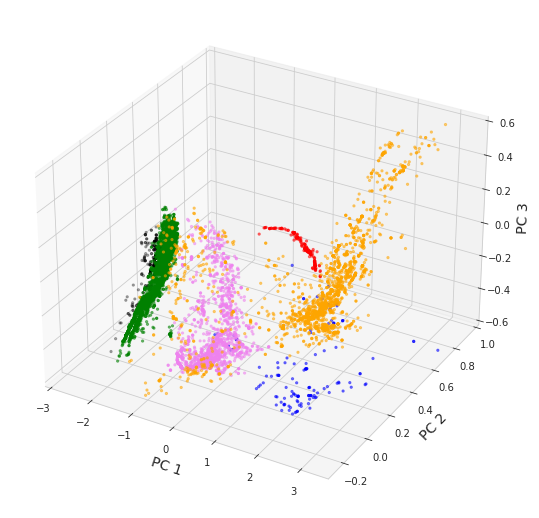

In [832]:
import re, seaborn as sns, numpy as np, pandas as pd, random
from pylab import *
from matplotlib.pyplot import plot, show, draw, figure, cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(7,7))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2


ax.scatter(newX[:2181,0],newX[:2181,1]*-1,newX[:2181,2], s= 5,alpha = 0.5,c= 'orange')
ax.scatter(newX[2181:3888,0],newX[2181:3888,1]*-1,newX[2181:3888,2],s=5,alpha = 0.5,c='violet')
ax.scatter(newX[3888:8137,0],newX[3888:8137,1]*-1,newX[3888:8137,2],s= 5,alpha = 0.5,c='green')
ax.scatter(newX[8137:8272,0],newX[8137:8272,1]*-1,newX[8137:8272,2],s= 5,alpha = 0.5,c='blue')
ax.scatter(newX[8272:8458,0],newX[8272:8458,1]*-1,newX[8272:8458,2],s= 5,alpha = 0.5,c='red')
ax.scatter(newX[8458:,0],newX[8458:,1]*-1,newX[8458:,2],s= 5,alpha = 0.3,c='black')

# ax.scatter(newX[:2181,0],newX[:2181,1],newX[:2181,2], s= 2.5,alpha = 0.75,c= 'orange',label='R-OH')
# ax.scatter(newX[2181:3888,0],newX[2181:3888,1],newX[2181:3888,2],s=2.5,alpha = 0.75,c='violet',label= 'Ar-OH')
# ax.scatter(newX[3888:8754,0],newX[3888:8754,1],newX[3888:8754,2],s= 2.5,alpha = 0.75,c='green',label= '- COOH')
# ax.scatter(newX[8754:10470,0],newX[8754:10470,1],newX[8754:10470,2],s= 2.5,alpha = 0.75,c='blue',label= '- CONH${_2}$')
# ax.scatter(newX[10470:10958,0],newX[10470:10958,1],newX[10470:10958,2],s= 2.5,alpha = 0.75,c='red',label= '- SO${_2}$NH${_2}$')

ax.set_xlabel('    PC 1    ',fontsize=14)
ax.set_ylabel('    PC 2    ',fontsize=14)
ax.set_zlabel('    PC 3    ',fontsize=14)
ax.set_xlim(-3,3.5)
ax.set_ylim(-0.3,1)
ax.set_zlim3d(-0.6,0.6)
#plt.zlim(-0.6,0.6)
#ax.legend(loc='best',fontsize=14)

plt.show()

In [833]:
8137  8272

SyntaxError: invalid syntax (<ipython-input-833-3375b84bf3c4>, line 1)

In [834]:
patt = Chem.MolFromSmarts('[OH]C=O')
mol.HasSubstructMatch(patt)

True

In [919]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"


NC(=O)NCC(=O)O


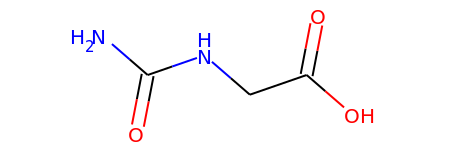

CO[C@@]1(NC(=O)Cc2cccs2)C(=O)N2C(C(=O)O)=C(COC(N)=O)CS[C@@H]21


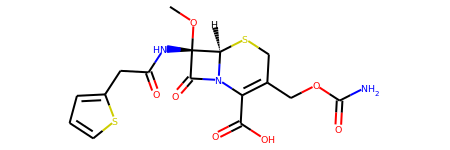

CC(C)=C(C(N)=O)C(=O)O


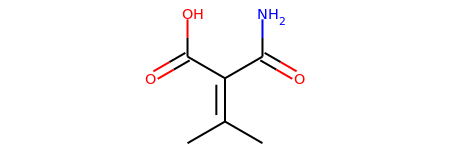

CC(C)(C(=O)O)C(C(N)=O)c1ccccc1


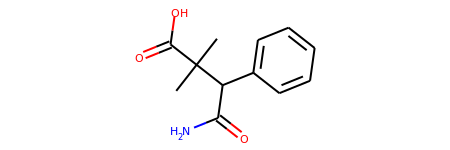

CC(C)(C)OC(=O)NC(CCC(N)=O)C(=O)O


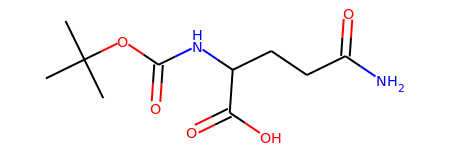

NC(=O)[C@H](CCC(=O)O)NC=O


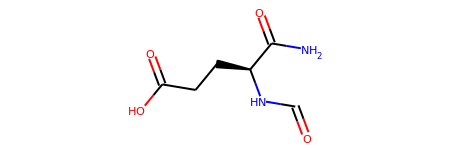

NC(=O)C#CC#C/C=C/C(=O)O


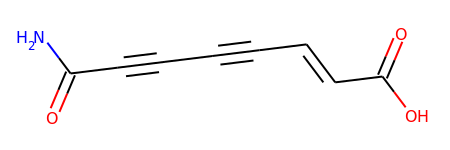

NC(=O)C(CC(=O)O)c1ccccc1


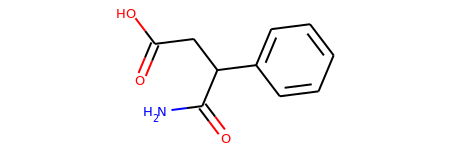

NC(=O)C(CCCCC(=O)O)c1ccccc1


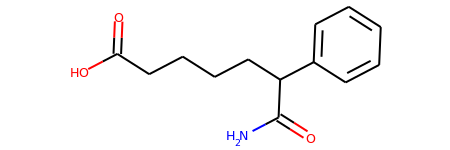

NC(=O)CC(=O)O


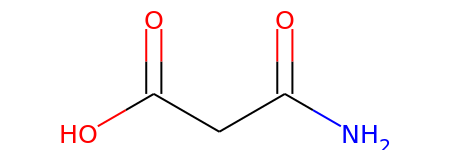

NC(=O)c1ccccc1C(=O)O


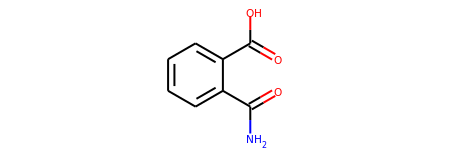

NC(=O)Cc1ccc(C(=O)O)cc1


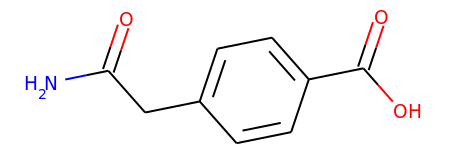

C=C(C)C(C)(C(N)=O)C(=O)O


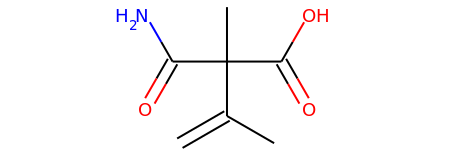

NC(=O)C(CCC(=O)O)c1ccccc1


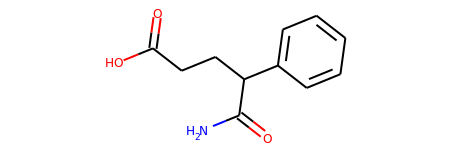

CC(CC(=O)O)C(N)=O


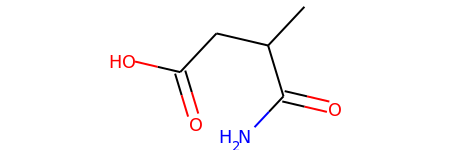

NC(=O)C(N)C(O)C(=O)O


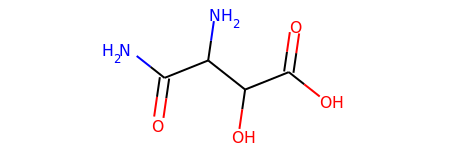

C=C(C)C1CNC(C(=O)O)C1CC(N)=O


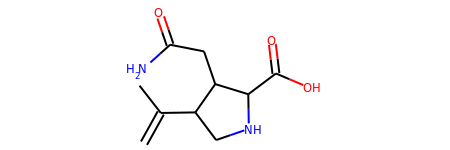

NC(=O)CN(CC(=O)O)CC(=O)O


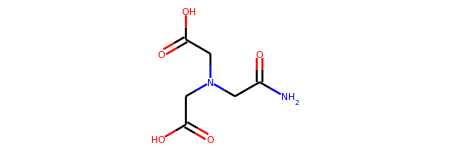

NC(=O)c1c(CC(=O)O)n[nH]c1N


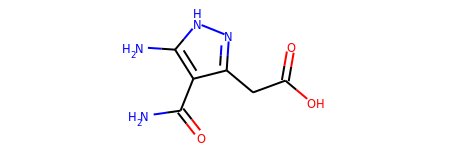

NC(=O)NOCC(=O)O


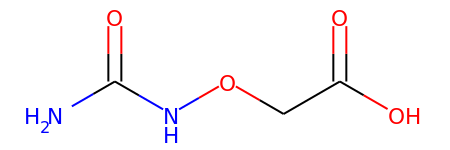

NC(=O)C1CC(=O)NC1C(=O)O


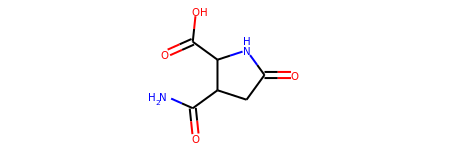

NC(=O)NOCCC(N)C(=O)O


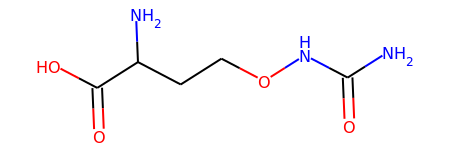

CC(NC(=O)C(CCC(N)=O)NC(=O)C1CCC(=O)N1)C(=O)O


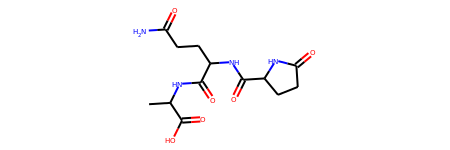

NC(=O)C(CCC(=O)O)NC=O


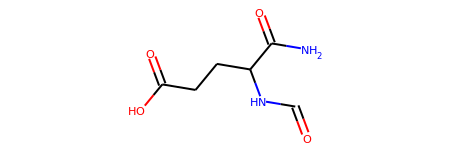

NC(=O)C#CC#CC=CC(=O)O


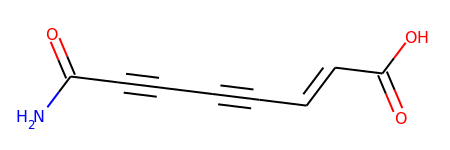

NC(=O)CC(N)C(=O)O


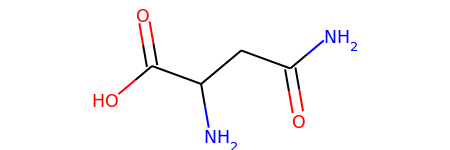

NC(=O)NC(C(=O)O)(c1ccccc1)c1ccccc1


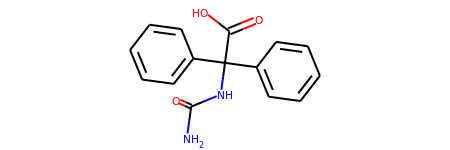

NC(=O)CCC(=O)O


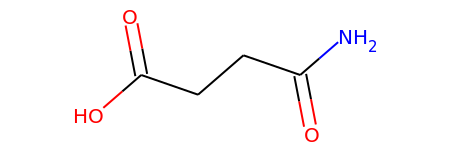

NC(=O)NCCCC(N)C(=O)O


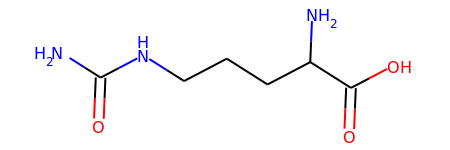

NC(=O)CCC(N)C(=O)O


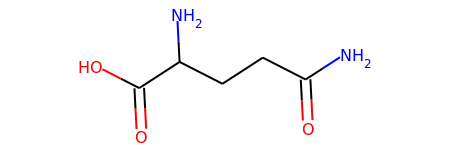

NC(=O)CCCC(=O)O


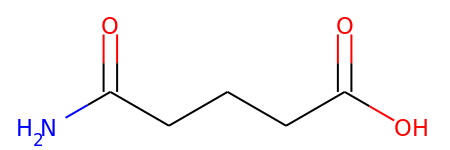

NC(=O)CCCCC(=O)O


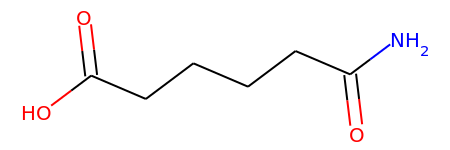

NC(=O)CCC(N)C(=O)NCC(=O)O


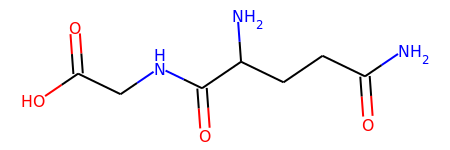

NCC(=O)NC(CC(N)=O)C(=O)O


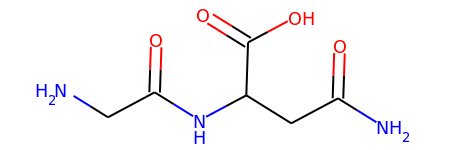

NC(=O)NC(C(=O)O)c1ccccc1


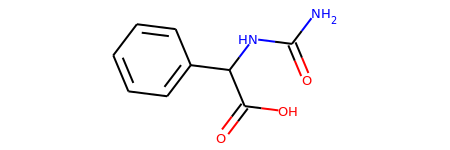

NC(=O)CC[C@H](N)C(=O)O


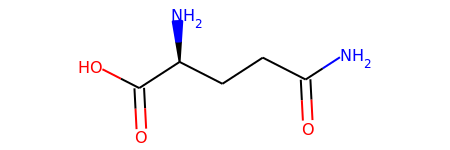

CC(C)C(NC(N)=O)C(=O)O


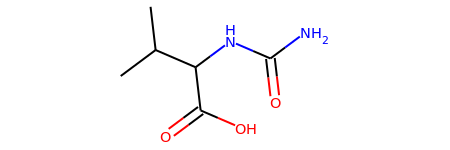

COc1ccc(N(CC(=O)O)C(N)=O)cc1


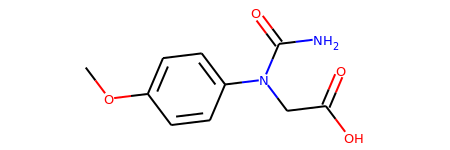

NC(=O)N(CC(=O)O)c1ccc(Cl)cc1


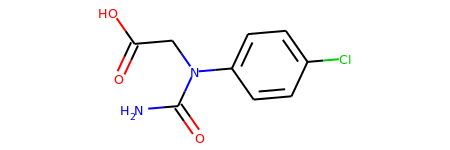

NC(=O)N(CC(=O)O)c1ccccc1


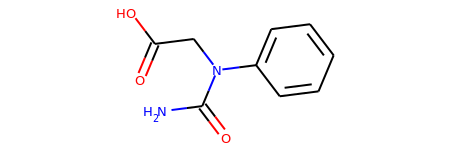

NC(=O)NC(Cc1ccccc1)C(=O)O


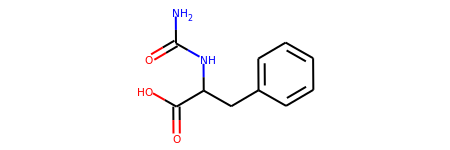

NC(=O)NN=C(CS)C(=O)O


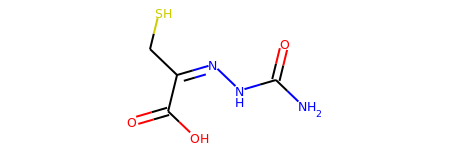

NC(=O)[C@@H]1CC(=O)N[C@H]1C(=O)O


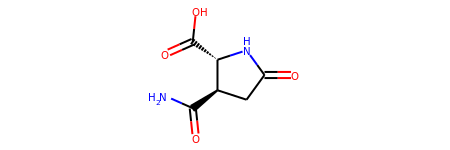

NCC(=O)NC(CCC(N)=O)C(=O)O


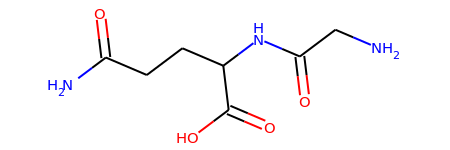

NC(=O)C[C@H](N)C(=O)NCC(=O)O


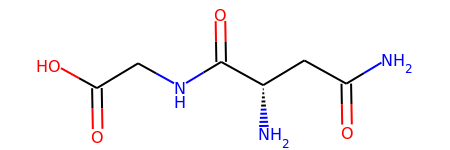

C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CN)C(=O)O


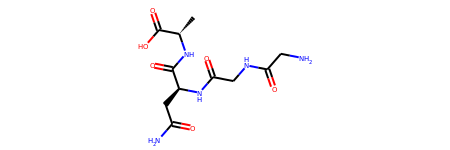

C[C@H](NC(=O)[C@H](CCC(N)=O)NC(=O)CNC(=O)CN)C(=O)O


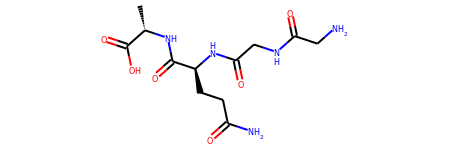

NCC(=O)N[C@@H](CC(N)=O)C(=O)O


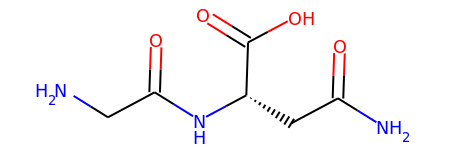

CC(C)C[C@H](NC(=O)[C@@H](N)CCC(=O)O)C(=O)N[C@H](C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CCC(=O)O)C(=O)O)[C@@H](C)O


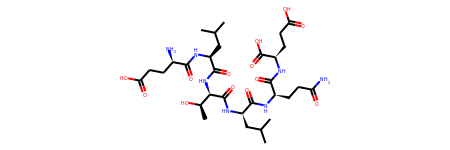

NC(=O)[C@H](N)[C@H](O)C(=O)O


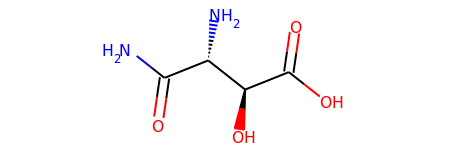

CC(C)C[C@H](N)C(=O)N[C@@H](CC(N)=O)C(=O)O


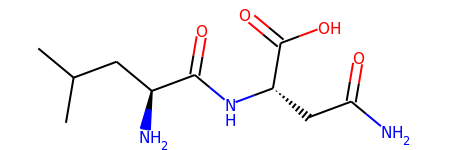

CC(C)C[C@H](N)C(=O)N[C@@H](CCC(N)=O)C(=O)O


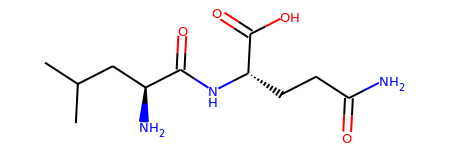

CC(C)[C@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](N)CC(N)=O)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@H](C(=O)N[C@@H](Cc1c[nH]cn1)C(=O)N1CCC[C@H]1C(=O)N[C@@H](Cc1ccccc1)C(=O)O)C(C)C


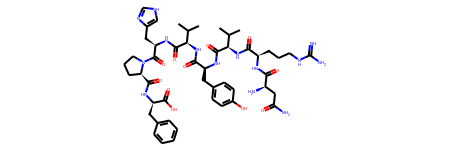

NC(=O)C[C@H](N)C(=O)O


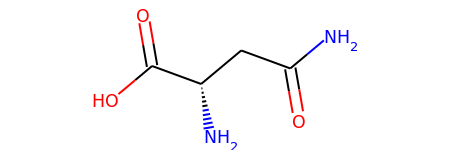

NC(=O)CC[C@H](N)C(=O)NCC(=O)O


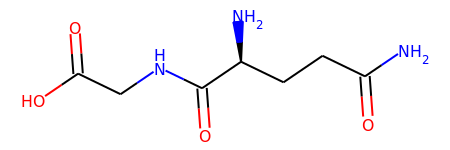

NC(=O)CC[C@H](N)C(=O)N[C@@H](CCC(=O)O)C(=O)O


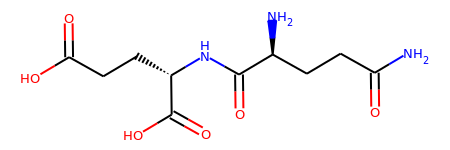

NC(=O)NCCC[C@H](N)C(=O)O


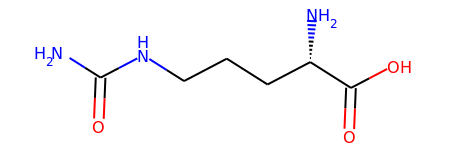

NC(=O)C[C@H](NC(=O)[C@@H](N)CS)C(=O)O


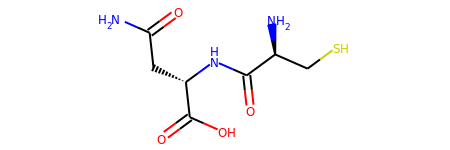

In [793]:
for smiles in Amide_smiles_lis:
    mol = Chem.MolFromSmiles(smiles)
    if mol.HasSubstructMatch(patt):
        print(smiles)
        mol

In [922]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

CC(C)(C(=O)O)c1ccc([C@@H](O)CCCN2CCC(C(O)(c3ccccc3)c3ccccc3)CC2)cc1


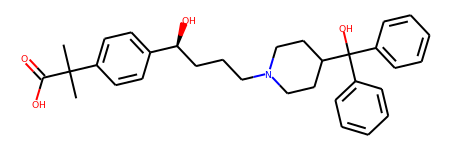

CC(C)(C(=O)O)c1ccc([C@@H](O)CCCN2CCC(C(O)(c3ccccc3)c3ccccc3)CC2)cc1


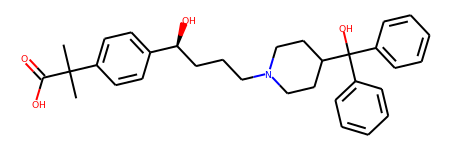

O=C(O)[C@H](O)c1cccc(F)c1


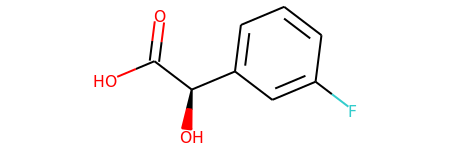

C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@H](O)[C@@](C)(C(=O)O1)[C@H]2[C@@H]3C(=O)O


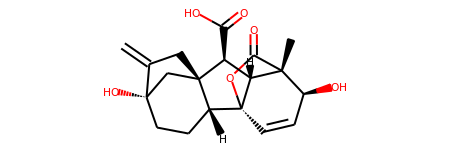

C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@H](O)[C@@](C)(C(=O)O1)[C@H]2[C@@H]3C(=O)O


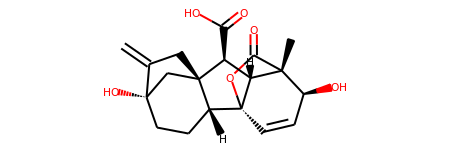

O=C(O)c1c(Cl)cccc1CO


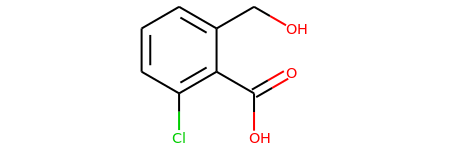

O=C(O)C(CO)(CO)CO


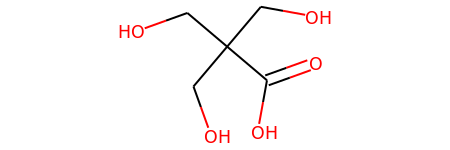

O=C(O)C(CO)(CO)CO


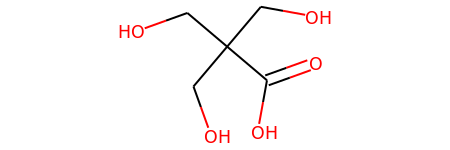

O=C(O)C(CO)(CO)CO


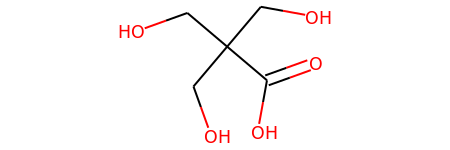

O=C(O)[C@H](CO)c1ccccc1


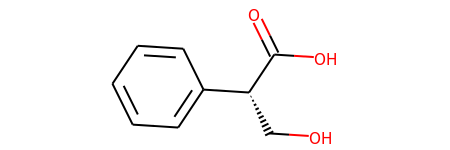

O=C(O)[C@H](O)c1ccccc1


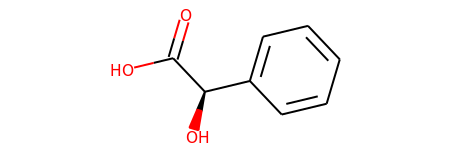

O=C(/C=C/c1ccc(O)c(O)c1)O[C@@H]1C[C@](O)(C(=O)O)C[C@@H](O)[C@H]1O


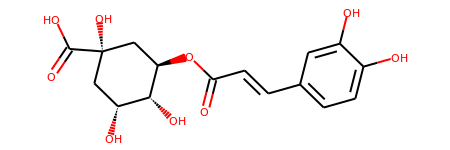

O=C(/C=C/c1ccc(O)c(O)c1)O[C@@H]1C[C@](O)(C(=O)O)C[C@@H](O)[C@H]1O


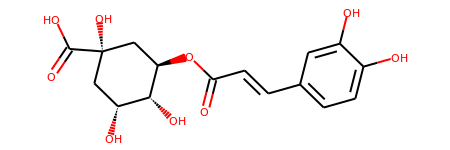

O=C(/C=C/c1ccc(O)c(O)c1)O[C@@H]1C[C@](O)(C(=O)O)C[C@@H](O)[C@H]1O


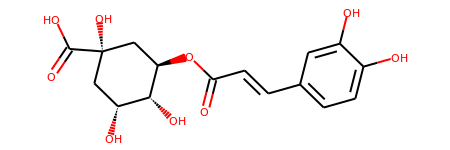

O=C(O)[C@H]1CCCC[C@@H]1O


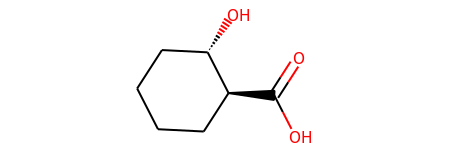

CCCCP(=O)(CCCC)[C@@](C)(O)C(=O)O


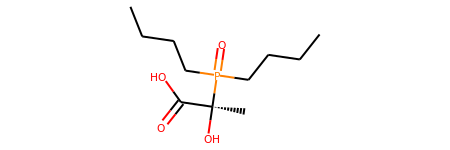

O=C(O)Cc1ccccc1CO


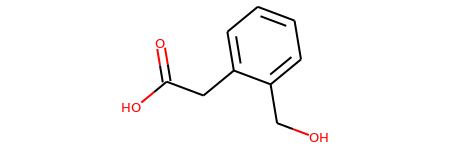

CC[C@@H](O)C(=O)O


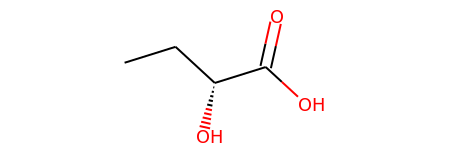

CCOc1cccc(C(=O)O)c1CO


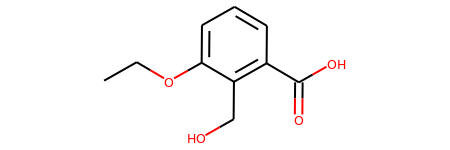

O=C(O)c1c(Br)cccc1CO


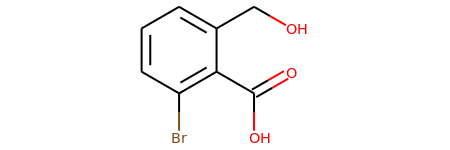

O=C(O)C[C@H](O)c1ccccc1


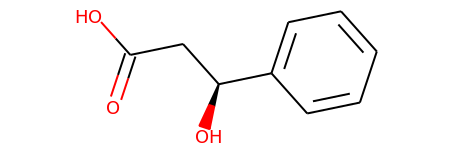

O=C(O)[C@H](O)C(Cl)(Cl)Cl


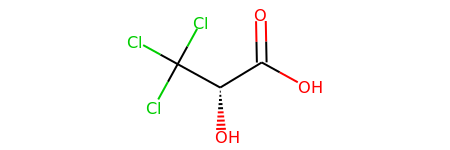

O=C(O)[C@H](O)CCl


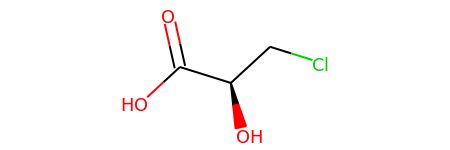

O=C(O)CO


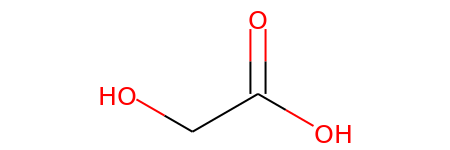

O=C(O)c1cccc(I)c1CO


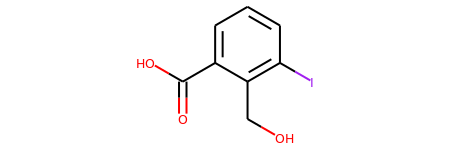

O=C(O)[C@H](O)c1cccc(Cl)c1


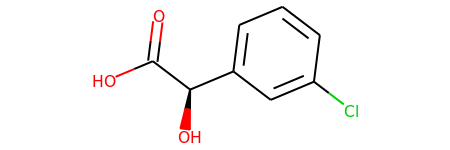

O=C(O)[C@H](O)c1cccc(Br)c1


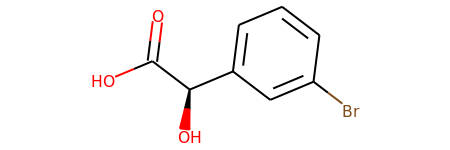

O=C(O)[C@H](O)c1cccc(I)c1


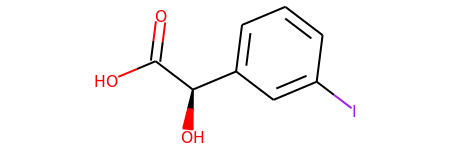

C[C@H](O)C(=O)O


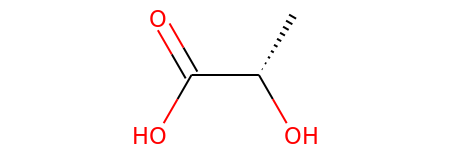

O=C(O)[C@H](O)[C@@H](O)[C@@H](O)[C@@H](O)CO


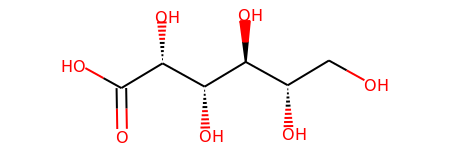

O=C(O)[C@H](O)[C@@H](O)[C@@H](O)[C@@H](O)CO


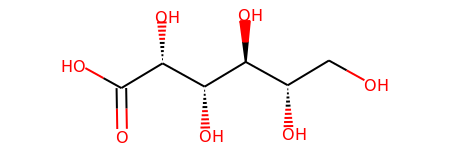

O=C(O)[C@H](O)[C@@H](O)[C@@H](O)[C@@H](O)CO


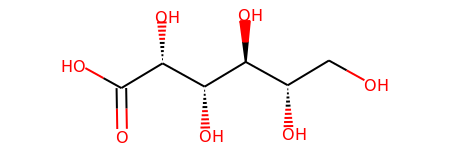

O=C(O)[C@H](O)[C@@H](O)[C@@H](O)[C@@H](O)CO


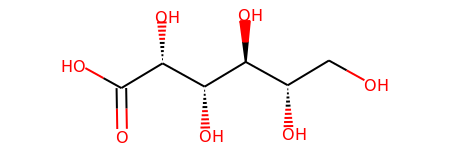

O=C(O)[C@H](O)[C@@H](O)[C@@H](O)[C@@H](O)CO


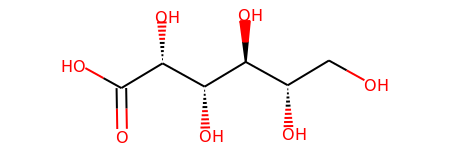

COc1cccc(C(=O)O)c1CO


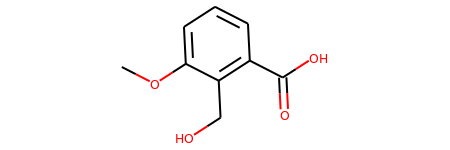

O=C(O)c1cccc(Br)c1CO


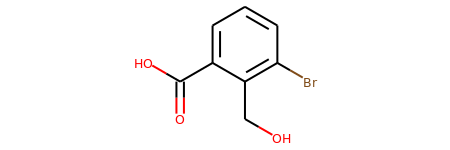

C[C@H](O)CC(=O)O


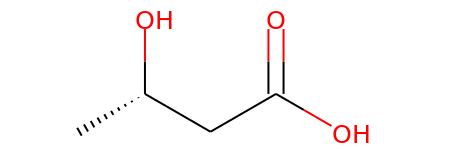

CC(C)(O)C(=O)O


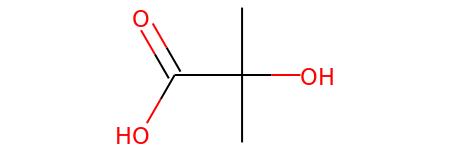

CC[C@H](C)C(=O)O[C@H]1C[C@H](O)C=C2C=C[C@H](C)[C@H](CC[C@@H](O)C[C@@H](O)CC(=O)O)[C@H]21


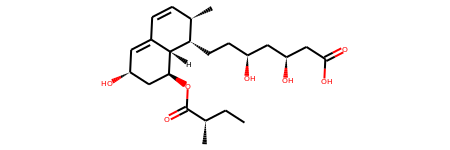

CC[C@H](C)C(=O)O[C@H]1C[C@H](O)C=C2C=C[C@H](C)[C@H](CC[C@@H](O)C[C@@H](O)CC(=O)O)[C@H]21


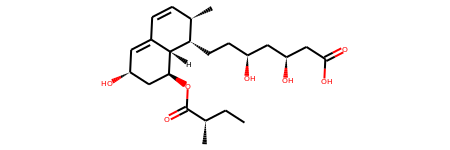

CC[C@H](C)C(=O)O[C@H]1C[C@H](O)C=C2C=C[C@H](C)[C@H](CC[C@@H](O)C[C@@H](O)CC(=O)O)[C@H]21


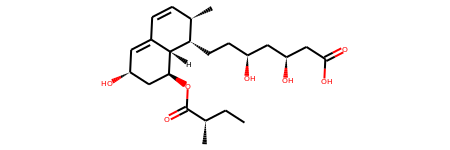

O=C(O)CCCO


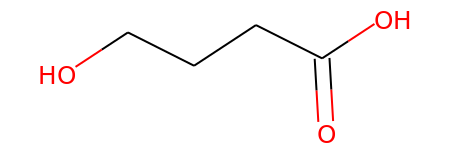

C[C@](O)(C(=O)O)c1ccccc1


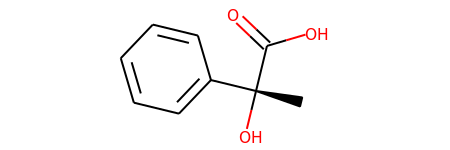

O=C(O)c1cccc(Cl)c1CO


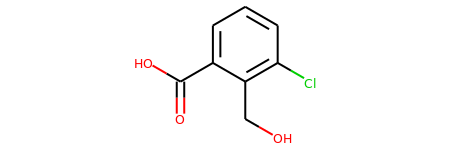

O=C(O)[C@@H](O)CO


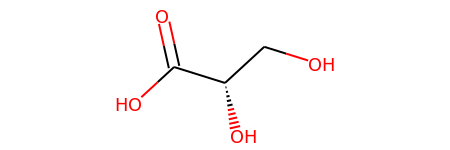

O=C(O)[C@@H](O)CO


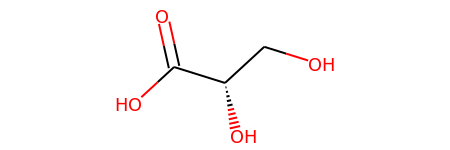

C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@H]3[C@H](C[C@H](O)[C@@]21C)[C@@]1(C)CC[C@@H](O)C[C@H]1C[C@H]3O


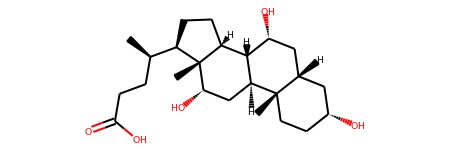

C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@H]3[C@H](C[C@H](O)[C@@]21C)[C@@]1(C)CC[C@@H](O)C[C@H]1C[C@H]3O


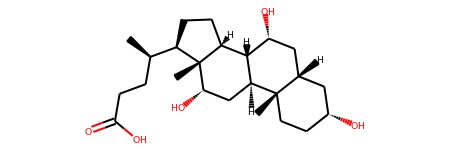

C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@H]3[C@H](C[C@H](O)[C@@]21C)[C@@]1(C)CC[C@@H](O)C[C@H]1C[C@H]3O


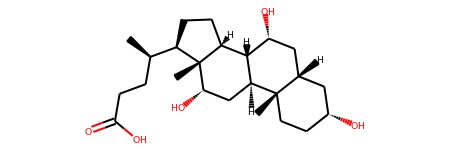

CCCCc1ccc([C@@H](O)C(=O)O)cc1


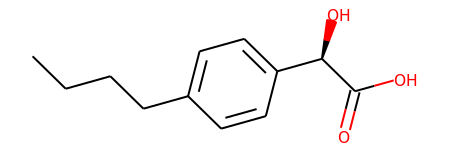

O=C(O)C(O)(c1ccccc1)c1ccccc1


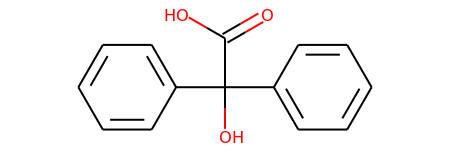

C[C@@H]1OC(=O)CC(O)CC(O)CC(O)CCC(O)C(O)C[C@]2(O)CC(O)C(C(=O)O)C(CC(O[C@H]3O[C@H](C)[C@@H](O)[C@H](N)[C@@H]3O)/C=C/C=C/C=C/C=C/CC/C=C/C=C/[C@H](C)[C@@H](O)[C@H]1C)O2


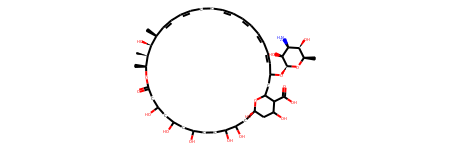

C[C@@H]1OC(=O)CC(O)CC(O)CC(O)CCC(O)C(O)C[C@]2(O)CC(O)C(C(=O)O)C(CC(O[C@H]3O[C@H](C)[C@@H](O)[C@H](N)[C@@H]3O)/C=C/C=C/C=C/C=C/CC/C=C/C=C/[C@H](C)[C@@H](O)[C@H]1C)O2


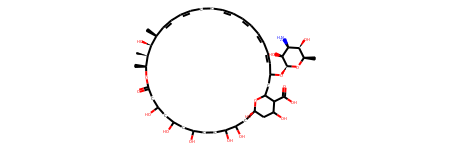

C[C@@H]1OC(=O)CC(O)CC(O)CC(O)CCC(O)C(O)C[C@]2(O)CC(O)C(C(=O)O)C(CC(O[C@H]3O[C@H](C)[C@@H](O)[C@H](N)[C@@H]3O)/C=C/C=C/C=C/C=C/CC/C=C/C=C/[C@H](C)[C@@H](O)[C@H]1C)O2


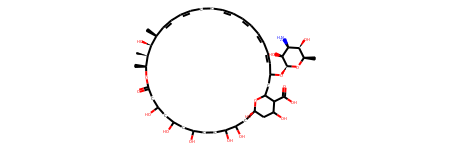

C[C@@H]1OC(=O)CC(O)CC(O)CC(O)CCC(O)C(O)C[C@]2(O)CC(O)C(C(=O)O)C(CC(O[C@H]3O[C@H](C)[C@@H](O)[C@H](N)[C@@H]3O)/C=C/C=C/C=C/C=C/CC/C=C/C=C/[C@H](C)[C@@H](O)[C@H]1C)O2


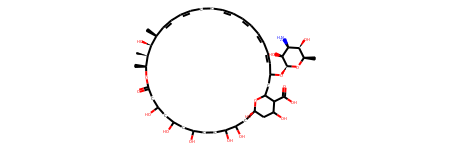

C[C@@H]1OC(=O)CC(O)CC(O)CC(O)CCC(O)C(O)C[C@]2(O)CC(O)C(C(=O)O)C(CC(O[C@H]3O[C@H](C)[C@@H](O)[C@H](N)[C@@H]3O)/C=C/C=C/C=C/C=C/CC/C=C/C=C/[C@H](C)[C@@H](O)[C@H]1C)O2


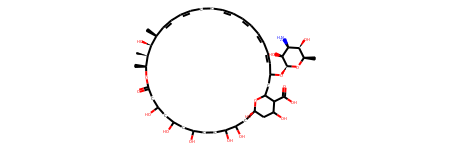

C[C@@H]1OC(=O)CC(O)CC(O)CC(O)CCC(O)C(O)C[C@]2(O)CC(O)C(C(=O)O)C(CC(O[C@H]3O[C@H](C)[C@@H](O)[C@H](N)[C@@H]3O)/C=C/C=C/C=C/C=C/CC/C=C/C=C/[C@H](C)[C@@H](O)[C@H]1C)O2


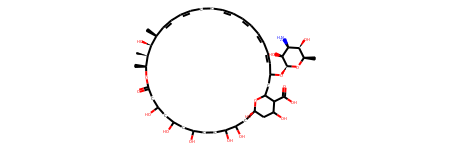

C[C@@H]1OC(=O)CC(O)CC(O)CC(O)CCC(O)C(O)C[C@]2(O)CC(O)C(C(=O)O)C(CC(O[C@H]3O[C@H](C)[C@@H](O)[C@H](N)[C@@H]3O)/C=C/C=C/C=C/C=C/CC/C=C/C=C/[C@H](C)[C@@H](O)[C@H]1C)O2


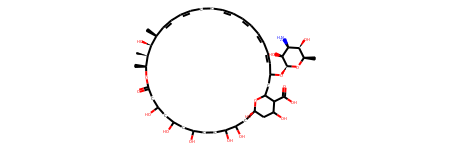

C[C@@H]1OC(=O)CC(O)CC(O)CC(O)CCC(O)C(O)C[C@]2(O)CC(O)C(C(=O)O)C(CC(O[C@H]3O[C@H](C)[C@@H](O)[C@H](N)[C@@H]3O)/C=C/C=C/C=C/C=C/CC/C=C/C=C/[C@H](C)[C@@H](O)[C@H]1C)O2


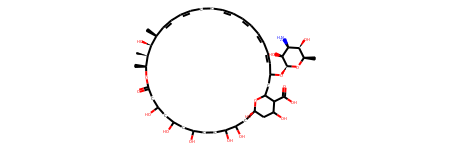

C[C@@H]1OC(=O)CC(O)CC(O)CC(O)CCC(O)C(O)C[C@]2(O)CC(O)C(C(=O)O)C(CC(O[C@H]3O[C@H](C)[C@@H](O)[C@H](N)[C@@H]3O)/C=C/C=C/C=C/C=C/CC/C=C/C=C/[C@H](C)[C@@H](O)[C@H]1C)O2


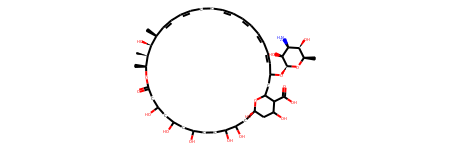

C[C@@H]1OC(=O)CC(O)CC(O)CC(O)CCC(O)C(O)C[C@]2(O)CC(O)C(C(=O)O)C(CC(O[C@H]3O[C@H](C)[C@@H](O)[C@H](N)[C@@H]3O)/C=C/C=C/C=C/C=C/CC/C=C/C=C/[C@H](C)[C@@H](O)[C@H]1C)O2


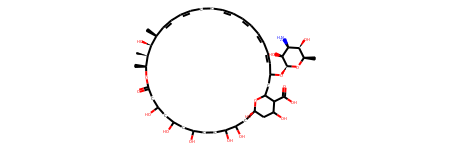

C[C@@H]1OC(=O)C[C@H](O)C[C@H](O)CC[C@@H](O)[C@H](O)C[C@H](O)C[C@]2(O)C[C@H](O)[C@@H](C(=O)O)[C@H](C[C@@H](O[C@@H]3O[C@H](C)[C@@H](O)[C@H](N)[C@@H]3O)/C=C/C=C/C=C/C=C/C=C/C=C/C=C/[C@H](C)[C@@H](O)[C@H]1C)O2


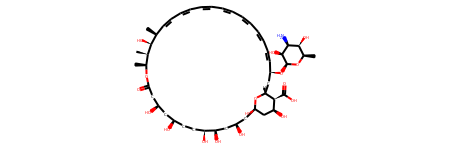

C[C@@H]1OC(=O)C[C@H](O)C[C@H](O)CC[C@@H](O)[C@H](O)C[C@H](O)C[C@]2(O)C[C@H](O)[C@@H](C(=O)O)[C@H](C[C@@H](O[C@@H]3O[C@H](C)[C@@H](O)[C@H](N)[C@@H]3O)/C=C/C=C/C=C/C=C/C=C/C=C/C=C/[C@H](C)[C@@H](O)[C@H]1C)O2


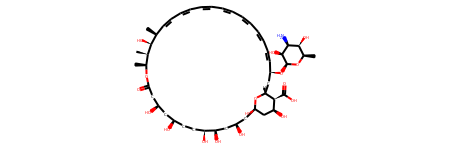

C[C@@H]1OC(=O)C[C@H](O)C[C@H](O)CC[C@@H](O)[C@H](O)C[C@H](O)C[C@]2(O)C[C@H](O)[C@@H](C(=O)O)[C@H](C[C@@H](O[C@@H]3O[C@H](C)[C@@H](O)[C@H](N)[C@@H]3O)/C=C/C=C/C=C/C=C/C=C/C=C/C=C/[C@H](C)[C@@H](O)[C@H]1C)O2


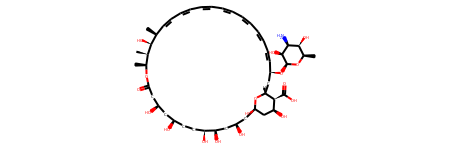

C[C@@H]1OC(=O)C[C@H](O)C[C@H](O)CC[C@@H](O)[C@H](O)C[C@H](O)C[C@]2(O)C[C@H](O)[C@@H](C(=O)O)[C@H](C[C@@H](O[C@@H]3O[C@H](C)[C@@H](O)[C@H](N)[C@@H]3O)/C=C/C=C/C=C/C=C/C=C/C=C/C=C/[C@H](C)[C@@H](O)[C@H]1C)O2


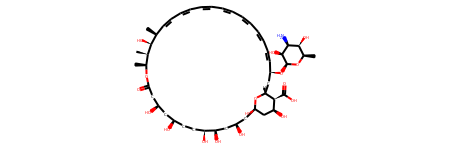

C[C@@H]1OC(=O)C[C@H](O)C[C@H](O)CC[C@@H](O)[C@H](O)C[C@H](O)C[C@]2(O)C[C@H](O)[C@@H](C(=O)O)[C@H](C[C@@H](O[C@@H]3O[C@H](C)[C@@H](O)[C@H](N)[C@@H]3O)/C=C/C=C/C=C/C=C/C=C/C=C/C=C/[C@H](C)[C@@H](O)[C@H]1C)O2


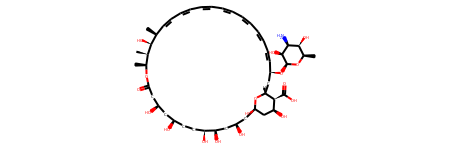

C[C@@H]1OC(=O)C[C@H](O)C[C@H](O)CC[C@@H](O)[C@H](O)C[C@H](O)C[C@]2(O)C[C@H](O)[C@@H](C(=O)O)[C@H](C[C@@H](O[C@@H]3O[C@H](C)[C@@H](O)[C@H](N)[C@@H]3O)/C=C/C=C/C=C/C=C/C=C/C=C/C=C/[C@H](C)[C@@H](O)[C@H]1C)O2


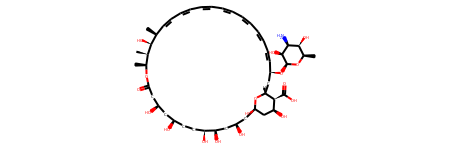

C[C@@H]1OC(=O)C[C@H](O)C[C@H](O)CC[C@@H](O)[C@H](O)C[C@H](O)C[C@]2(O)C[C@H](O)[C@@H](C(=O)O)[C@H](C[C@@H](O[C@@H]3O[C@H](C)[C@@H](O)[C@H](N)[C@@H]3O)/C=C/C=C/C=C/C=C/C=C/C=C/C=C/[C@H](C)[C@@H](O)[C@H]1C)O2


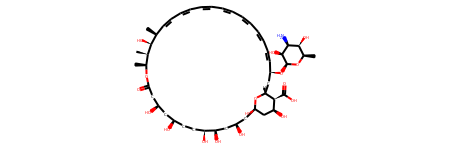

C[C@@H]1OC(=O)C[C@H](O)C[C@H](O)CC[C@@H](O)[C@H](O)C[C@H](O)C[C@]2(O)C[C@H](O)[C@@H](C(=O)O)[C@H](C[C@@H](O[C@@H]3O[C@H](C)[C@@H](O)[C@H](N)[C@@H]3O)/C=C/C=C/C=C/C=C/C=C/C=C/C=C/[C@H](C)[C@@H](O)[C@H]1C)O2


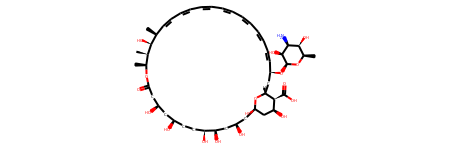

C[C@@H]1OC(=O)C[C@H](O)C[C@H](O)CC[C@@H](O)[C@H](O)C[C@H](O)C[C@]2(O)C[C@H](O)[C@@H](C(=O)O)[C@H](C[C@@H](O[C@@H]3O[C@H](C)[C@@H](O)[C@H](N)[C@@H]3O)/C=C/C=C/C=C/C=C/C=C/C=C/C=C/[C@H](C)[C@@H](O)[C@H]1C)O2


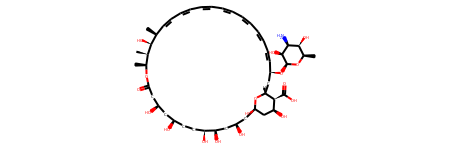

C[C@@H]1OC(=O)C[C@H](O)C[C@H](O)CC[C@@H](O)[C@H](O)C[C@H](O)C[C@]2(O)C[C@H](O)[C@@H](C(=O)O)[C@H](C[C@@H](O[C@@H]3O[C@H](C)[C@@H](O)[C@H](N)[C@@H]3O)/C=C/C=C/C=C/C=C/C=C/C=C/C=C/[C@H](C)[C@@H](O)[C@H]1C)O2


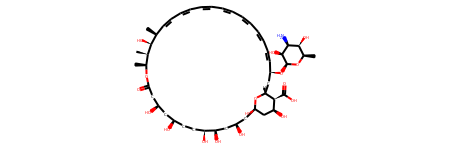

C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@H]3[C@H](CC[C@@]21C)[C@@]1(C)CC[C@@H](O)C[C@H]1C[C@H]3O


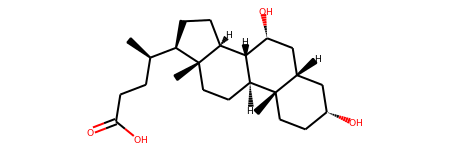

C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@H]3[C@H](CC[C@@]21C)[C@@]1(C)CC[C@@H](O)C[C@H]1C[C@H]3O


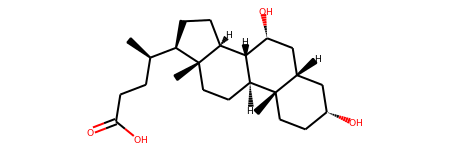

C[C@@H]1C/C=C/C=C/C=C/C=C/[C@H](O[C@@H]2O[C@H](C)[C@@H](O)[C@H](N)[C@@H]2O)C[C@@H]2O[C@](O)(C[C@@H](O)C[C@H]3O[C@@H]3/C=C/C(=O)O1)C[C@H](O)[C@H]2C(=O)O


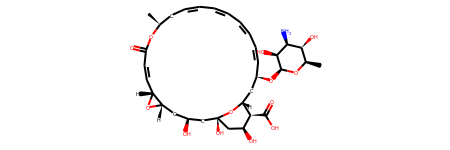

C[C@@H]1C/C=C/C=C/C=C/C=C/[C@H](O[C@@H]2O[C@H](C)[C@@H](O)[C@H](N)[C@@H]2O)C[C@@H]2O[C@](O)(C[C@@H](O)C[C@H]3O[C@@H]3/C=C/C(=O)O1)C[C@H](O)[C@H]2C(=O)O


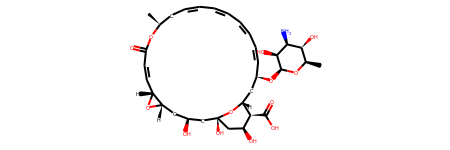

C[C@@H]1C/C=C/C=C/C=C/C=C/[C@H](O[C@@H]2O[C@H](C)[C@@H](O)[C@H](N)[C@@H]2O)C[C@@H]2O[C@](O)(C[C@@H](O)C[C@H]3O[C@@H]3/C=C/C(=O)O1)C[C@H](O)[C@H]2C(=O)O


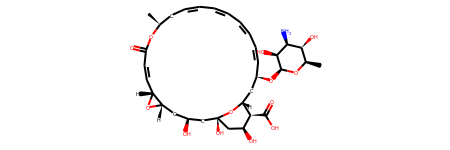

C[C@@H]1C/C=C/C=C/C=C/C=C/[C@H](O[C@@H]2O[C@H](C)[C@@H](O)[C@H](N)[C@@H]2O)C[C@@H]2O[C@](O)(C[C@@H](O)C[C@H]3O[C@@H]3/C=C/C(=O)O1)C[C@H](O)[C@H]2C(=O)O


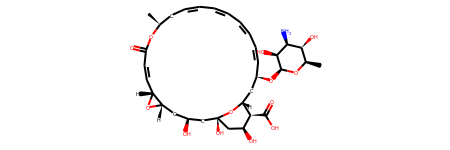

C[C@@H]1C/C=C/C=C/C=C/C=C/[C@H](O[C@@H]2O[C@H](C)[C@@H](O)[C@H](N)[C@@H]2O)C[C@@H]2O[C@](O)(C[C@@H](O)C[C@H]3O[C@@H]3/C=C/C(=O)O1)C[C@H](O)[C@H]2C(=O)O


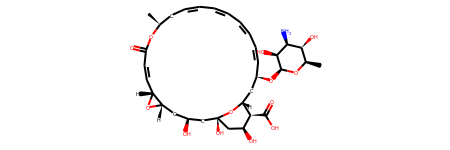

CCCCC[C@H](O)/C=C/[C@H]1[C@H](O)CC(=O)[C@@H]1C/C=C\CCCC(=O)O


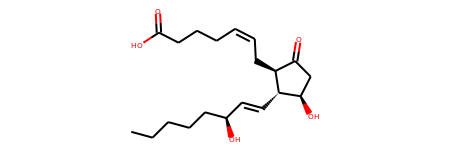

CCCCC[C@H](O)/C=C/[C@H]1[C@H](O)CC(=O)[C@@H]1C/C=C\CCCC(=O)O


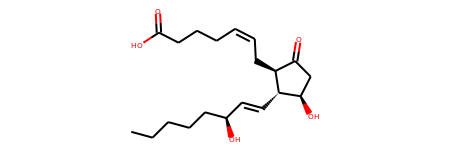

CC(=O)O[C@H]1C[C@@]2(C)[C@@H](C[C@@H](O)[C@H]3[C@@]4(C)CC[C@@H](O)[C@@H](C)[C@@H]4CC[C@@]32C)/C1=C(\CCC=C(C)C)C(=O)O


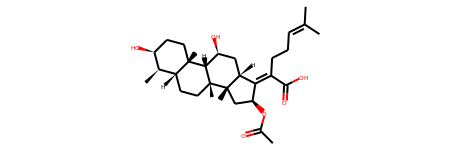

CC(=O)O[C@H]1C[C@@]2(C)[C@@H](C[C@@H](O)[C@H]3[C@@]4(C)CC[C@@H](O)[C@@H](C)[C@@H]4CC[C@@]32C)/C1=C(\CCC=C(C)C)C(=O)O


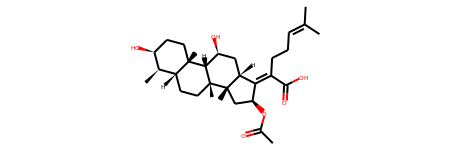

O=C(O)c1cc(=O)c2c(OCC(O)COc3cccc4oc(C(=O)O)cc(=O)c34)cccc2o1


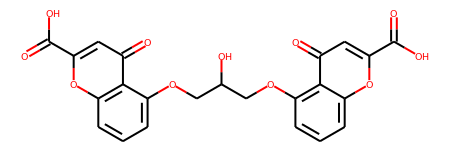

CCCCC[C@H](O)/C=C/[C@H]1[C@H](O)C[C@H](O)[C@@H]1C/C=C\CCCC(=O)O


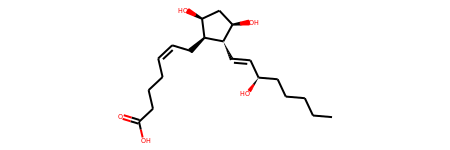

CCCCC[C@H](O)/C=C/[C@H]1[C@H](O)C[C@H](O)[C@@H]1C/C=C\CCCC(=O)O


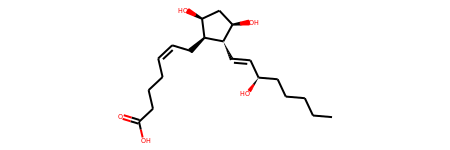

CCCCC[C@H](O)/C=C/[C@H]1[C@H](O)C[C@H](O)[C@@H]1C/C=C\CCCC(=O)O


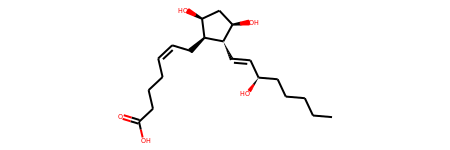

Cn1nnnc1SCC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)[C@H](O)c3ccccc3)[C@H]2SC1


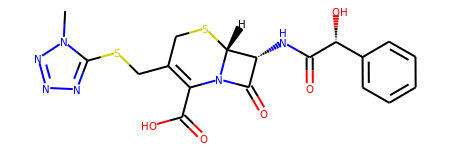

COc1cc(/C=C\C(=O)O)cc(S(=O)(=O)NCCO)c1OC


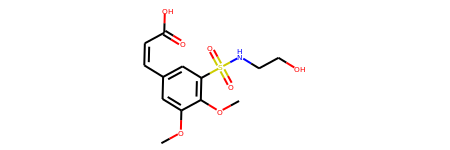

Cc1cc(=O)oc2cc(C3OC(C(=O)O)C(O)C(O)C3O)ccc12


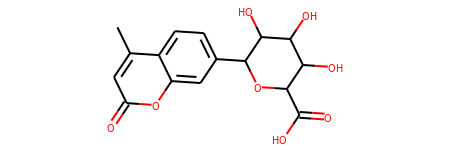

Cc1cc(=O)oc2cc(C3OC(C(=O)O)C(O)C(O)C3O)ccc12


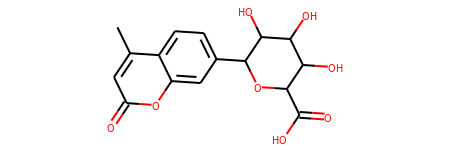

Cc1cc(=O)oc2cc(C3OC(C(=O)O)C(O)C(O)C3O)ccc12


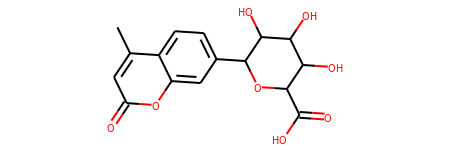

CC1OC(O[C@H]2/C=C/C=C/C=C/C=C/C=C/C=C/C=C/[C@H](C)[C@@H](O)[C@@H](C)[C@H](C)OC(=O)C[C@H](O)C[C@H](O)CC[C@@H](O)[C@H](O)C[C@H](O)C[C@]3(O)C[C@H](O)[C@@H](C(=O)O)[C@H](C2)O3)C(O)C(N)C1O


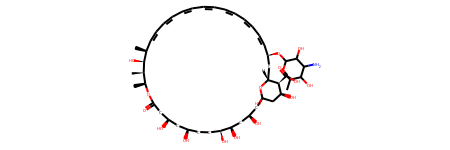

CC1OC(O[C@H]2/C=C/C=C/C=C/C=C/C=C/C=C/C=C/[C@H](C)[C@@H](O)[C@@H](C)[C@H](C)OC(=O)C[C@H](O)C[C@H](O)CC[C@@H](O)[C@H](O)C[C@H](O)C[C@]3(O)C[C@H](O)[C@@H](C(=O)O)[C@H](C2)O3)C(O)C(N)C1O


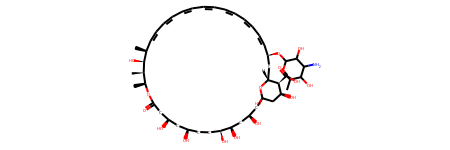

CC1OC(O[C@H]2/C=C/C=C/C=C/C=C/C=C/C=C/C=C/[C@H](C)[C@@H](O)[C@@H](C)[C@H](C)OC(=O)C[C@H](O)C[C@H](O)CC[C@@H](O)[C@H](O)C[C@H](O)C[C@]3(O)C[C@H](O)[C@@H](C(=O)O)[C@H](C2)O3)C(O)C(N)C1O


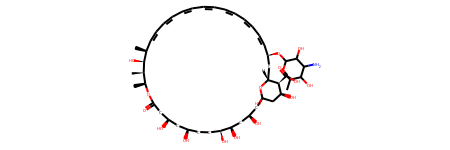

CC1OC(O[C@H]2/C=C/C=C/C=C/C=C/C=C/C=C/C=C/[C@H](C)[C@@H](O)[C@@H](C)[C@H](C)OC(=O)C[C@H](O)C[C@H](O)CC[C@@H](O)[C@H](O)C[C@H](O)C[C@]3(O)C[C@H](O)[C@@H](C(=O)O)[C@H](C2)O3)C(O)C(N)C1O


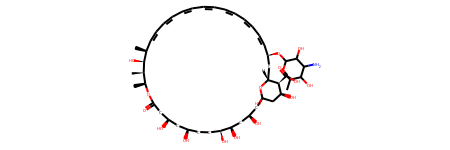

CC1OC(O[C@H]2/C=C/C=C/C=C/C=C/C=C/C=C/C=C/[C@H](C)[C@@H](O)[C@@H](C)[C@H](C)OC(=O)C[C@H](O)C[C@H](O)CC[C@@H](O)[C@H](O)C[C@H](O)C[C@]3(O)C[C@H](O)[C@@H](C(=O)O)[C@H](C2)O3)C(O)C(N)C1O


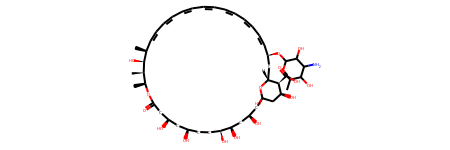

CC1OC(O[C@H]2/C=C/C=C/C=C/C=C/C=C/C=C/C=C/[C@H](C)[C@@H](O)[C@@H](C)[C@H](C)OC(=O)C[C@H](O)C[C@H](O)CC[C@@H](O)[C@H](O)C[C@H](O)C[C@]3(O)C[C@H](O)[C@@H](C(=O)O)[C@H](C2)O3)C(O)C(N)C1O


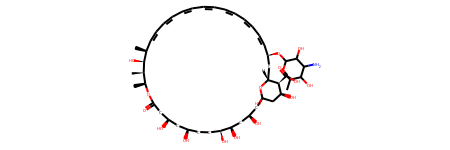

CC1OC(O[C@H]2/C=C/C=C/C=C/C=C/C=C/C=C/C=C/[C@H](C)[C@@H](O)[C@@H](C)[C@H](C)OC(=O)C[C@H](O)C[C@H](O)CC[C@@H](O)[C@H](O)C[C@H](O)C[C@]3(O)C[C@H](O)[C@@H](C(=O)O)[C@H](C2)O3)C(O)C(N)C1O


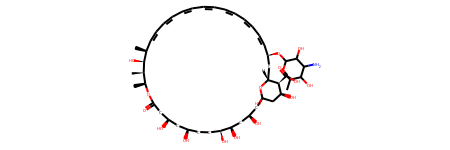

CC1OC(O[C@H]2/C=C/C=C/C=C/C=C/C=C/C=C/C=C/[C@H](C)[C@@H](O)[C@@H](C)[C@H](C)OC(=O)C[C@H](O)C[C@H](O)CC[C@@H](O)[C@H](O)C[C@H](O)C[C@]3(O)C[C@H](O)[C@@H](C(=O)O)[C@H](C2)O3)C(O)C(N)C1O


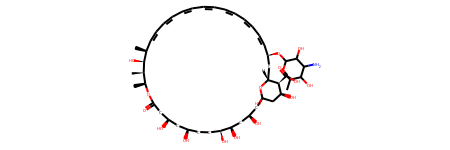

CC1OC(O[C@H]2/C=C/C=C/C=C/C=C/C=C/C=C/C=C/[C@H](C)[C@@H](O)[C@@H](C)[C@H](C)OC(=O)C[C@H](O)C[C@H](O)CC[C@@H](O)[C@H](O)C[C@H](O)C[C@]3(O)C[C@H](O)[C@@H](C(=O)O)[C@H](C2)O3)C(O)C(N)C1O


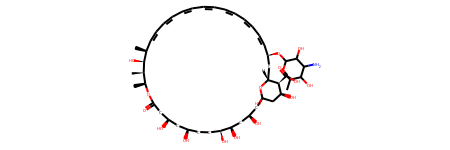

CC1OC(O[C@H]2/C=C/C=C/C=C/C=C/C=C/C=C/C=C/[C@H](C)[C@@H](O)[C@@H](C)[C@H](C)OC(=O)C[C@H](O)C[C@H](O)CC[C@@H](O)[C@H](O)C[C@H](O)C[C@]3(O)C[C@H](O)[C@@H](C(=O)O)[C@H](C2)O3)C(O)C(N)C1O


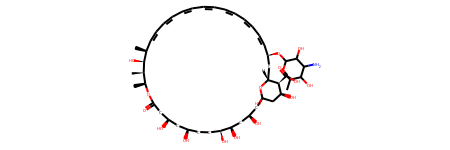

CN1CC[C@]23c4c5ccc(O)c4O[C@H]2[C@H](O[C@H]2OC(C(=O)O)[C@@H](O)[C@@H](O)C2O)C=C[C@H]3[C@H]1C5


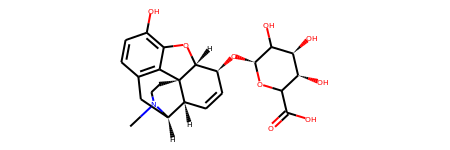

CN1CC[C@]23c4c5ccc(O)c4O[C@H]2[C@H](O[C@H]2OC(C(=O)O)[C@@H](O)[C@@H](O)C2O)C=C[C@H]3[C@H]1C5


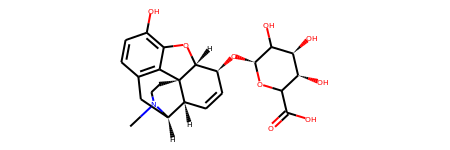

CN1CC[C@]23c4c5ccc(O)c4O[C@H]2[C@H](O[C@H]2OC(C(=O)O)[C@@H](O)[C@@H](O)C2O)C=C[C@H]3[C@H]1C5


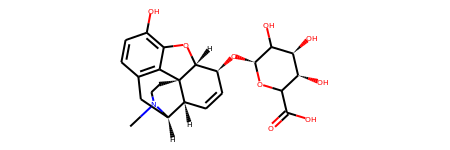

CC(C)n1c(/C=C/[C@H](O)C[C@H](O)CC(=O)O)c(-c2ccc(F)cc2)c2ccccc21


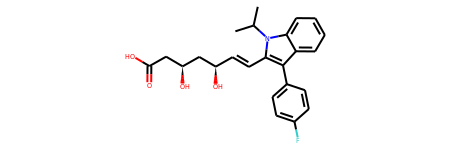

CC(C)n1c(/C=C/[C@H](O)C[C@H](O)CC(=O)O)c(-c2ccc(F)cc2)c2ccccc21


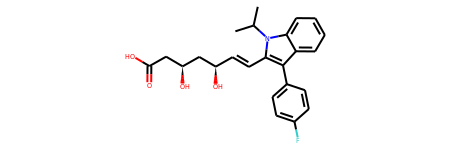

CN1CC[C@]23c4c5ccc(O)c4O[C@H]2[C@@H](O[C@H]2OC(C(=O)O)[C@H](O)[C@H](O)C2O)C=CC3[C@H]1C5


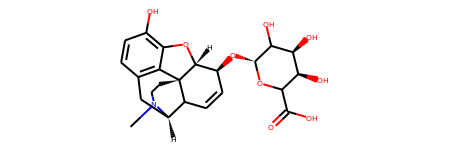

CN1CC[C@]23c4c5ccc(O)c4O[C@H]2[C@@H](O[C@H]2OC(C(=O)O)[C@H](O)[C@H](O)C2O)C=CC3[C@H]1C5


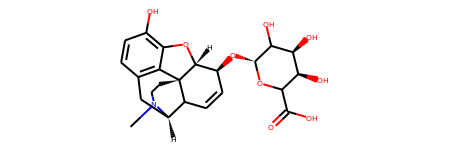

CN1CC[C@]23c4c5ccc(O)c4O[C@H]2[C@@H](O[C@H]2OC(C(=O)O)[C@H](O)[C@H](O)C2O)C=CC3[C@H]1C5


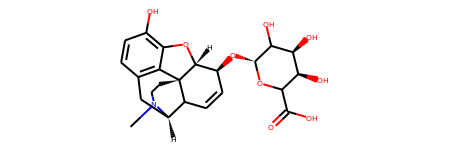

CN1CC[C@]23c4c5ccc(O[C@H]6OC(C(=O)O)[C@@H](O)[C@@H](O)C6O)c4O[C@@H]2[C@H](O)C=C[C@H]3[C@H]1C5


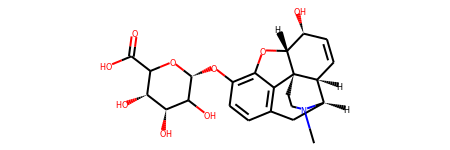

CN1CC[C@]23c4c5ccc(O[C@H]6OC(C(=O)O)[C@@H](O)[C@@H](O)C6O)c4O[C@@H]2[C@H](O)C=C[C@H]3[C@H]1C5


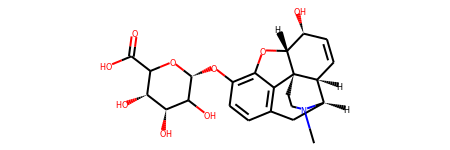

CN1CC[C@]23c4c5ccc(O[C@H]6OC(C(=O)O)[C@@H](O)[C@@H](O)C6O)c4O[C@@H]2[C@H](O)C=C[C@H]3[C@H]1C5


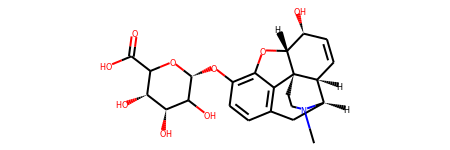

CN1CC[C@]23c4c5ccc(O[C@H]6OC(C(=O)O)[C@@H](O)[C@@H](O)C6O)c4O[C@@H]2[C@H](O)C=C[C@H]3[C@H]1C5


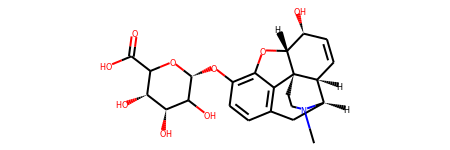

CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F)cc2)n1CC[C@@H](O)C[C@@H](O)CC(=O)O


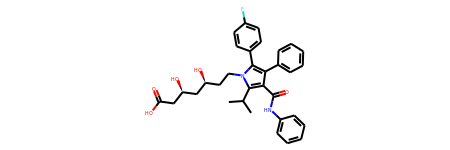

CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F)cc2)n1CC[C@@H](O)C[C@@H](O)CC(=O)O


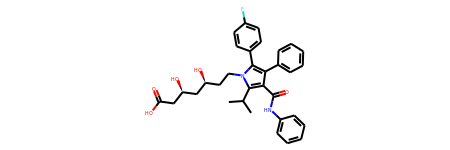

CN1CC[C@]23c4c5ccc(O[C@@H]6O[C@H](C(=O)O)[C@@H](O)[C@@H](O)C6O)c4O[C@H]2[C@@H](O)C=CC3[C@H]1C5


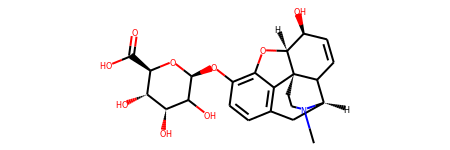

CN1CC[C@]23c4c5ccc(O[C@@H]6O[C@H](C(=O)O)[C@@H](O)[C@@H](O)C6O)c4O[C@H]2[C@@H](O)C=CC3[C@H]1C5


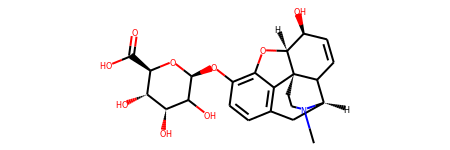

CN1CC[C@]23c4c5ccc(O[C@@H]6O[C@H](C(=O)O)[C@@H](O)[C@@H](O)C6O)c4O[C@H]2[C@@H](O)C=CC3[C@H]1C5


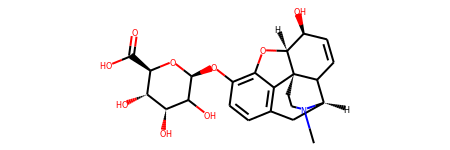

CN1CC[C@]23c4c5ccc(O[C@@H]6O[C@H](C(=O)O)[C@@H](O)[C@@H](O)C6O)c4O[C@H]2[C@@H](O)C=CC3[C@H]1C5


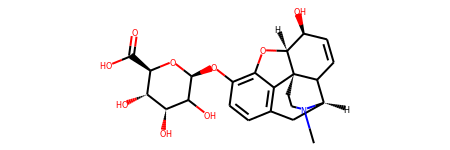

CCCCC[C@H](O)/C=C/[C@@H]1[C@@H](O)CC(=O)[C@H]1C/C=C/CCCC(=O)O


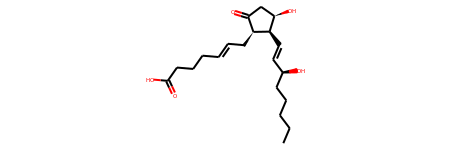

CCCCC[C@H](O)/C=C/[C@@H]1[C@@H](O)CC(=O)[C@H]1C/C=C/CCCC(=O)O


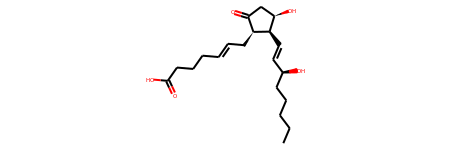

C[C@@H](O)C(=O)O


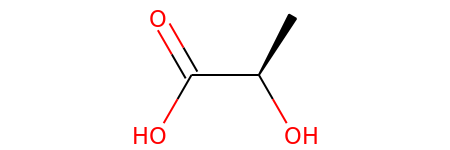

O=C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO


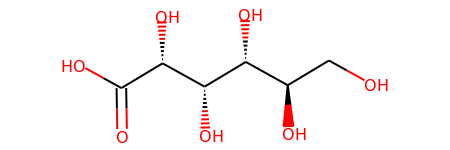

O=C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO


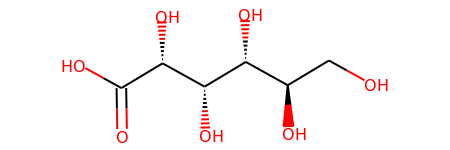

O=C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO


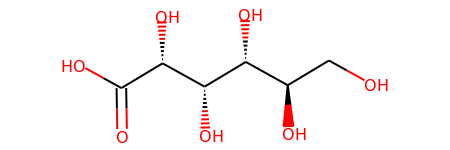

O=C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO


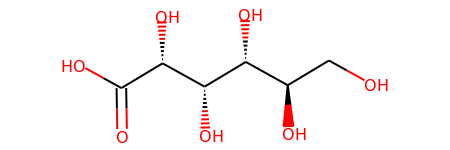

O=C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO


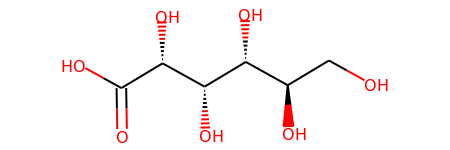

C[C@H](CCC(=O)O)C1CC[C@H]2C3[C@@H](O)C[C@@H]4C[C@H](O)CC[C@]4(C)[C@H]3CC[C@]12C


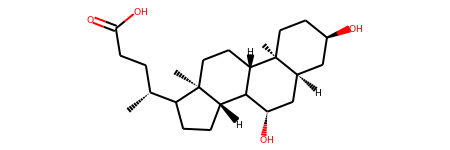

C[C@H](CCC(=O)O)C1CC[C@H]2C3[C@@H](O)C[C@@H]4C[C@H](O)CC[C@]4(C)[C@H]3CC[C@]12C


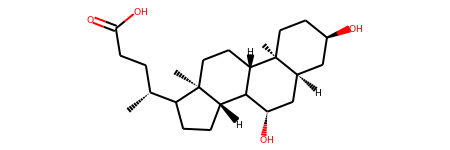

CCCCC[C@H](O)/C=C/[C@@H]1[C@@H](O)CC(=O)[C@H]1CCCCCCC(=O)O


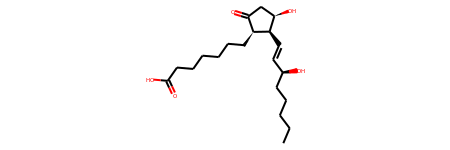

CCCCC[C@H](O)/C=C/[C@@H]1[C@@H](O)CC(=O)[C@H]1CCCCCCC(=O)O


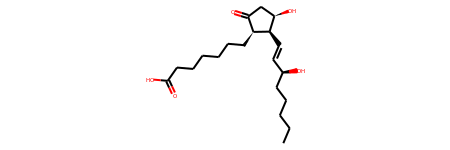

C[C@H](CCC(=O)O)C1CC[C@H]2C3[C@H](CC[C@]12C)[C@@]1(C)CC[C@@H](O)C[C@H]1C[C@H]3O


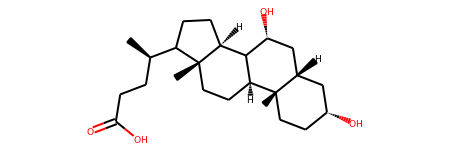

C[C@H](CCC(=O)O)C1CC[C@H]2C3[C@H](CC[C@]12C)[C@@]1(C)CC[C@@H](O)C[C@H]1C[C@H]3O


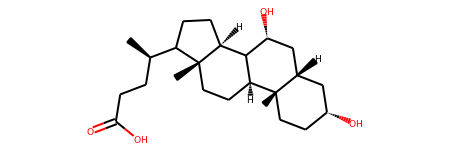

CC1(C)[C@H]2CC[C@@]1(C)[C@@H](O)[C@H]2C(=O)O


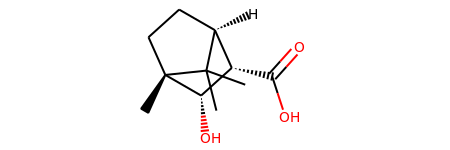

O=C(O)C(O)c1ccccc1


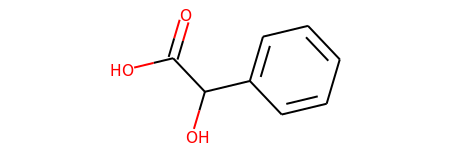

O=C(O)C12CCC(O)(CC1)CC2


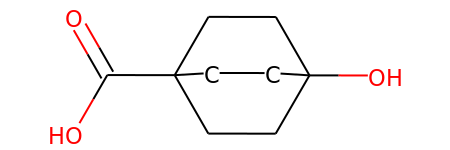

CC1(C)[C@H]2CC[C@@]1(C)[C@@H](O)[C@@H]2C(=O)O


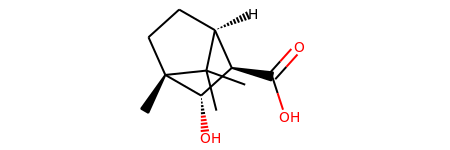

O=C(O)c1c[nH]c2cc(F)c(-c3ccc(C4(O)CCC4)cc3)c(F)c12


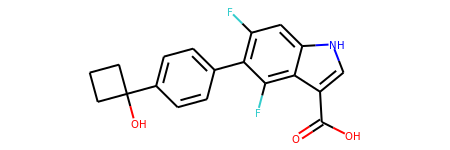

CC1CCC(O)(C(C(=O)O)c2ccc(-c3ccccc3)cc2)CC1


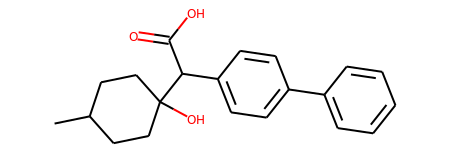

CC(C)C(O[C@H]1O[C@@H](C(=O)O)[C@H](O)[C@@H](O)[C@@H]1O)C(C)C


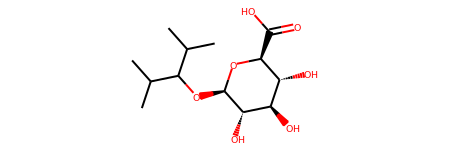

CC(C)C(O[C@H]1O[C@@H](C(=O)O)[C@H](O)[C@@H](O)[C@@H]1O)C(C)C


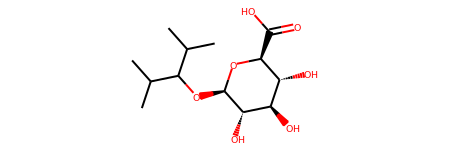

CC(C)C(O[C@H]1O[C@@H](C(=O)O)[C@H](O)[C@@H](O)[C@@H]1O)C(C)C


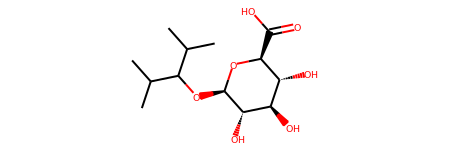

CCC(C)(O)C(C(=O)O)c1ccc(-c2ccccc2)cc1


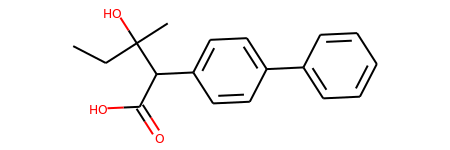

O=C(O)C1=C(CO)CC1


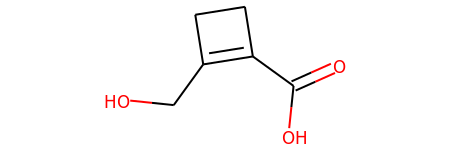

Cn1nnnc1SCC1CS[C@@H]2C(=NC(=O)[C@H](O)c3ccccc3)C(=O)N2C1C(=O)O


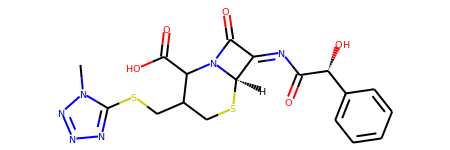

O=C(O)C(c1ccc(-c2ccccc2)cc1)C1(O)CCCCC1


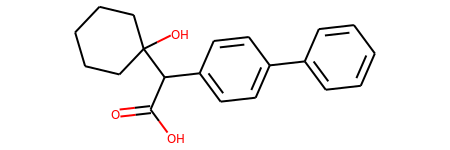

O=C(O)c1ccc(-c2ccc(Cl)c(O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]3O)c2)cc1


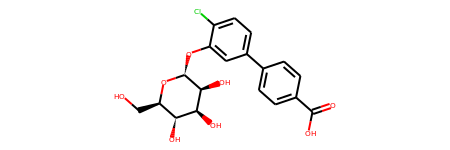

O=C(O)c1ccc(-c2ccc(Cl)c(O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]3O)c2)cc1


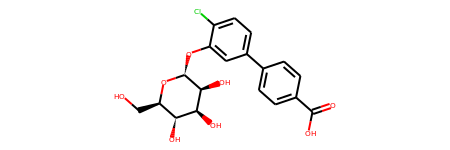

O=C(O)c1ccc(-c2ccc(Cl)c(O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]3O)c2)cc1


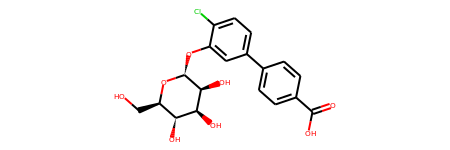

O=C(O)c1ccc(-c2ccc(Cl)c(O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]3O)c2)cc1


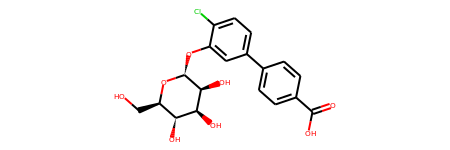

O=C(O)c1ccccc1O[C@H]1O[C@@H](CO)[C@H](O)[C@@H](O)[C@@H]1O


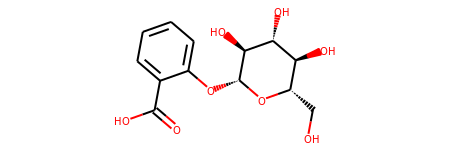

O=C(O)c1ccccc1O[C@H]1O[C@@H](CO)[C@H](O)[C@@H](O)[C@@H]1O


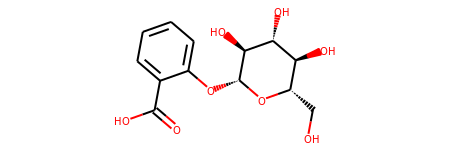

O=C(O)c1ccccc1O[C@H]1O[C@@H](CO)[C@H](O)[C@@H](O)[C@@H]1O


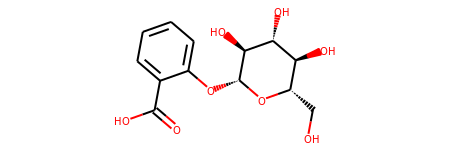

O=C(O)c1ccccc1O[C@H]1O[C@@H](CO)[C@H](O)[C@@H](O)[C@@H]1O


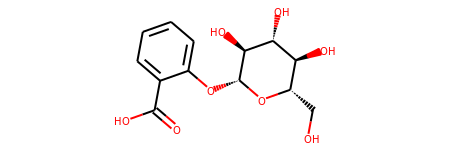

O=C(O)C(c1ccc(-c2ccccc2)cc1)C1(O)CCCC1


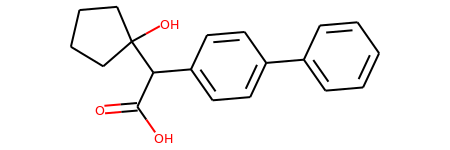

CC(O)(c1ccccc1)C(C(=O)O)c1ccc(-c2ccccc2)cc1


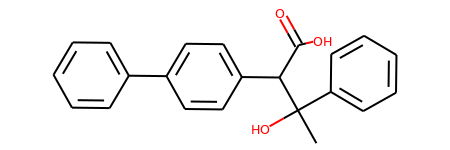

C[N+](C)(C)CC(O)CC(=O)O


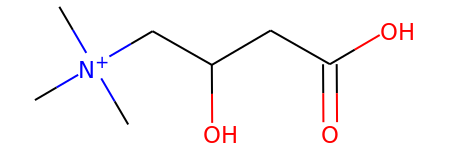

CC(C)(O)C(C(=O)O)c1ccc(C2CCCCC2)cc1


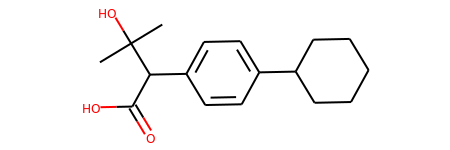

CC[C@H](C(=O)O)[C@@]1(O)C[C@H]2CC[C@@H]1C2


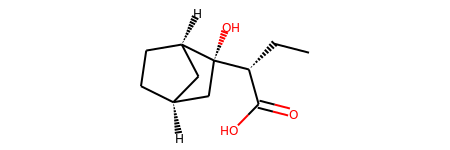

O=C(O)C1=C(CO)CCC1


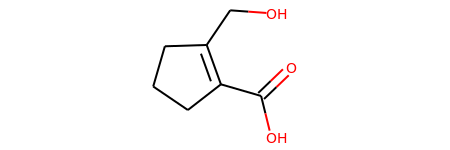

O=C(O)c1ccc(-c2cccc(O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]3O)c2)cc1


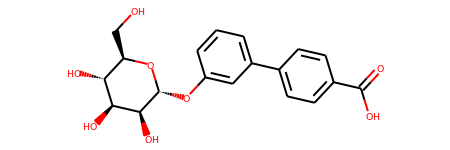

O=C(O)c1ccc(-c2cccc(O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]3O)c2)cc1


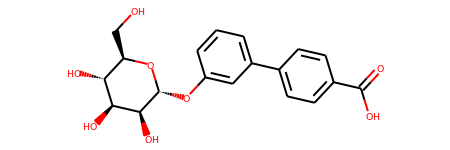

O=C(O)c1ccc(-c2cccc(O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]3O)c2)cc1


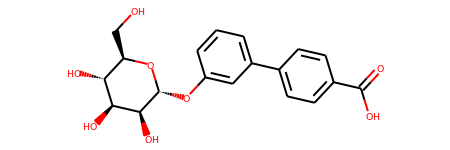

O=C(O)c1ccc(-c2cccc(O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]3O)c2)cc1


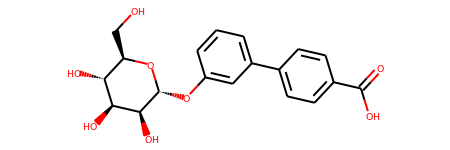

N#Cc1cc2[nH]cc(C(=O)O)c2cc1-c1ccc(C2(O)CCC2)cc1


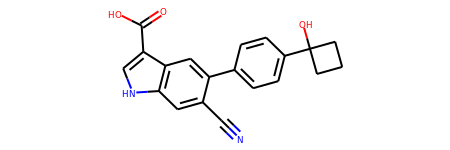

O=C(O)c1c[nH]c2cc(F)c(-c3ccc(C4(O)CCC4)cc3)cc12


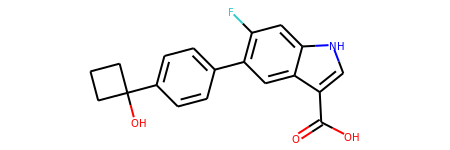

O=C(O)c1c[nH]c2cc(Cl)c(-c3ccc(OCCO)cc3)cc12


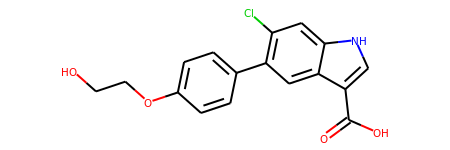

COc1ccc(C(=O)O[C@H]2O[C@@H](C(=O)O)[C@H](O)[C@@H](O)[C@@H]2O)cc1OC


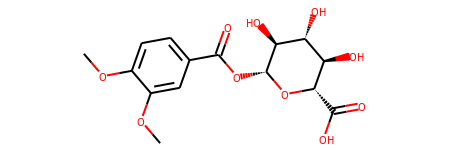

COc1ccc(C(=O)O[C@H]2O[C@@H](C(=O)O)[C@H](O)[C@@H](O)[C@@H]2O)cc1OC


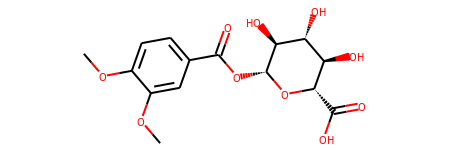

COc1ccc(C(=O)O[C@H]2O[C@@H](C(=O)O)[C@H](O)[C@@H](O)[C@@H]2O)cc1OC


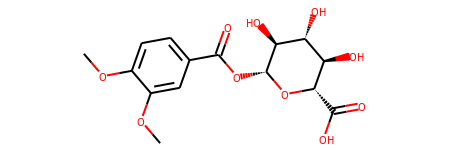

CC(C)(O)C(C(=O)O)c1ccc(-c2ccccc2)cc1


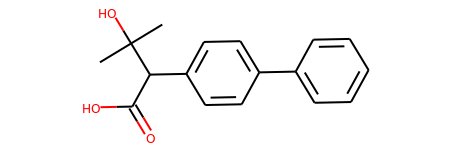

CO[C@H]1O[C@H](C(=O)O)[C@H](O)[C@H](O)[C@H]1O


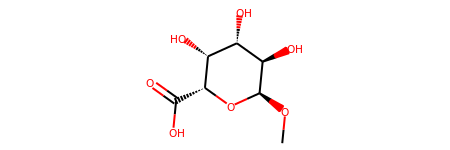

CO[C@H]1O[C@H](C(=O)O)[C@H](O)[C@H](O)[C@H]1O


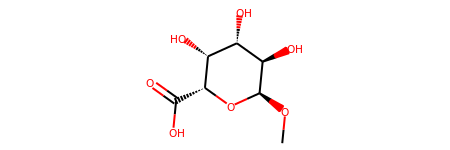

CO[C@H]1O[C@H](C(=O)O)[C@H](O)[C@H](O)[C@H]1O


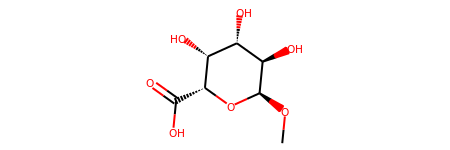

CC1CCc2c(N3CCC(O)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23


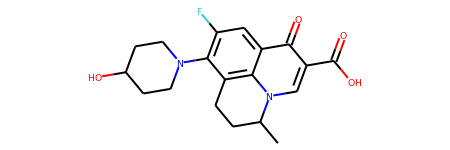

O=C(O)[C@@H]1O[C@H](Oc2ccc3[nH]ccc(=O)c3c2)[C@@H](O)[C@H](O)[C@H]1O


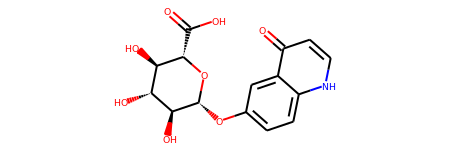

O=C(O)[C@@H]1O[C@H](Oc2ccc3[nH]ccc(=O)c3c2)[C@@H](O)[C@H](O)[C@H]1O


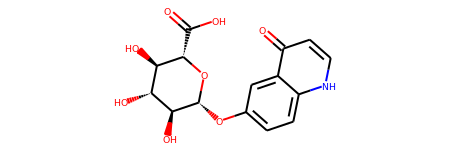

O=C(O)[C@@H]1O[C@H](Oc2ccc3[nH]ccc(=O)c3c2)[C@@H](O)[C@H](O)[C@H]1O


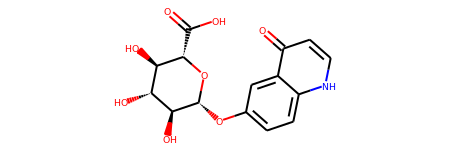

O=C(O)[C@@H]1O[C@H](Oc2ccc3[nH]c(=O)ccc3c2)[C@@H](O)[C@H](O)[C@H]1O


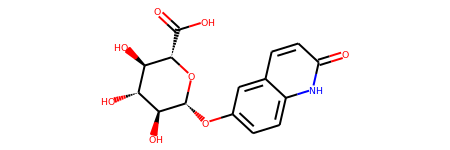

O=C(O)[C@@H]1O[C@H](Oc2ccc3[nH]c(=O)ccc3c2)[C@@H](O)[C@H](O)[C@H]1O


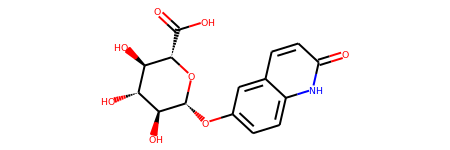

O=C(O)[C@@H]1O[C@H](Oc2ccc3[nH]c(=O)ccc3c2)[C@@H](O)[C@H](O)[C@H]1O


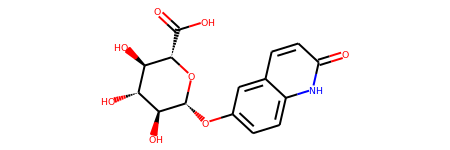

O=C(O)c1c[nH]c2cc(Cl)c(-c3ccc(C4(O)CCC4)cc3)cc12


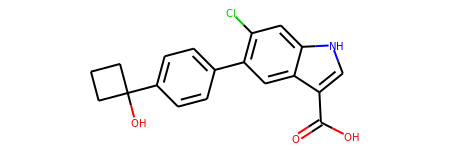

CC[C@@H](C(=O)O)[C@@]1(O)C[C@H]2CC[C@@H]1C2


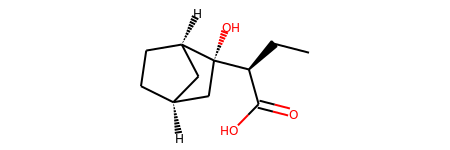

O=C(O)C[C@]1(O)C[C@H]2C=C[C@@H]1C2


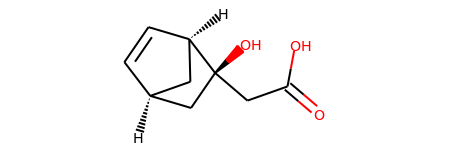

O=C(O)C[C@]1(O)C[C@@H]2C=C[C@H]1C2


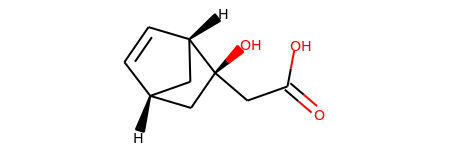

O=C(O)c1ccc(-c2ccc(O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]3O)cc2)cc1


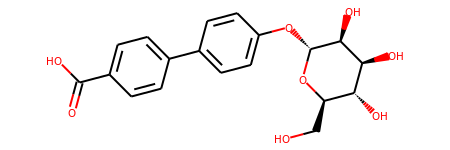

O=C(O)c1ccc(-c2ccc(O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]3O)cc2)cc1


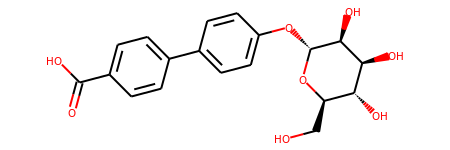

O=C(O)c1ccc(-c2ccc(O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]3O)cc2)cc1


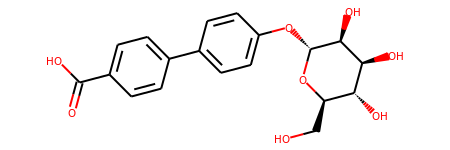

O=C(O)c1ccc(-c2ccc(O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]3O)cc2)cc1


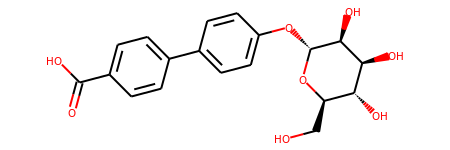

O=C(O)C[C@]1(O)C[C@@H]2CC[C@H]1C2


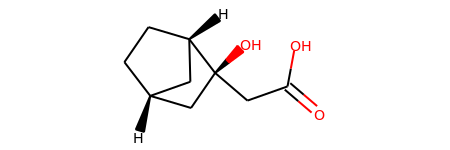

CCCCCC(O)CCC1CCC(=O)N1CCCCCCC(=O)O


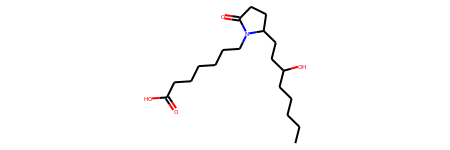

CC(C)n1c(/C=C/[C@@H](O)C[C@@H](O)CC(=O)O)c(-c2ccc(F)cc2)c2ccccc21


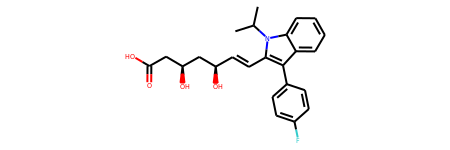

CC(C)n1c(/C=C/[C@@H](O)C[C@@H](O)CC(=O)O)c(-c2ccc(F)cc2)c2ccccc21


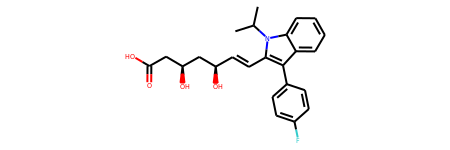

CCC(CC)C(=O)O[C@H]1O[C@@H](C(=O)O)[C@H](O)[C@@H](O)[C@@H]1O


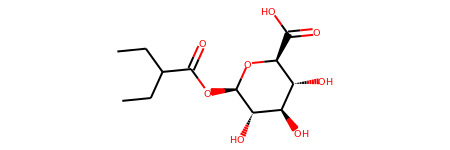

CCC(CC)C(=O)O[C@H]1O[C@@H](C(=O)O)[C@H](O)[C@@H](O)[C@@H]1O


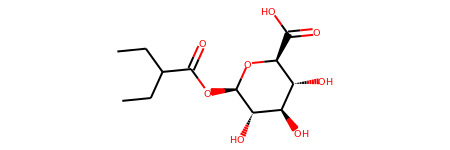

CCC(CC)C(=O)O[C@H]1O[C@@H](C(=O)O)[C@H](O)[C@@H](O)[C@@H]1O


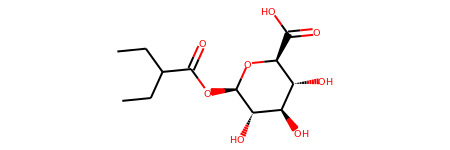

O=C(O)c1ccc(-c2ccc(O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]3O)cc2Cl)cc1


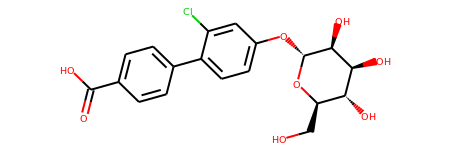

O=C(O)c1ccc(-c2ccc(O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]3O)cc2Cl)cc1


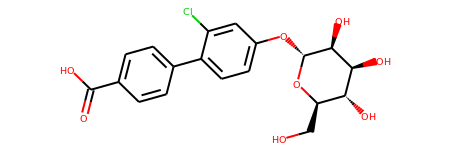

O=C(O)c1ccc(-c2ccc(O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]3O)cc2Cl)cc1


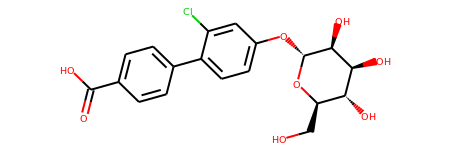

O=C(O)c1ccc(-c2ccc(O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]3O)cc2Cl)cc1


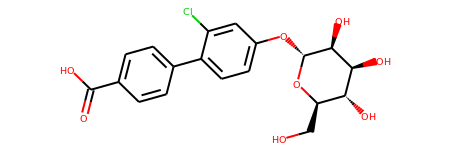

O=C(O)C(c1ccc(-c2ccccc2)cc1)C(O)c1ccccc1


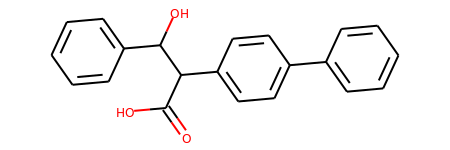

Cc1ccc(C(O)C(C(=O)O)c2ccc(-c3ccccc3)cc2)cc1


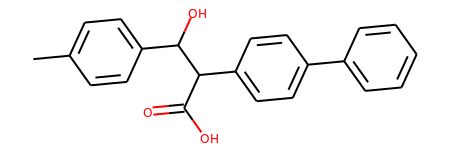

O=C(O)c1ccc(-c2ccc(O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]3O)c(Cl)c2)cc1


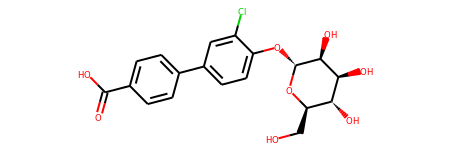

O=C(O)c1ccc(-c2ccc(O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]3O)c(Cl)c2)cc1


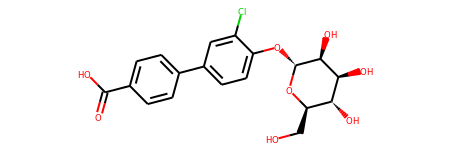

O=C(O)c1ccc(-c2ccc(O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]3O)c(Cl)c2)cc1


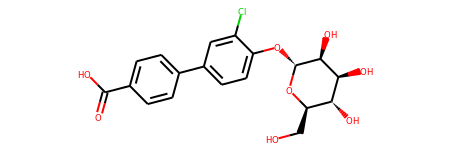

O=C(O)c1ccc(-c2ccc(O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]3O)c(Cl)c2)cc1


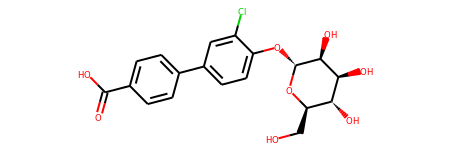

O=C(O)C1(O)CCC1


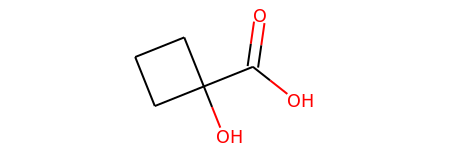

O=C(O)c1ccccc1CO


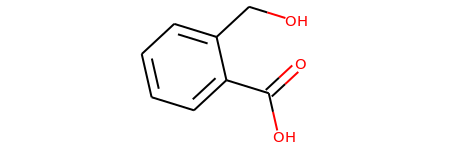

C[C@]12CC[C@@H]3C(=O)O[C@@H](C(=O)O)C[C@]3(C)[C@H]1[C@H]1CCC2(O)C(=O)O1


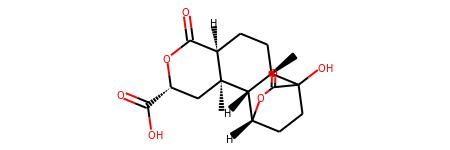

CC(O)CC(=O)O


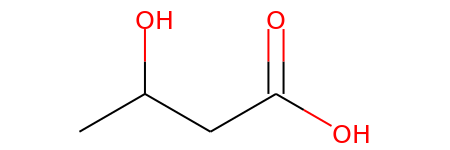

O=C(O)[C@@H]1O[C@H](Oc2ccc(I)cc2)[C@@H](O)[C@H](O)[C@H]1O


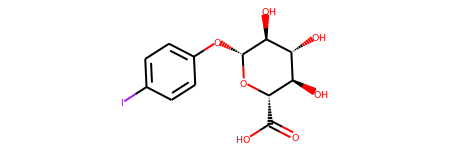

O=C(O)[C@@H]1O[C@H](Oc2ccc(I)cc2)[C@@H](O)[C@H](O)[C@H]1O


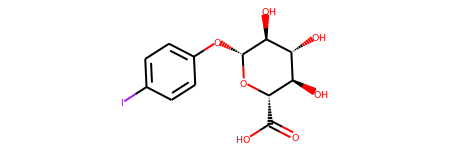

O=C(O)[C@@H]1O[C@H](Oc2ccc(I)cc2)[C@@H](O)[C@H](O)[C@H]1O


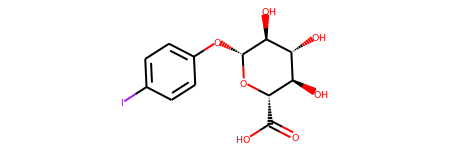

O=C(O)C[C@]1(O)C[C@H]2CC[C@@H]1C2


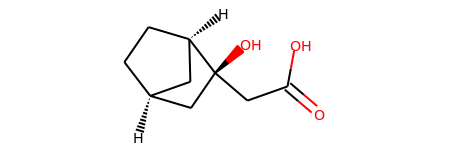

CC(C)n1c(/C=C/C(O)CC(O)CC(=O)O)c(-c2ccc(F)cc2)c2ccccc21


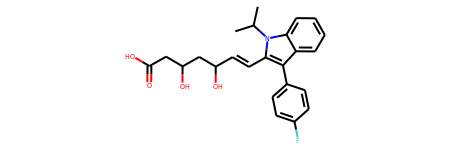

CC(C)n1c(/C=C/C(O)CC(O)CC(=O)O)c(-c2ccc(F)cc2)c2ccccc21


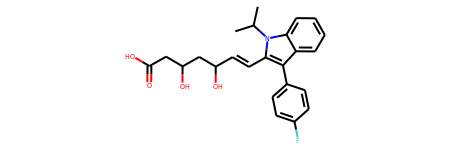

O=C(O)[C@H]1CCC[C@H](O)C1


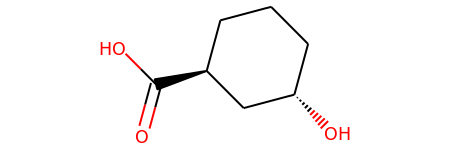

N#Cc1ccc(O[C@H]2O[C@@H](C(=O)O)[C@H](O)[C@@H](O)[C@@H]2O)cc1


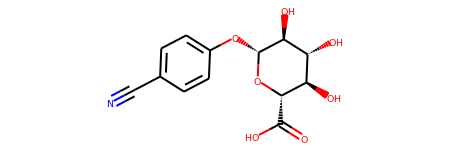

N#Cc1ccc(O[C@H]2O[C@@H](C(=O)O)[C@H](O)[C@@H](O)[C@@H]2O)cc1


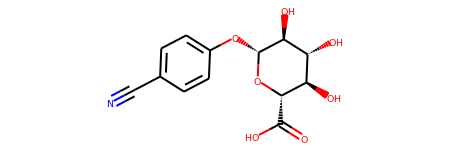

N#Cc1ccc(O[C@H]2O[C@@H](C(=O)O)[C@H](O)[C@@H](O)[C@@H]2O)cc1


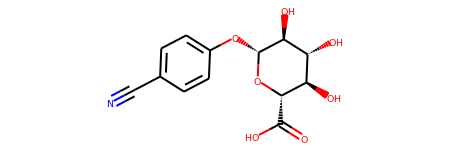

O=C(O)[C@H]1CC[C@@H](O)CC1


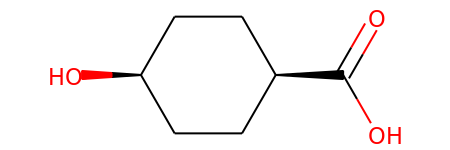

O=C(O)C(CO)c1ccccc1


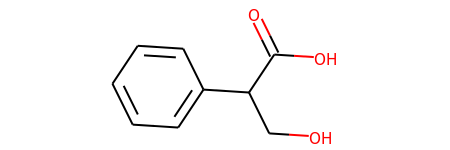

Cc1ccccc1C(O)C(C(=O)O)c1ccc(-c2ccccc2)cc1


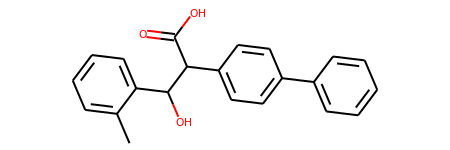

O=C(O)[C@@H]1CCCC[C@@H]1O


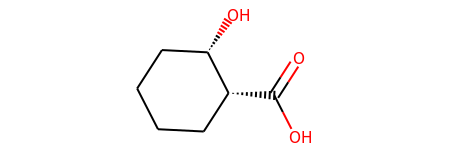

COc1cc(C)c(C(=O)O)cc1-c1ccc(C#CCO)s1


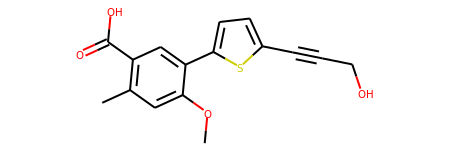

Cc1cc(=O)oc2cc(O[C@@H]3O[C@H](C(=O)O)[C@@H](O)[C@H](O)[C@H]3O)ccc12


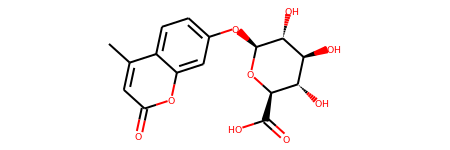

Cc1cc(=O)oc2cc(O[C@@H]3O[C@H](C(=O)O)[C@@H](O)[C@H](O)[C@H]3O)ccc12


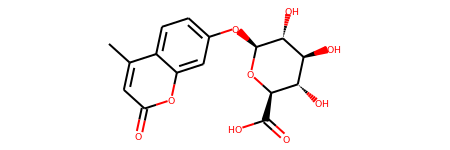

Cc1cc(=O)oc2cc(O[C@@H]3O[C@H](C(=O)O)[C@@H](O)[C@H](O)[C@H]3O)ccc12


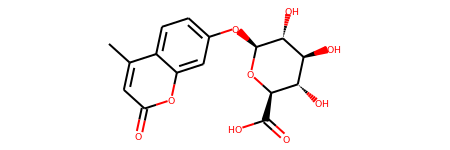

CCCC(O)C(C(=O)O)c1ccc(-c2ccccc2)cc1


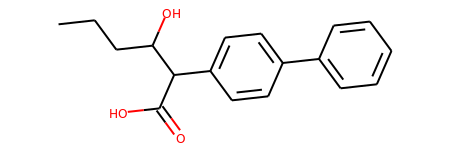

Cc1cccc(C(O)C(C(=O)O)c2ccc(-c3ccccc3)cc2)c1


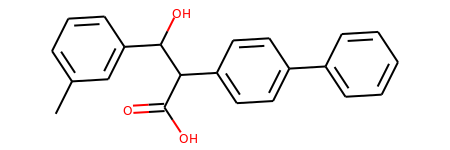

CC(C1CC[C@H]2[C@@H]3[C@@H](O)CC4C[C@H](O)CCC4(C)[C@H]3CCC12C)[C@H]1C[C@H]1C(=O)O


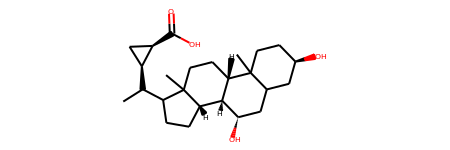

CC(C1CC[C@H]2[C@@H]3[C@@H](O)CC4C[C@H](O)CCC4(C)[C@H]3CCC12C)[C@H]1C[C@H]1C(=O)O


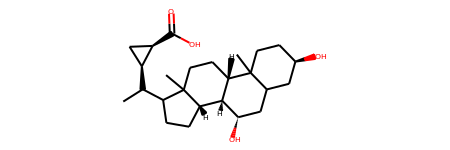

CC1(C)[C@@H]2CC[C@](C(=O)O)(C2)[C@@H]1O


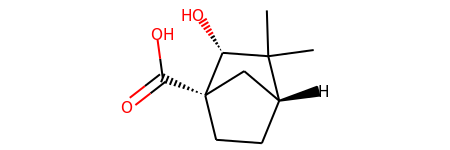

C[C@H]([C@H]1C[C@H]1C(=O)O)[C@H]1CC[C@H]2[C@@H]3[C@@H](O)CC4C[C@H](O)CC[C@]4(C)[C@H]3CC[C@@]21C


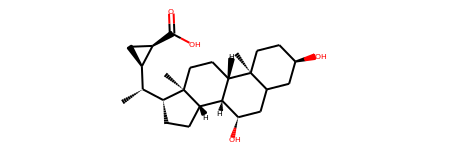

C[C@H]([C@H]1C[C@H]1C(=O)O)[C@H]1CC[C@H]2[C@@H]3[C@@H](O)CC4C[C@H](O)CC[C@]4(C)[C@H]3CC[C@@]21C


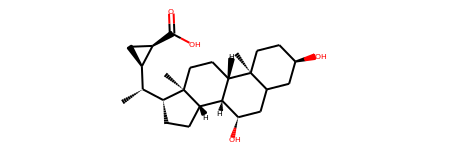

CC(C1CC[C@H]2[C@@H]3[C@@H](O)CC4C[C@H](O)CCC4(C)[C@H]3CCC12C)[C@@H]1C[C@@H]1C(=O)O


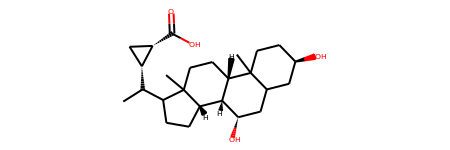

CC(C1CC[C@H]2[C@@H]3[C@@H](O)CC4C[C@H](O)CCC4(C)[C@H]3CCC12C)[C@@H]1C[C@@H]1C(=O)O


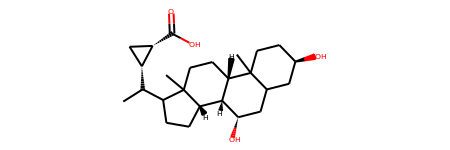

O=C(O)C(c1ccc(-c2ccccc2)cc1)C(O)Cc1ccccc1


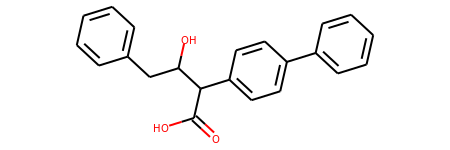

O=C(O[C@H]1O[C@@H](C(=O)O)[C@H](O)[C@@H](O)[C@@H]1O)c1ccccc1


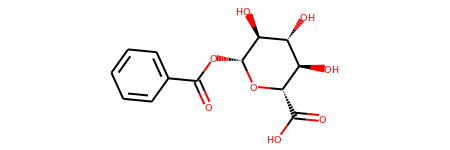

O=C(O[C@H]1O[C@@H](C(=O)O)[C@H](O)[C@@H](O)[C@@H]1O)c1ccccc1


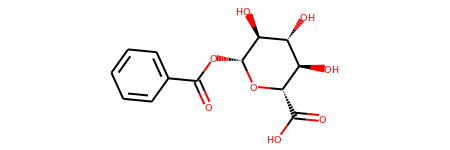

O=C(O[C@H]1O[C@@H](C(=O)O)[C@H](O)[C@@H](O)[C@@H]1O)c1ccccc1


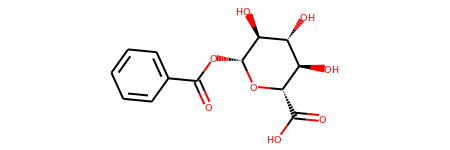

C[C@H]([C@@H]1C[C@@H]1C(=O)O)[C@H]1CC[C@H]2[C@@H]3[C@@H](O)CC4C[C@H](O)CC[C@]4(C)[C@H]3CC[C@@]21C


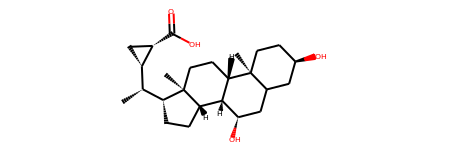

C[C@H]([C@@H]1C[C@@H]1C(=O)O)[C@H]1CC[C@H]2[C@@H]3[C@@H](O)CC4C[C@H](O)CC[C@]4(C)[C@H]3CC[C@@]21C


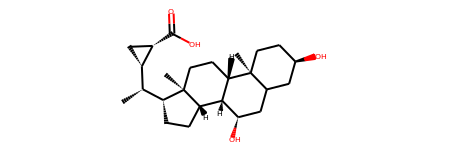

C[C@H](C1CC1C(=O)O)[C@H]1CC[C@H]2[C@@H]3[C@@H](O)C[C@@H]4C[C@H](O)CC[C@]4(C)[C@H]3CC[C@@]21C


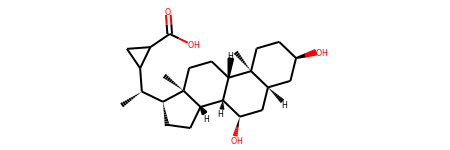

C[C@H](C1CC1C(=O)O)[C@H]1CC[C@H]2[C@@H]3[C@@H](O)C[C@@H]4C[C@H](O)CC[C@]4(C)[C@H]3CC[C@@]21C


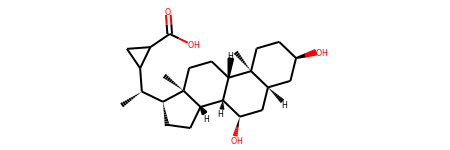

CC(C1CC1C(=O)O)C1CC[C@H]2[C@@H]3[C@@H](O)CC4C[C@H](O)CCC4(C)[C@H]3CCC12C


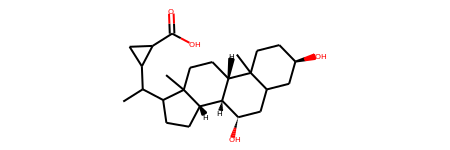

CC(C1CC1C(=O)O)C1CC[C@H]2[C@@H]3[C@@H](O)CC4C[C@H](O)CCC4(C)[C@H]3CCC12C


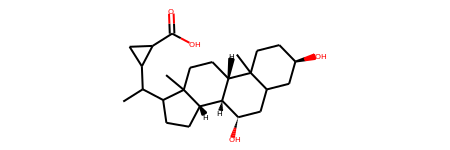

C[C@@H]1[C@H]2C3=CC[C@@H]4[C@@]5(C)CC[C@H](O)C(C)(C)[C@@H]5CC[C@@]4(C)[C@]3(C)CC[C@@]2(C(=O)O)CC[C@H]1C


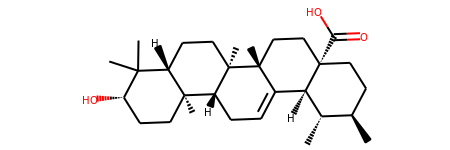

O=C(O)C(c1ccc(C2CCCCC2)cc1)C(O)c1ccccc1


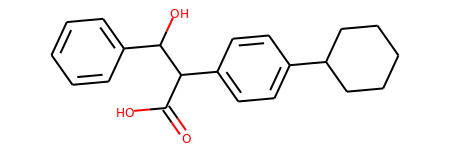

CC(O)C(C(=O)O)c1ccc(C2CCCCC2)cc1


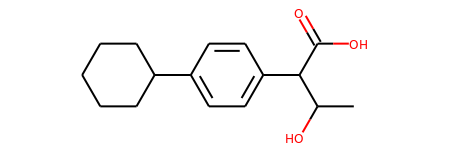

COc1ccc(C(=O)O)cc1-c1ccc(C#CCO)s1


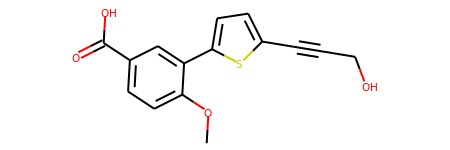

O=C(O)CC(O)c1ccccc1


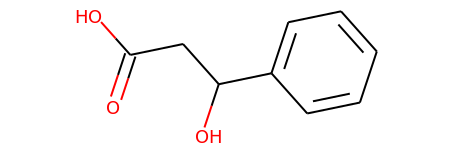

O=C(O)C1(O)CCCCCC1


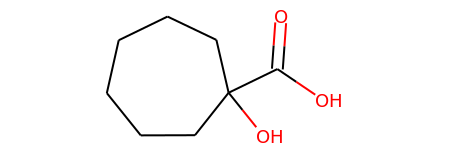

Cc1c(Cc2ccccc2C(O)c2ccccc2)c2c(n1CC(=O)O)CCNC2=O


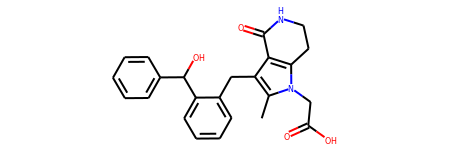

CCCCC[C@H](O)CC[C@@H]1[C@H]2Cc3cccc(OCC(=O)O)c3C[C@H]2C[C@H]1O


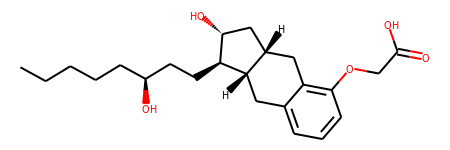

CCCCC[C@H](O)CC[C@@H]1[C@H]2Cc3cccc(OCC(=O)O)c3C[C@H]2C[C@H]1O


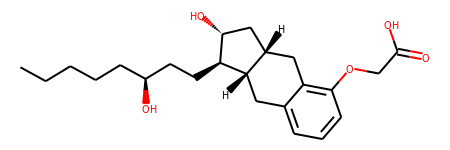

C#CC#CC#CCC(O)CCC(=O)O


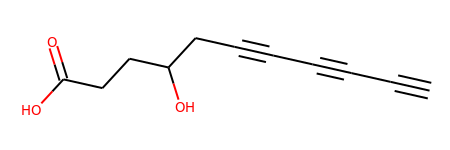

CC(O)C(C(=O)O)c1ccc(-c2ccccc2)cc1


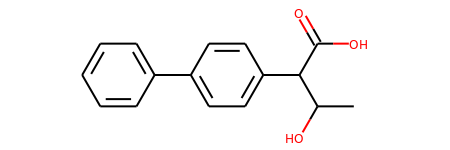

O=C(O)CC[C@H]1CC[C@H](O)CC1


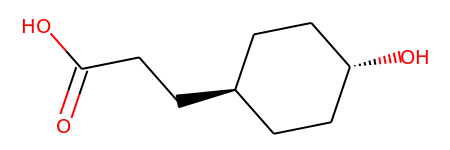

O=C(O)[C@@H]1O[C@H](Oc2ccc(-c3ccccc3)cc2)[C@@H](O)[C@H](O)[C@H]1O


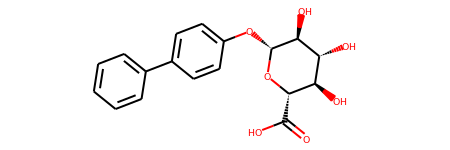

O=C(O)[C@@H]1O[C@H](Oc2ccc(-c3ccccc3)cc2)[C@@H](O)[C@H](O)[C@H]1O


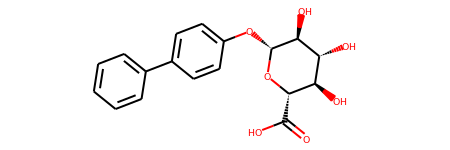

O=C(O)[C@@H]1O[C@H](Oc2ccc(-c3ccccc3)cc2)[C@@H](O)[C@H](O)[C@H]1O


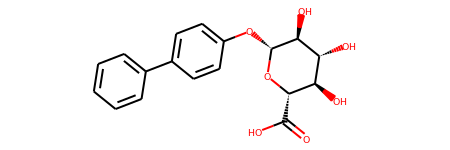

C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@@H]3[C@@H](O)C[C@@H]4C[C@H](O)CC[C@]4(C)[C@H]3CC[C@@]21C


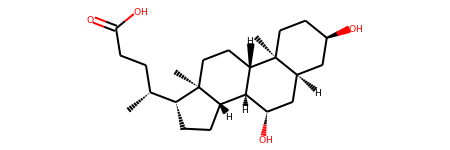

C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@@H]3[C@@H](O)C[C@@H]4C[C@H](O)CC[C@]4(C)[C@H]3CC[C@@]21C


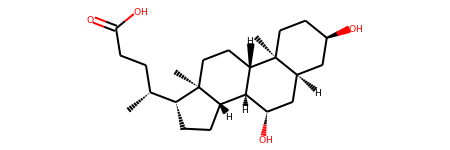

CC(O)[C@@H]1C[C@H](CC(=O)O)C1(C)C


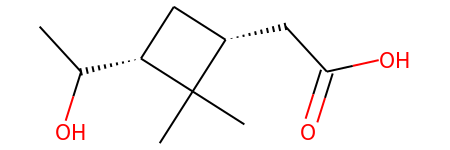

CCCC(C(CC)CO)C(CC)C(=O)O


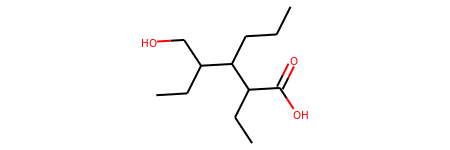

CC(C)C(O)C(C(=O)O)c1ccc(-c2ccccc2)cc1


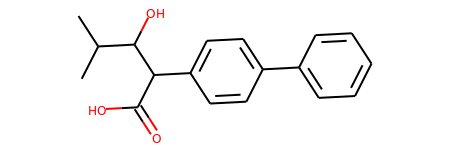

Cc1ccc(C(O)C(C(=O)O)c2ccc(C3CCCCC3)cc2)cc1


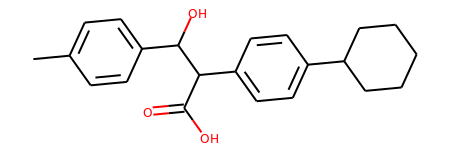

O=C(O)C1(O)c2ccccc2-c2ccccc21


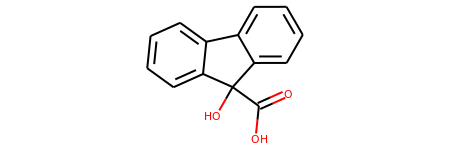

O=C(O)[C@H]1CC[C@H](O)CC1


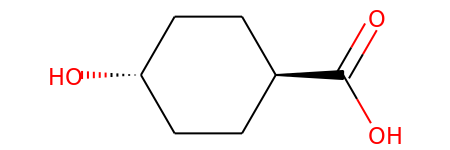

CCC(O)C(C(=O)O)c1ccc(-c2ccccc2)cc1


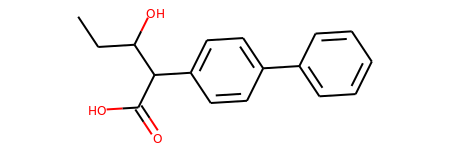

O=C(O)c1ccc(CO)cc1


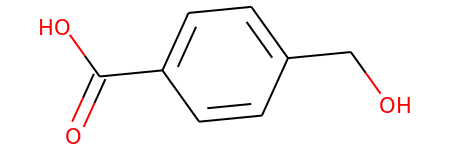

O=C(O)C(c1ccc(-c2ccccc2)cc1)C(O)C1CCCCC1


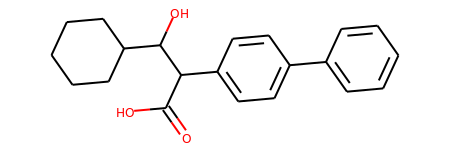

CC1(C)[C@H](O)[C@]2(C(=O)O)CC[C@@H]1C2


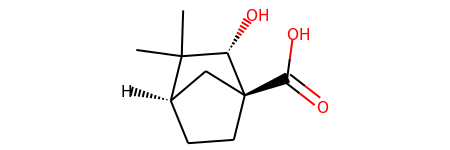

CC(O)C(=O)O


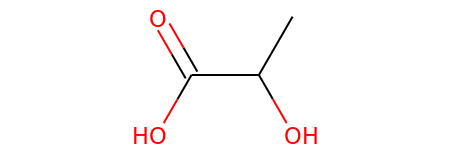

CC(O)(C(=O)O)c1ccccc1


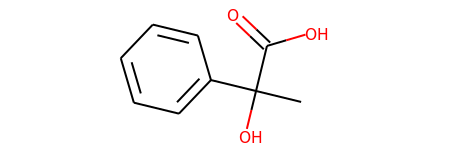

O=C(O)C1(O)CCCCC1


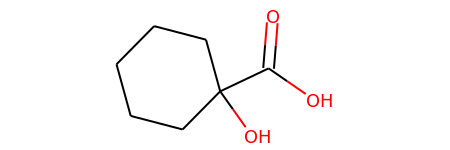

O=C(O)C1(O)CCCC1


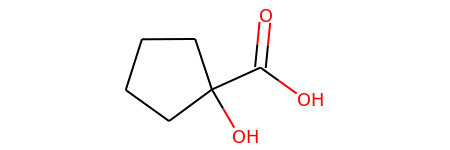

CCCCC(CC)C(=O)O[C@H]1O[C@@H](C(=O)O)[C@H](O)[C@@H](O)[C@@H]1O


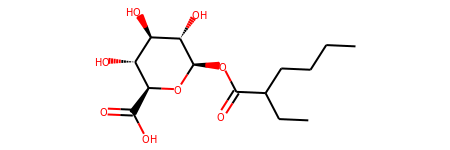

CCCCC(CC)C(=O)O[C@H]1O[C@@H](C(=O)O)[C@H](O)[C@@H](O)[C@@H]1O


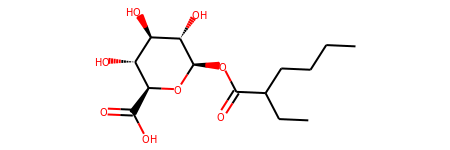

CCCCC(CC)C(=O)O[C@H]1O[C@@H](C(=O)O)[C@H](O)[C@@H](O)[C@@H]1O


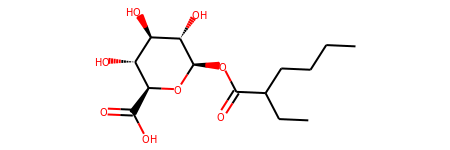

O=C(O)[C@@H]1CCC[C@H](O)C1


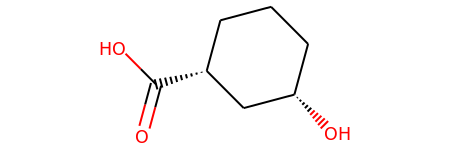

O=C(O)[C@@H]1O[C@H](Oc2ccc(Br)cc2)[C@@H](O)[C@H](O)[C@H]1O


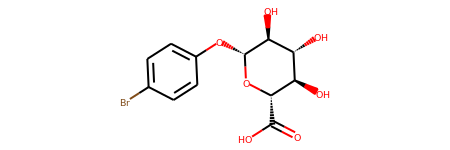

O=C(O)[C@@H]1O[C@H](Oc2ccc(Br)cc2)[C@@H](O)[C@H](O)[C@H]1O


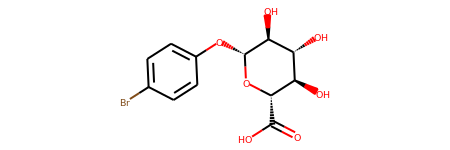

O=C(O)[C@@H]1O[C@H](Oc2ccc(Br)cc2)[C@@H](O)[C@H](O)[C@H]1O


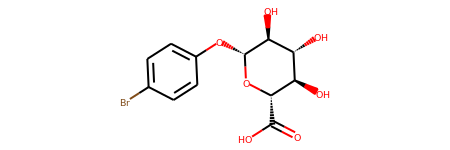

NNC(=O)CC(NCCO)C(=O)O


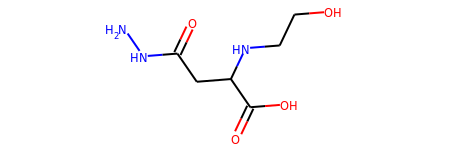

NC(=O)C(N)C(O)C(=O)O


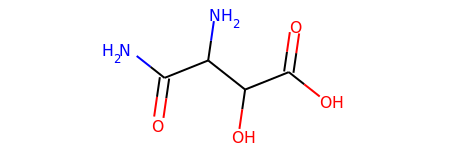

O=C(O)C1CC(O)CN1


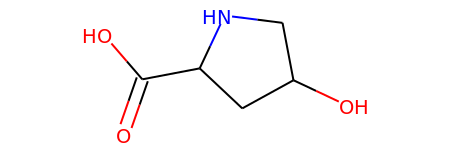

COC(=O)CC1C(C(=O)O)NCC1C(C)O


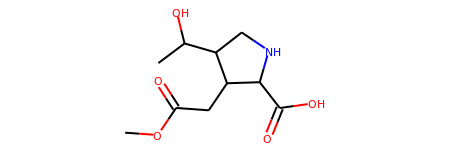

CC1(C)C2CCC1(C)C(O)C2C(=O)O


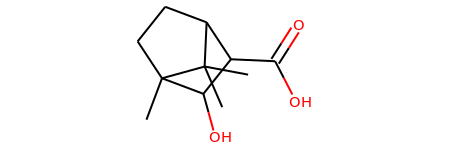

Nc1c(C(=O)O)ncn1C1OC(CO)C(O)C1O


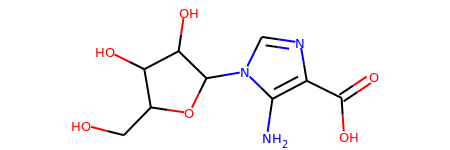

Nc1c(C(=O)O)ncn1C1OC(CO)C(O)C1O


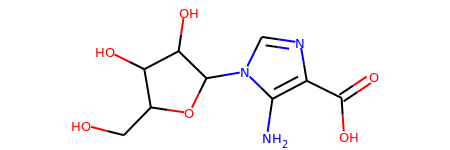

Nc1c(C(=O)O)ncn1C1OC(CO)C(O)C1O


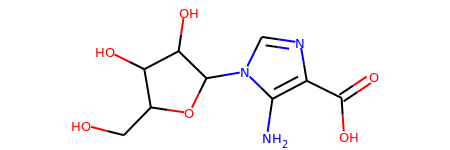

O=C(O)C1OC(Oc2ccc3oc4cccc(O)c4c(=O)c3c2)C(O)C(O)C1O


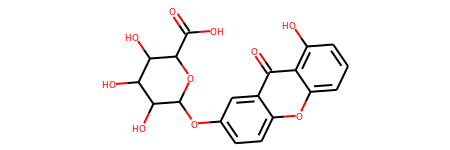

O=C(O)C1OC(Oc2ccc3oc4cccc(O)c4c(=O)c3c2)C(O)C(O)C1O


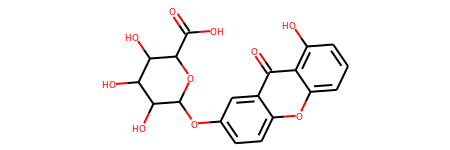

O=C(O)C1OC(Oc2ccc3oc4cccc(O)c4c(=O)c3c2)C(O)C(O)C1O


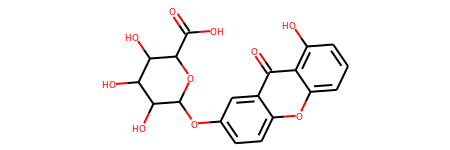

CC(C)C(OC1OC(C(=O)O)C(O)C(O)C1O)C(C)C


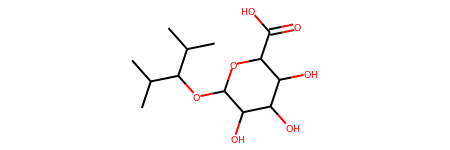

CC(C)C(OC1OC(C(=O)O)C(O)C(O)C1O)C(C)C


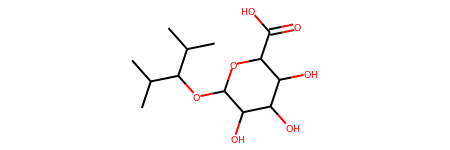

CC(C)C(OC1OC(C(=O)O)C(O)C(O)C1O)C(C)C


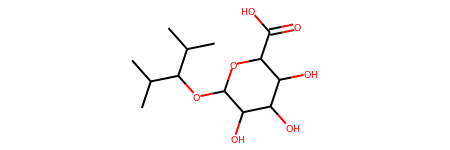

O=C(O)c1ccccc1OC1OC(CO)C(O)C(O)C1O


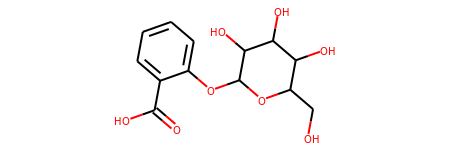

O=C(O)c1ccccc1OC1OC(CO)C(O)C(O)C1O


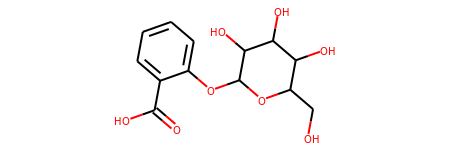

O=C(O)c1ccccc1OC1OC(CO)C(O)C(O)C1O


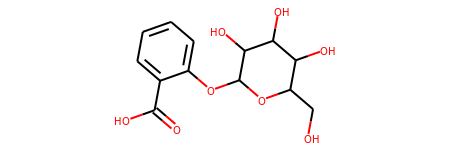

O=C(O)c1ccccc1OC1OC(CO)C(O)C(O)C1O


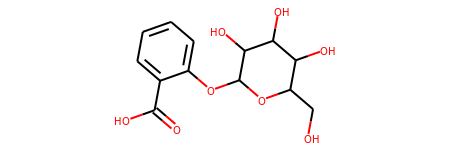

CN1CC(C(=O)O)CC2(O)c3cccc4[nH]cc(c34)CC12


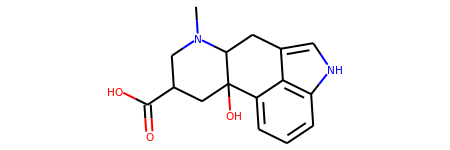

CCC(C(=O)O)C1(O)CC2CCC1C2


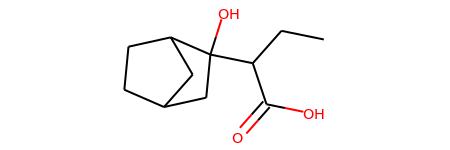

COc1ccc(C(=O)OC2OC(C(=O)O)C(O)C(O)C2O)cc1OC


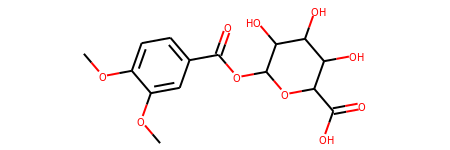

COc1ccc(C(=O)OC2OC(C(=O)O)C(O)C(O)C2O)cc1OC


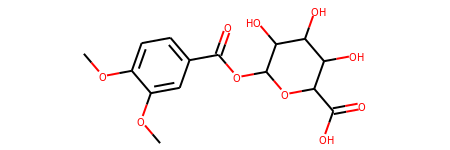

COc1ccc(C(=O)OC2OC(C(=O)O)C(O)C(O)C2O)cc1OC


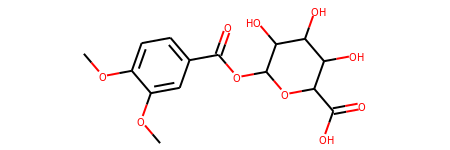

COC1OC(C(=O)O)C(O)C(O)C1O


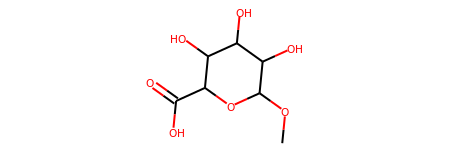

COC1OC(C(=O)O)C(O)C(O)C1O


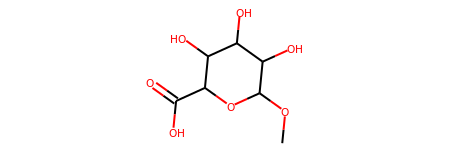

COC1OC(C(=O)O)C(O)C(O)C1O


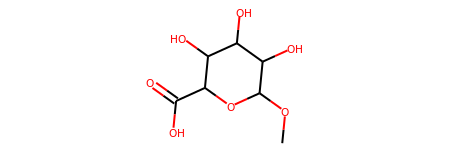

O=C(O)C1OC(Oc2ccc3nccc(O)c3c2)C(O)C(O)C1O


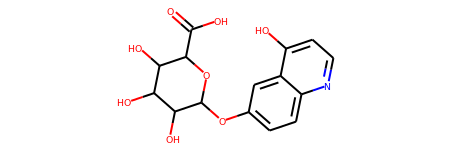

O=C(O)C1OC(Oc2ccc3nccc(O)c3c2)C(O)C(O)C1O


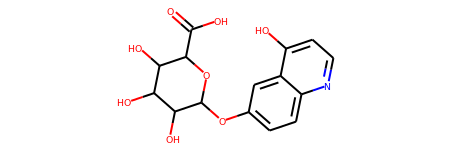

O=C(O)C1OC(Oc2ccc3nccc(O)c3c2)C(O)C(O)C1O


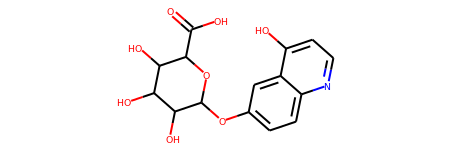

O=C(O)C1OC(Oc2ccc3nc(O)ccc3c2)C(O)C(O)C1O


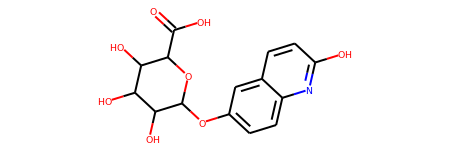

O=C(O)C1OC(Oc2ccc3nc(O)ccc3c2)C(O)C(O)C1O


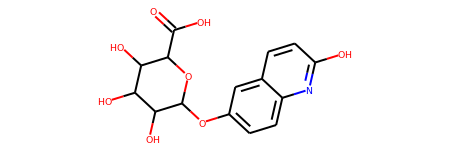

O=C(O)C1OC(Oc2ccc3nc(O)ccc3c2)C(O)C(O)C1O


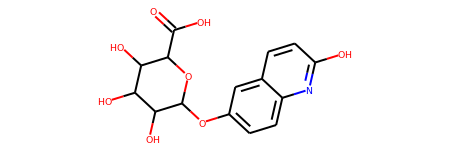

O=C(O)CC1(O)CC2C=CC1C2


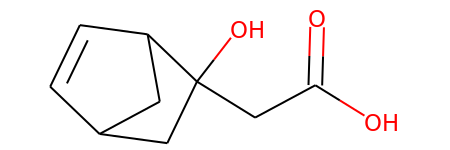

CC1NC(CCCCCCCC(=O)O)CCC1O


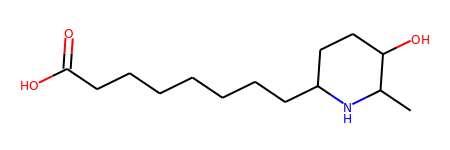

CCC(CC)C(=O)OC1OC(C(=O)O)C(O)C(O)C1O


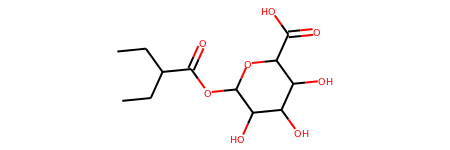

CCC(CC)C(=O)OC1OC(C(=O)O)C(O)C(O)C1O


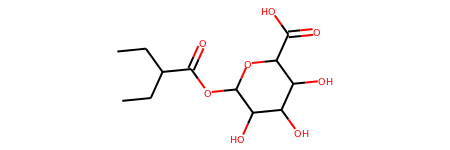

CCC(CC)C(=O)OC1OC(C(=O)O)C(O)C(O)C1O


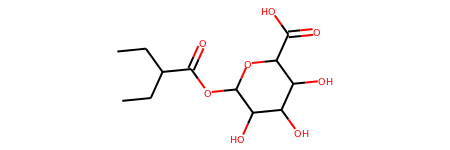

O=C(O)CC1(O)CC2CCC1C2


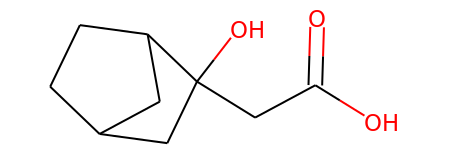

Nc1ccccc1OC1OC(C(=O)O)C(O)C(O)C1O


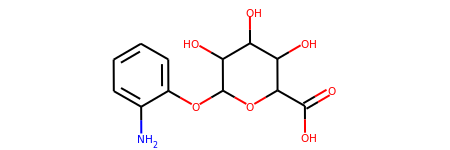

Nc1ccccc1OC1OC(C(=O)O)C(O)C(O)C1O


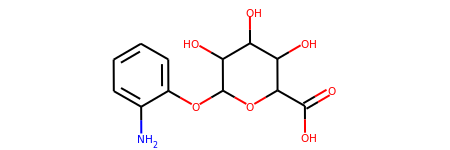

Nc1ccccc1OC1OC(C(=O)O)C(O)C(O)C1O


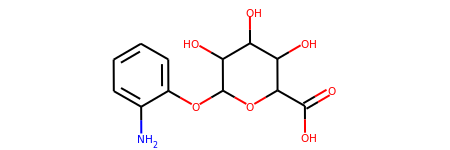

CC#CC#CC=C=CC(O)CCC(=O)O


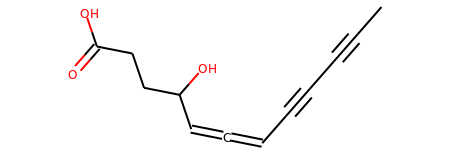

O=C(O)C1OC(Oc2ccc(I)cc2)C(O)C(O)C1O


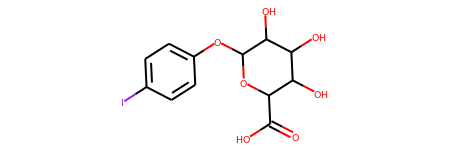

O=C(O)C1OC(Oc2ccc(I)cc2)C(O)C(O)C1O


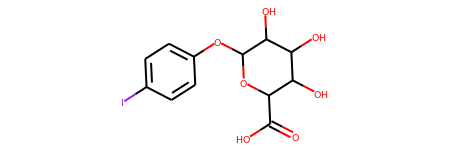

O=C(O)C1OC(Oc2ccc(I)cc2)C(O)C(O)C1O


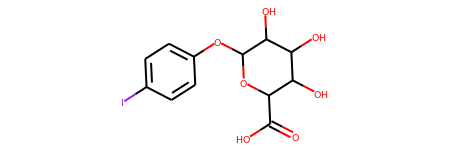

CC12CC(C(=O)O)OC(=O)C1CCC1(C)C2C2CCC1(O)C(=O)O2


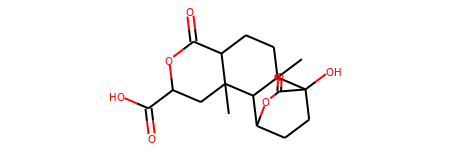

O=C(O)C(O)c1ccccc1[N+](=O)[O-]


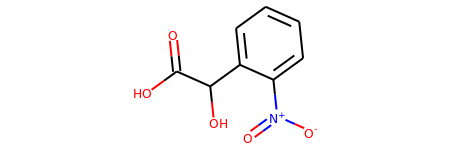

O=C(O)C(O)Cc1c[nH]cn1


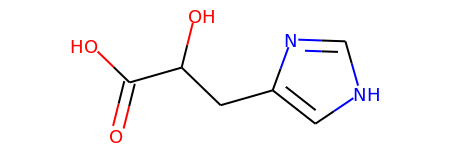

O=C1NC(C(=O)O)CC1O


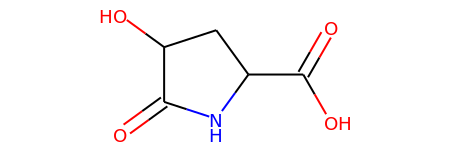

N#Cc1ccc(OC2OC(C(=O)O)C(O)C(O)C2O)cc1


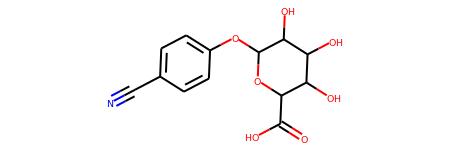

N#Cc1ccc(OC2OC(C(=O)O)C(O)C(O)C2O)cc1


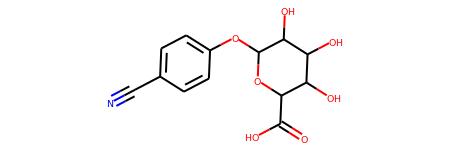

N#Cc1ccc(OC2OC(C(=O)O)C(O)C(O)C2O)cc1


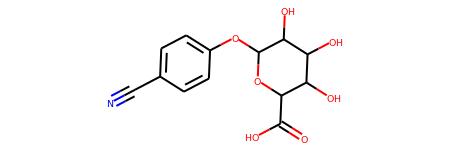

O=C(O)C(O)c1ccc([N+](=O)[O-])cc1


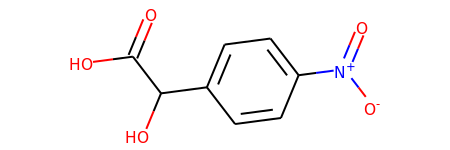

CC(O)C1CNC(C(=O)O)C1CC(=O)O


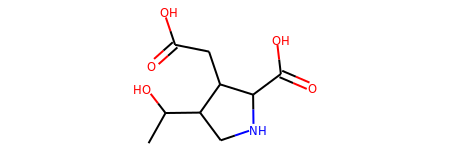

NCC(O)C1NC(N)=NC1C(=O)O


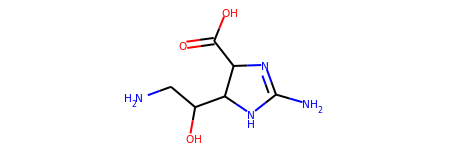

C#CC#CC=C=CC(O)CCC(=O)O


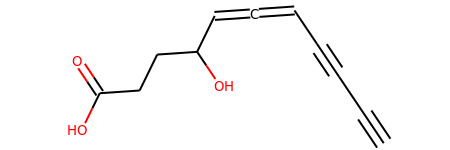

O=C(O)C(O)c1cccc([N+](=O)[O-])c1


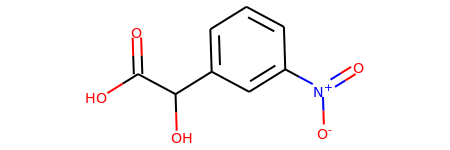

O=C(OC1OC(C(=O)O)C(O)C(O)C1O)c1ccccc1


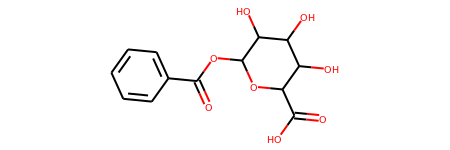

O=C(OC1OC(C(=O)O)C(O)C(O)C1O)c1ccccc1


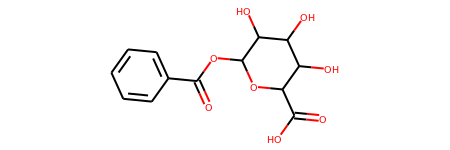

O=C(OC1OC(C(=O)O)C(O)C(O)C1O)c1ccccc1


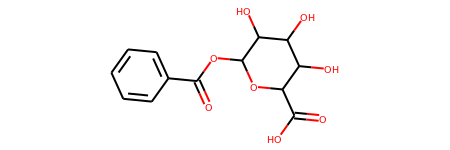

O=C(O)C1CCCCC1O


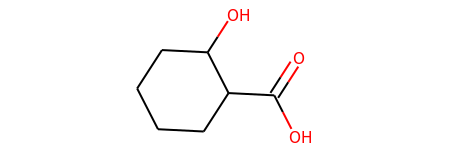

CC(C1CC1C(=O)O)C1CCC2C3C(O)CC4CC(O)CCC4(C)C3CCC12C


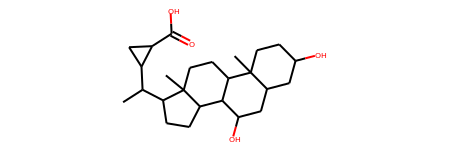

CC(C1CC1C(=O)O)C1CCC2C3C(O)CC4CC(O)CCC4(C)C3CCC12C


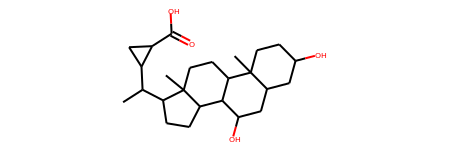

O=C(O)c1cc([N+](=O)[O-])ccc1CO


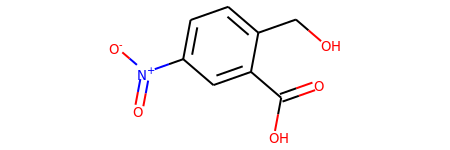

O=C(O)C1CCC(O)CC1


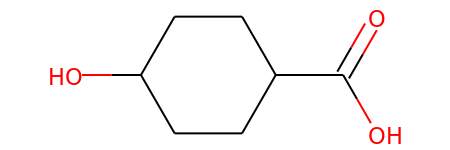

O=C(O)C1CCCC(O)C1


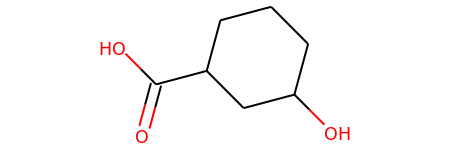

NCC(O)C(=O)O


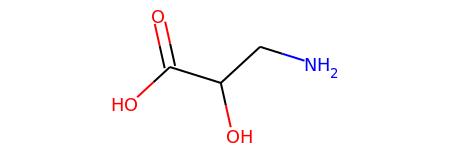

O=C(O)CCC1CCC(O)CC1


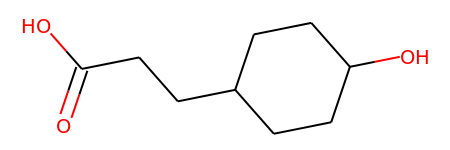

CC(CCC(=O)O)C1CCC2C3C(O)CC4CC(O)CCC4(C)C3CCC12C


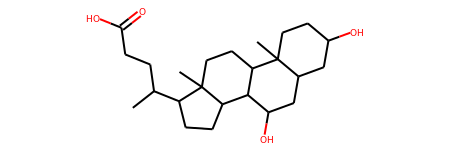

CC(CCC(=O)O)C1CCC2C3C(O)CC4CC(O)CCC4(C)C3CCC12C


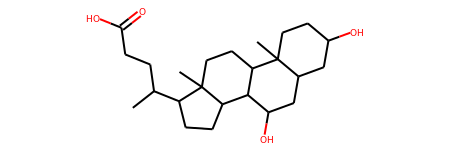

O=C(O)C1OC(Oc2ccc(-c3ccccc3)cc2)C(O)C(O)C1O


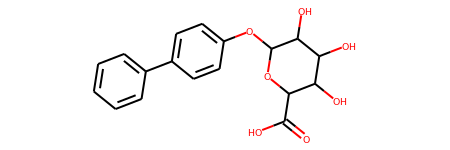

O=C(O)C1OC(Oc2ccc(-c3ccccc3)cc2)C(O)C(O)C1O


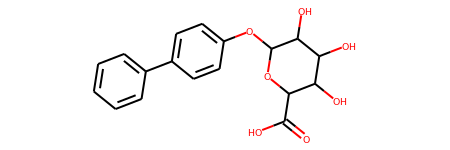

O=C(O)C1OC(Oc2ccc(-c3ccccc3)cc2)C(O)C(O)C1O


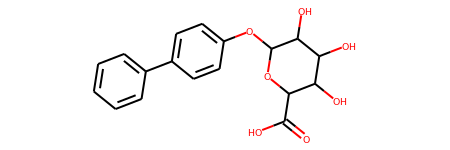

Nc1ccc(OC2OC(C(=O)O)C(O)C(O)C2O)cc1


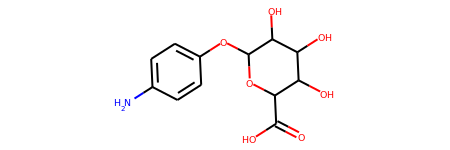

Nc1ccc(OC2OC(C(=O)O)C(O)C(O)C2O)cc1


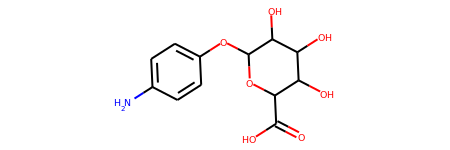

Nc1ccc(OC2OC(C(=O)O)C(O)C(O)C2O)cc1


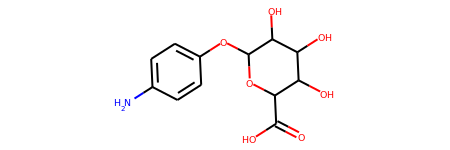

O=C(O)C1OC(Oc2cccc3ncccc23)C(O)C(O)C1O


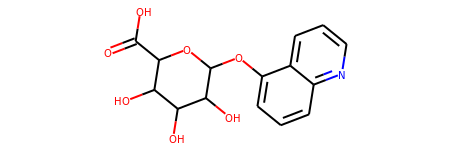

O=C(O)C1OC(Oc2cccc3ncccc23)C(O)C(O)C1O


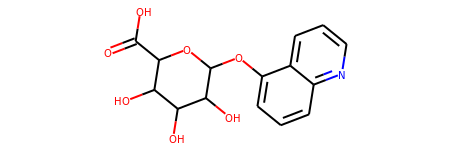

O=C(O)C1OC(Oc2cccc3ncccc23)C(O)C(O)C1O


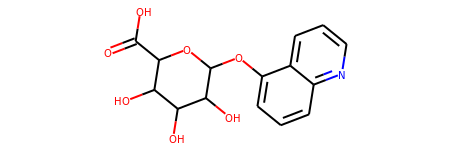

CC(O)C1CC(CC(=O)O)C1(C)C


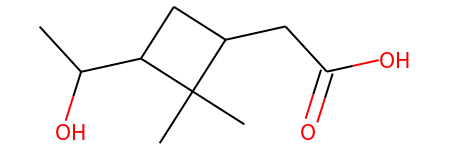

CC1(C)C2CCC(C(=O)O)(C2)C1O


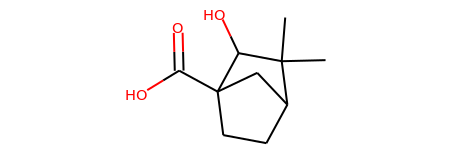

O=C(O)C1OC(Oc2cnc3ccccc3c2)C(O)C(O)C1O


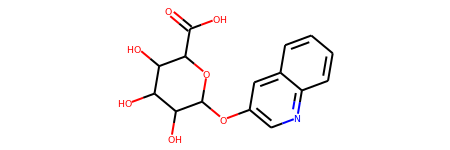

O=C(O)C1OC(Oc2cnc3ccccc3c2)C(O)C(O)C1O


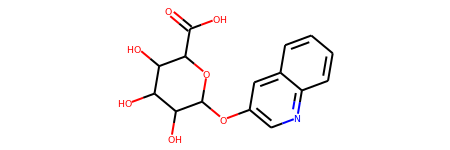

O=C(O)C1OC(Oc2cnc3ccccc3c2)C(O)C(O)C1O


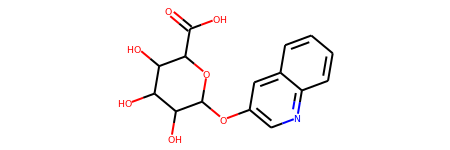

Nc1cccc(OC2OC(C(=O)O)C(O)C(O)C2O)c1


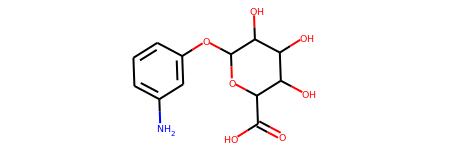

Nc1cccc(OC2OC(C(=O)O)C(O)C(O)C2O)c1


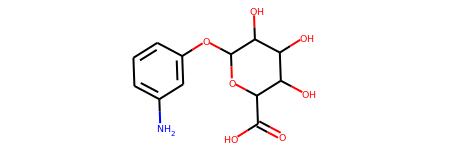

In [924]:

for smiles in Alcohol_smiles_lis[:1000]:
    mol = Chem.MolFromSmiles(smiles)
    if mol.HasSubstructMatch(patt):
        print(smiles)
        mol

In [ ]:
C=C(C)C(C)(C(N)=O)C(=O)O

In [ ]:
NC(=O)CC(=O)O

In [ ]:
NC(=O)CCC(=O)O

'NC(=O)C[C@H](NC(=O)[C@@H](N)CS)C(=O)O'

In [748]:
#Amide_smiles_lis

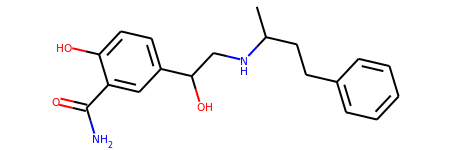

In [749]:
smiles = Amide_smiles_lis[1]
Chem.MolFromSmiles(smiles)

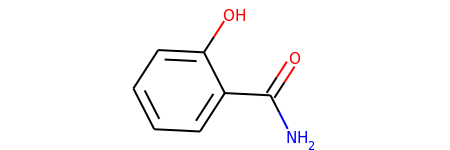

In [750]:
smiles = Amide_smiles_lis[2]
Chem.MolFromSmiles(smiles)

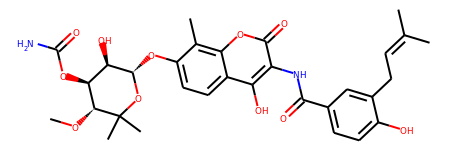

In [751]:
smiles = Amide_smiles_lis[3]
Chem.MolFromSmiles(smiles)

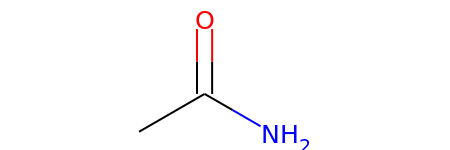

In [752]:
smiles = Amide_smiles_lis[12]
Chem.MolFromSmiles(smiles)

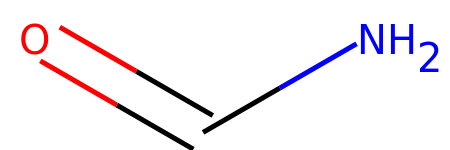

In [753]:
smiles = Amide_smiles_lis[13]
Chem.MolFromSmiles(smiles)

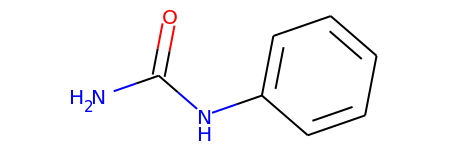

In [754]:
smiles = Amide_smiles_lis[14]
Chem.MolFromSmiles(smiles)

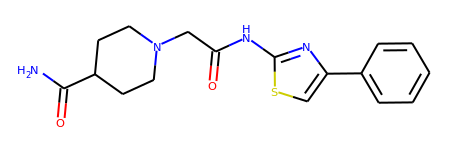

In [755]:
smiles = Amide_smiles_lis[16]
Chem.MolFromSmiles(smiles)

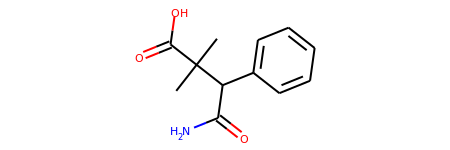

In [756]:
smiles = Amide_smiles_lis[31]
Chem.MolFromSmiles(smiles)


In [757]:
print(smiles)

CC(C)(C(=O)O)C(C(N)=O)c1ccccc1


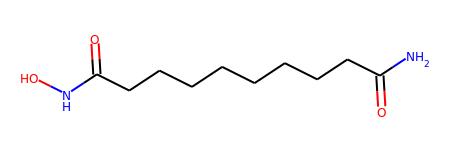

In [758]:
smiles = Amide_smiles_lis[35]
Chem.MolFromSmiles(smiles)

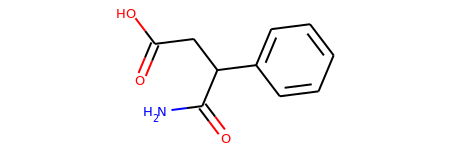

In [759]:
smiles = Amide_smiles_lis[40]
Chem.MolFromSmiles(smiles)


In [760]:
print(smiles)

NC(=O)C(CC(=O)O)c1ccccc1


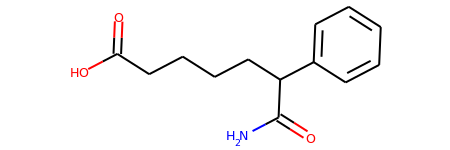

In [761]:
smiles = Amide_smiles_lis[41]
Chem.MolFromSmiles(smiles)


In [762]:
print(smiles)

NC(=O)C(CCCCC(=O)O)c1ccccc1


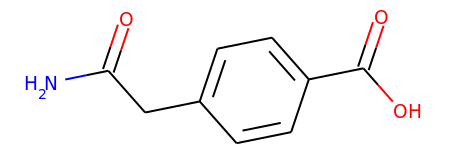

In [763]:
smiles = Amide_smiles_lis[46]
Chem.MolFromSmiles(smiles)

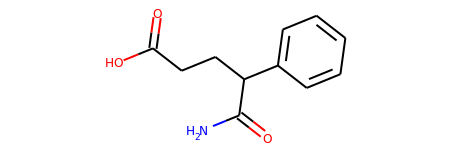

In [764]:
smiles = Amide_smiles_lis[49]
Chem.MolFromSmiles(smiles)

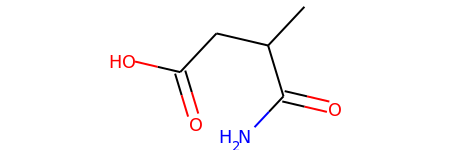

In [765]:
smiles = Amide_smiles_lis[50]
Chem.MolFromSmiles(smiles)

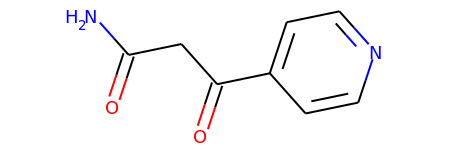

In [766]:
smiles = Amide_smiles_lis[79]
Chem.MolFromSmiles(smiles)

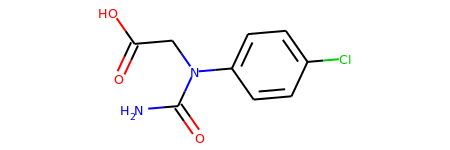

In [767]:
smiles = Amide_smiles_lis[108]
Chem.MolFromSmiles(smiles)

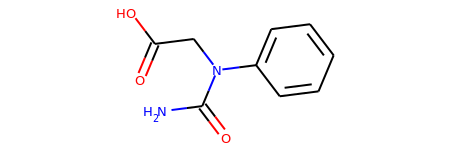

In [768]:
smiles = Amide_smiles_lis[109]
Chem.MolFromSmiles(smiles)

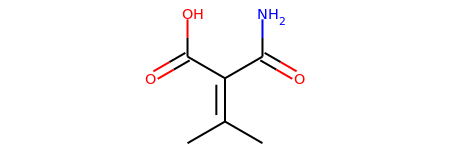

In [769]:
smiles = Amide_smiles_lis[27]
Chem.MolFromSmiles(smiles)

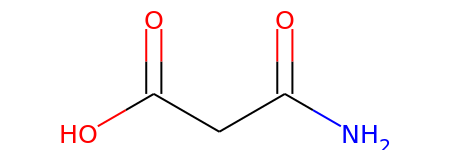

In [770]:
smiles = Amide_smiles_lis[44]
Chem.MolFromSmiles(smiles)

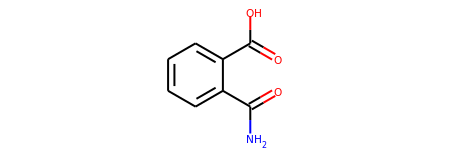

In [771]:
smiles = Amide_smiles_lis[45]
Chem.MolFromSmiles(smiles)

NC(=O)C(CCC(=O)O)c1ccccc1


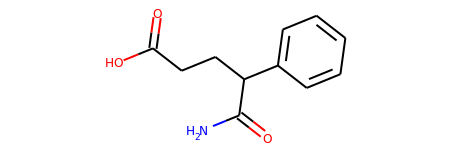

In [772]:
smiles = Amide_smiles_lis[49]
print(smiles)
Chem.MolFromSmiles(smiles)

In [773]:
a = pca.transform(Amide[31:32]) 
a

array([[ 1.65001418,  0.18041705, -0.33698586]])

In [774]:
b = pca.transform(Amide[41:42]) 
b

array([[ 2.45399409,  0.06900349, -0.45993672]])

In [775]:
c = pca.transform(Amide[49:50]) 
c

array([[ 2.23677343,  0.14003943, -0.45175599]])

In [776]:
d = np.concatenate([a,b])
d

array([[ 1.65001418,  0.18041705, -0.33698586],
       [ 2.45399409,  0.06900349, -0.45993672]])

In [910]:
acid_d = np.array(candicate_acid_lis)
acid_d.shape

(3, 200)

In [911]:
acid_d = pca.transform(acid_d) 

In [912]:
acid_d

array([[-1.29559738,  0.01326785,  0.14313818],
       [-1.29390439, -0.04400177,  0.11573957],
       [-1.39412008, -0.06395201,  0.06066762]])

In [913]:
Amide_d = np.array(candicate_Amide_lis)
Amide_d.shape

(3, 200)

In [914]:
Amide_d = pca.transform(Amide_d) 

In [915]:
Amide_d

array([[ 0.87639598,  0.2534653 , -0.04917963],
       [ 1.69329137,  0.22702159, -0.32284755],
       [ 2.27480749,  0.09080167, -0.41431476]])

Text(0.5, 0, '    PC 1    ')

Text(0.5, 0, '    PC 2    ')

Text(0.5, 0, '    PC 3    ')

(-3.0, 3.5)

(-0.3, 1.0)

(-0.6, 0.6)

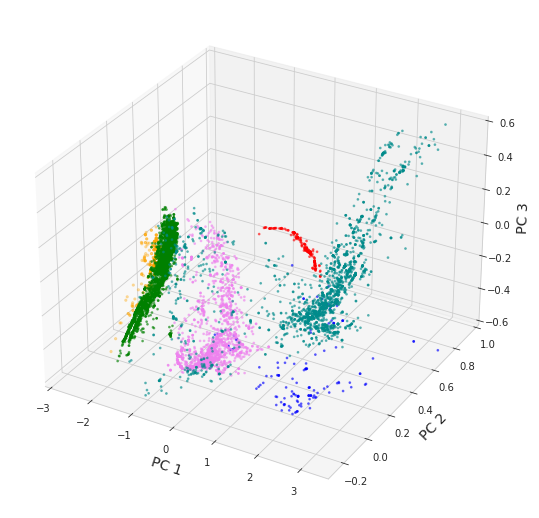

In [957]:
import re, seaborn as sns, numpy as np, pandas as pd, random
from pylab import *
from matplotlib.pyplot import plot, show, draw, figure, cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(7,7))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2


ax.scatter(newX[:2181,0],newX[:2181,1]*-1,newX[:2181,2], s= 3,alpha = 0.5,c= "darkcyan")
ax.scatter(newX[2181:3888,0],newX[2181:3888,1]*-1,newX[2181:3888,2],s=3,alpha = 0.5,c='violet')
ax.scatter(newX[3888:8137,0],newX[3888:8137,1]*-1,newX[3888:8137,2],s= 3,alpha = 0.5,c='green')
ax.scatter(newX[8137:8272,0],newX[8137:8272,1]*-1,newX[8137:8272,2],s= 3,alpha = 0.5,c='blue')
ax.scatter(newX[8272:8458,0],newX[8272:8458,1]*-1,newX[8272:8458,2],s= 3,alpha = 0.5,c='red')
ax.scatter(newX[8458:,0],newX[8458:,1]*-1,newX[8458:,2],s= 5,alpha = 0.3,c='orange')



# ax.scatter(Amide_d[:,0],Amide_d[:,1]*-1,Amide_d[:,2],s= 200,alpha = 0.5,c='black')
# ax.scatter(acid_d[:,0],acid_d[:,1]*-1,acid_d[:,2],s= 200,alpha = 0.5,c='black')

# ax.scatter(newX[:2181,0],newX[:2181,1],newX[:2181,2], s= 2.5,alpha = 0.75,c= 'orange',label='R-OH')
# ax.scatter(newX[2181:3888,0],newX[2181:3888,1],newX[2181:3888,2],s=2.5,alpha = 0.75,c='violet',label= 'Ar-OH')
# ax.scatter(newX[3888:8754,0],newX[3888:8754,1],newX[3888:8754,2],s= 2.5,alpha = 0.75,c='green',label= '- COOH')
# ax.scatter(newX[8754:10470,0],newX[8754:10470,1],newX[8754:10470,2],s= 2.5,alpha = 0.75,c='blue',label= '- CONH${_2}$')
# ax.scatter(newX[10470:10958,0],newX[10470:10958,1],newX[10470:10958,2],s= 2.5,alpha = 0.75,c='red',label= '- SO${_2}$NH${_2}$')

ax.set_xlabel('    PC 1    ',fontsize=14)
ax.set_ylabel('    PC 2    ',fontsize=14)
ax.set_zlabel('    PC 3    ',fontsize=14)
ax.set_xlim(-3,3.5)
ax.set_ylim(-0.3,1)
ax.set_zlim3d(-0.6,0.6)
#plt.zlim(-0.6,0.6)
#ax.legend(loc='best',fontsize=14)

plt.show()

Text(0.5, 0, '    PC 1    ')

Text(0.5, 0, '    PC 2    ')

Text(0.5, 0, '    PC 3    ')

(-3.0, 3.5)

(-0.3, 1.0)

(-0.6, 0.6)

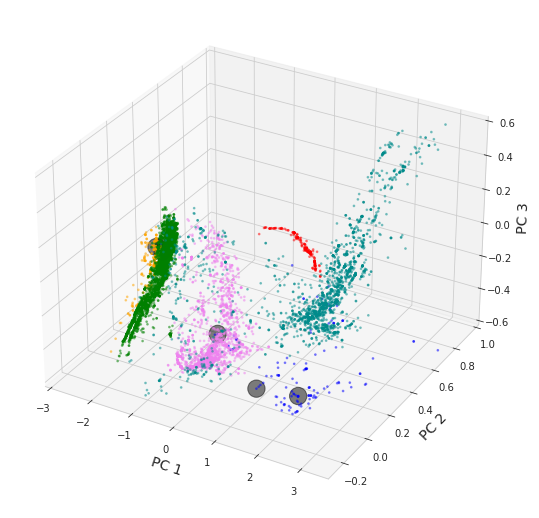

In [963]:
import re, seaborn as sns, numpy as np, pandas as pd, random
from pylab import *
from matplotlib.pyplot import plot, show, draw, figure, cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(7,7))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2


ax.scatter(newX[:2181,0],newX[:2181,1]*-1,newX[:2181,2], s= 3,alpha = 0.4,c= "darkcyan")
ax.scatter(newX[2181:3888,0],newX[2181:3888,1]*-1,newX[2181:3888,2],s=3,alpha = 0.4,c='violet')
ax.scatter(newX[3888:8137,0],newX[3888:8137,1]*-1,newX[3888:8137,2],s= 3,alpha = 0.4,c='green')
ax.scatter(newX[8137:8272,0],newX[8137:8272,1]*-1,newX[8137:8272,2],s= 3,alpha = 0.4,c='blue')
ax.scatter(newX[8272:8458,0],newX[8272:8458,1]*-1,newX[8272:8458,2],s= 3,alpha = 0.4,c='red')
ax.scatter(newX[8458:,0],newX[8458:,1]*-1,newX[8458:,2],s= 3,alpha = 0.4,c='orange')



ax.scatter(Amide_d[:,0],Amide_d[:,1]*-1,Amide_d[:,2],s= 300,alpha = 0.5,c='black')
ax.scatter(acid_d[:,0],acid_d[:,1]*-1,acid_d[:,2],s= 300,alpha = 0.5,c='black')

# ax.scatter(newX[:2181,0],newX[:2181,1],newX[:2181,2], s= 2.5,alpha = 0.75,c= 'orange',label='R-OH')
# ax.scatter(newX[2181:3888,0],newX[2181:3888,1],newX[2181:3888,2],s=2.5,alpha = 0.75,c='violet',label= 'Ar-OH')
# ax.scatter(newX[3888:8754,0],newX[3888:8754,1],newX[3888:8754,2],s= 2.5,alpha = 0.75,c='green',label= '- COOH')
# ax.scatter(newX[8754:10470,0],newX[8754:10470,1],newX[8754:10470,2],s= 2.5,alpha = 0.75,c='blue',label= '- CONH${_2}$')
# ax.scatter(newX[10470:10958,0],newX[10470:10958,1],newX[10470:10958,2],s= 2.5,alpha = 0.75,c='red',label= '- SO${_2}$NH${_2}$')

ax.set_xlabel('    PC 1    ',fontsize=14)
ax.set_ylabel('    PC 2    ',fontsize=14)
ax.set_zlabel('    PC 3    ',fontsize=14)
ax.set_xlim(-3,3.5)
ax.set_ylim(-0.3,1)
ax.set_zlim3d(-0.6,0.6)
#plt.zlim(-0.6,0.6)
#ax.legend(loc='best',fontsize=14)

plt.show()

Text(0.5, 0, '    PC 1    ')

Text(0.5, 0, '    PC 2    ')

Text(0.5, 0, '    PC 3    ')

(-3.0, 3.5)

(-0.3, 1.0)

(-0.6, 0.6)

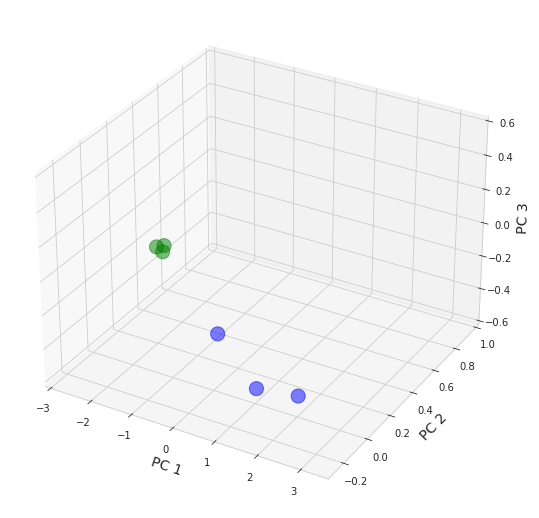

In [960]:
import re, seaborn as sns, numpy as np, pandas as pd, random
from pylab import *
from matplotlib.pyplot import plot, show, draw, figure, cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(7,7))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2


# ax.scatter(newX[:2181,0],newX[:2181,1]*-1,newX[:2181,2], s= 3,alpha = 0.5,c= "pink")
# ax.scatter(newX[2181:3888,0],newX[2181:3888,1]*-1,newX[2181:3888,2],s=3,alpha = 0.5,c='violet')
# ax.scatter(newX[3888:8137,0],newX[3888:8137,1]*-1,newX[3888:8137,2],s= 3,alpha = 0.5,c='#8ec965')
# ax.scatter(newX[8137:8272,0],newX[8137:8272,1]*-1,newX[8137:8272,2],s= 3,alpha = 0.5,c='blue')
# ax.scatter(newX[8272:8458,0],newX[8272:8458,1]*-1,newX[8272:8458,2],s= 3,alpha = 0.5,c='red')
# ax.scatter(newX[8458:,0],newX[8458:,1]*-1,newX[8458:,2],s= 5,alpha = 0.3,c='orange')



ax.scatter(Amide_d[:,0],Amide_d[:,1]*-1,Amide_d[:,2],s= 200,alpha = 0.5,c='blue')
ax.scatter(acid_d[:,0],acid_d[:,1]*-1,acid_d[:,2],s= 200,alpha = 0.5,c='green')

# ax.scatter(newX[:2181,0],newX[:2181,1],newX[:2181,2], s= 2.5,alpha = 0.75,c= 'orange',label='R-OH')
# ax.scatter(newX[2181:3888,0],newX[2181:3888,1],newX[2181:3888,2],s=2.5,alpha = 0.75,c='violet',label= 'Ar-OH')
# ax.scatter(newX[3888:8754,0],newX[3888:8754,1],newX[3888:8754,2],s= 2.5,alpha = 0.75,c='green',label= '- COOH')
# ax.scatter(newX[8754:10470,0],newX[8754:10470,1],newX[8754:10470,2],s= 2.5,alpha = 0.75,c='blue',label= '- CONH${_2}$')
# ax.scatter(newX[10470:10958,0],newX[10470:10958,1],newX[10470:10958,2],s= 2.5,alpha = 0.75,c='red',label= '- SO${_2}$NH${_2}$')

ax.set_xlabel('    PC 1    ',fontsize=14)
ax.set_ylabel('    PC 2    ',fontsize=14)
ax.set_zlabel('    PC 3    ',fontsize=14)
ax.set_xlim(-3,3.5)
ax.set_ylim(-0.3,1)
ax.set_zlim3d(-0.6,0.6)
#plt.zlim(-0.6,0.6)
#ax.legend(loc='best',fontsize=14)

plt.show()

In [ ]:
'CC(C)(C(=O)O)C(C(N)=O)c1ccccc1','NC(=O)C(CCCCC(=O)O)c1ccccc1','C=C(C)C(C)(C(N)=O)C(=O)O','NC(=O)CC(=O)O'

In [ ]:
smiles = Amide_smiles_lis[14]
Chem.MolFromSmiles(smiles)

In [135]:
x = X[1:3]
x = np.array(x)

In [136]:
x.shape

(2, 200)

In [137]:
# x = atom_feature[1:2]
# #x = torch.unsqueeze(x,dim = 0)

In [139]:
test = pca.transform(x)
test

array([[ 0.48005183, -0.39084002, -0.31786837],
       [ 0.12501134, -0.37615075, -0.13277229]])

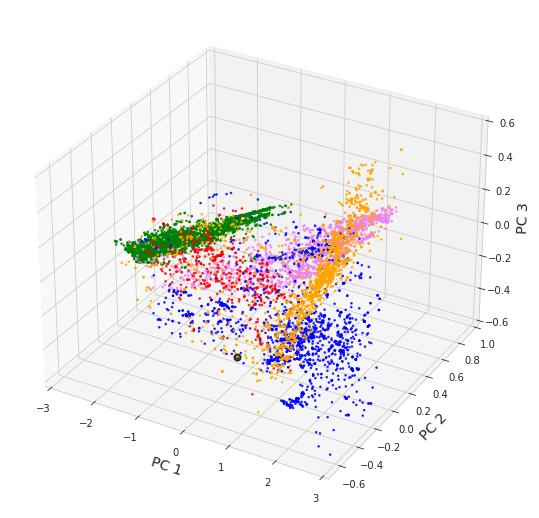

In [146]:
import re, seaborn as sns, numpy as np, pandas as pd, random
from pylab import *
from matplotlib.pyplot import plot, show, draw, figure, cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(7,7))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2


ax.scatter(newX[:2181,0],newX[:2181,1],newX[:2181,2], s= 2.5,alpha = 0.75,c= 'orange')
ax.scatter(newX[2181:3888,0],newX[2181:3888,1],newX[2181:3888,2],s=2.5,alpha = 0.75,c='violet')
ax.scatter(newX[3888:8137,0],newX[3888:8137,1],newX[3888:8137,2],s= 2.5,alpha = 0.75,c='green')
ax.scatter(newX[8137:9853,0],newX[8137:9853,1],newX[8137:9853,2],s= 2.5,alpha = 0.75,c='blue')
ax.scatter(newX[9853:10341,0],newX[9853:10341,1],newX[9853:10341,2],s= 2.5,alpha = 0.75,c='red')
ax.scatter(newX[1:2,0],newX[1:2,1],newX[1:2,2],s= 50,alpha = 0.75,c = 'black')

# ax.scatter(newX[:2181,0],newX[:2181,1],newX[:2181,2], s= 2.5,alpha = 0.75,c= 'orange',label='R-OH')
# ax.scatter(newX[2181:3888,0],newX[2181:3888,1],newX[2181:3888,2],s=2.5,alpha = 0.75,c='violet',label= 'Ar-OH')
# ax.scatter(newX[3888:8754,0],newX[3888:8754,1],newX[3888:8754,2],s= 2.5,alpha = 0.75,c='green',label= '- COOH')
# ax.scatter(newX[8754:10470,0],newX[8754:10470,1],newX[8754:10470,2],s= 2.5,alpha = 0.75,c='blue',label= '- CONH${_2}$')
# ax.scatter(newX[10470:10958,0],newX[10470:10958,1],newX[10470:10958,2],s= 2.5,alpha = 0.75,c='red',label= '- SO${_2}$NH${_2}$')

ax.set_xlabel('    PC 1    ',fontsize=14)
ax.set_ylabel('    PC 2    ',fontsize=14)
ax.set_zlabel('    PC 3    ',fontsize=14)
ax.set_xlim(-3,3)
ax.set_ylim(-0.7,1)
ax.set_zlim3d(-0.6,0.6)
#plt.zlim(-0.6,0.6)
#ax.legend(loc='best',fontsize=14)

plt.show()

In [132]:
newX[1]

array([ 0.48005183, -0.39084002, -0.31786837])

In [39]:
atom_feature_class_lis[1][1]

'Carboxylic Acid'

In [40]:
atom_feature_class_lis[1][0]

tensor([0.2495, 0.2416, 0.5407, 0.1255, 0.0000, 0.1791, 0.1829, 0.3411, 0.0000,
        0.6023, 0.1716, 0.1342, 0.2608, 0.1118, 0.0484, 0.2246, 0.1401, 0.1058,
        0.0000, 0.0000, 0.1830, 0.1824, 0.0000, 0.1979, 0.0000, 0.2886, 0.1555,
        0.0000, 0.1946, 0.5642, 0.1925, 0.1834, 0.0000, 0.0000, 0.1882, 0.0000,
        0.0000, 0.5028, 0.1643, 0.1964, 0.2141, 0.1504, 0.1354, 0.1578, 0.1892,
        0.4370, 0.4093, 0.0000, 0.0000, 0.1974, 0.1482, 0.0000, 0.0000, 0.1513,
        0.0000, 0.0000, 0.1361, 0.1760, 0.2742, 0.0000, 0.1906, 0.4751, 0.1902,
        0.1356, 0.0975, 0.0000, 0.1963, 0.0000, 0.1515, 0.1307, 0.0000, 0.1969,
        0.1541, 0.2059, 0.5422, 0.0000, 0.1201, 0.0000, 0.0000, 0.0000, 0.6014,
        0.0000, 0.0000, 0.0000, 0.0847, 0.1331, 0.0094, 0.0000, 0.0000, 0.0000,
        0.1482, 0.1161, 0.1791, 0.1139, 0.4867, 0.1088, 0.0148, 0.0000, 0.1289,
        0.0000, 0.5651, 0.1953, 0.0000, 0.1083, 0.2123, 0.0640, 0.1611, 0.1315,
        0.0000, 0.5381, 0.1820, 0.2393, 

In [ ]:

ax.scatter(x1, y1, z1, c='r', label='A')
ax.scatter(x2, y2, z2, c='g', label='B')
ax.scatter(x3, y3, z3, c='y', label='C')

In [19]:
features,ss_class = [],[]
for i,j in atom_feature_class_lis:
    if j in ['Alcohol','Phenol','Carboxylic Acid','Amide','Sulfa']:
        features.append(i.tolist())
        ss_class.append(j)
features = np.array(features)

In [20]:
features.shape

(10958, 200)

In [21]:
X = features

In [22]:
import numpy as np
from sklearn.decomposition import PCA
#X = np.array(fps)  #导入数据，维度为4
pca = PCA(n_components=3)   #降到2维
pca.fit(X)                  #训练
newX=pca.fit_transform(X)   #降维后的数据
# PCA(copy=True, n_components=2, whiten=False)
print(pca.explained_variance_ratio_)  #输出贡献率
print(newX)    

[0.90134491 0.03307722 0.01430984]
[[-0.05144258  0.09021653 -0.09700037]
 [-0.0078706   0.09503789 -0.07004021]
 [-0.65933787 -0.05260945 -0.11358983]
 ...
 [-1.99467115 -0.17330281  0.11824395]
 [-1.9946711  -0.17330282  0.11824395]
 [-1.93737973 -0.2135392   0.02728265]]


In [23]:
#c = ['red'] * len(features)

In [24]:
#set(ss_class)
c = []
for i in ss_class:
    if i == 'Alcohol':
        c.append('red')
    elif i == 'Amide':
        c.append('blue')
    elif i == 'Carboxylic Acid':
        c.append('green')
    elif i == 'Phenol':
        c.append('orange')
    elif i == 'Sulfa':
        c.append('violet')

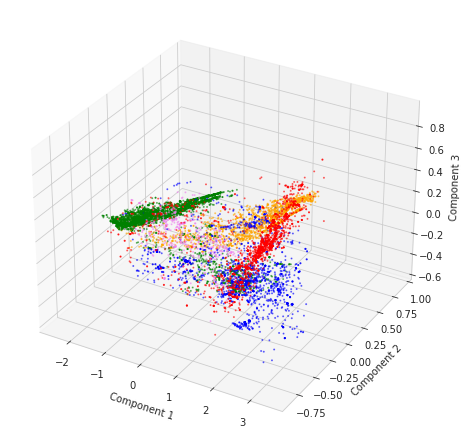

In [25]:
import re, seaborn as sns, numpy as np, pandas as pd, random
from pylab import *
from matplotlib.pyplot import plot, show, draw, figure, cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2



ax.scatter(newX[:,0],newX[:,1],newX[:,2],c = c[:],s= 1,alpha = 1/2)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

plt.show()

In [19]:
!nvidia-smi

Failed to initialize NVML: Driver/library version mismatch


In [1]:
patt_1 = Chem.MolFromSmarts('c[OH]')

NameError: name 'Chem' is not defined

In [ ]:
胺好像分析不了

In [22]:
def draw_pca_result(file_name,Chain_id,neigh_num,dim):
    
    if dim == 3:
        feature = Get_3D_feature(file_name,neigh_num,Chain_id)()
    elif dim == 1:
        feature = Get_1D_feature(file_name,neigh_num,Chain_id)()
        
    features = []
    features.append(feature)
    features = np.array(features)


    X = features.squeeze(0).reshape(-1,dim * neigh_num)
    pca = PCA(n_components=2)
    newX = pca.fit_transform(X)
    #sns.scatterplot(newX[neigh_num:neigh_num*-1,0],newX[neigh_num:neigh_num*-1,1], hue= ss_class[neigh_num:neigh_num*-1])

(tensor([0.0921, 0.2477, 0.4085, 0.1312, 0.0000, 0.1738, 0.1512, 0.2639, 0.0000,
         0.4587, 0.1060, 0.1090, 0.1411, 0.1313, 0.0547, 0.2174, 0.0747, 0.0757,
         0.0000, 0.0000, 0.1502, 0.1586, 0.0000, 0.1644, 0.0000, 0.1657, 0.1302,
         0.0000, 0.1637, 0.3875, 0.1559, 0.1725, 0.0000, 0.0000, 0.1211, 0.0000,
         0.0000, 0.3862, 0.1436, 0.1571, 0.1232, 0.1105, 0.0698, 0.1529, 0.1394,
         0.3181, 0.3132, 0.0000, 0.0000, 0.2092, 0.0969, 0.0000, 0.0000, 0.1451,
         0.0000, 0.0000, 0.1009, 0.1466, 0.2433, 0.0000, 0.1606, 0.3645, 0.1497,
         0.1467, 0.0746, 0.0000, 0.1575, 0.0000, 0.1169, 0.0738, 0.0000, 0.1545,
         0.1937, 0.2122, 0.3956, 0.0000, 0.0723, 0.0000, 0.0000, 0.0000, 0.5254,
         0.0000, 0.0000, 0.0000, 0.0513, 0.0884, 0.0000, 0.0000, 0.0000, 0.0376,
         0.2326, 0.0752, 0.1548, 0.0271, 0.3580, 0.0897, 0.0000, 0.0000, 0.0876,
         0.0000, 0.4739, 0.1384, 0.0000, 0.0499, 0.1049, 0.0182, 0.1521, 0.1388,
         0.0000, 0.3072, 0.1

In [ ]:
#data= pickle.load(open('file_path','rb'))

In [117]:
get_acidic_atom_class('COc1nc(C)cc(O)n1')

{8: 'Phenol'}

In [120]:
bg = smiles_to_bigraph(smiles= 'COc1nc(C)cc(O)n1', 
          node_featurizer=node_featurizer,
          edge_featurizer=edge_featurizer,
          canonical_atom_order= False)

with torch.no_grad():
    model.eval()
    g_feats,atom_pka,node_feats = model(bg,bg.ndata['h'], bg.edata['h'])

In [122]:
node_feats.size()

torch.Size([10, 200])

In [1]:
from rdkit import Chem

In [2]:
m = Chem.MolFromSmiles('c1ccccc1OC')
patt = Chem.MolFromSmarts('OC')
flag =m.HasSubstructMatch(patt)

molecu m contains group -OCH3


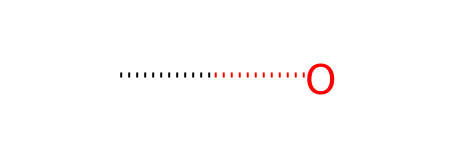

In [3]:
patt

In [21]:
# 酚羟基

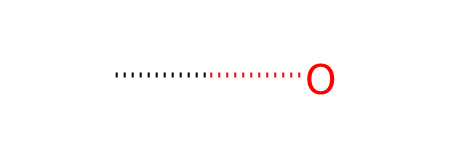

In [55]:
m = Chem.MolFromSmiles('OC1=CC=CC=C1')
patt = Chem.MolFromSmarts('c[OH]')
patt

In [58]:
flag = m.HasSubstructMatch(patt)

print(flag)

if flag:
    atomids = m.GetSubstructMatches(patt)
    for i in atomids:
        print(i)
    print(atomids)

True
(1, 0)
((1, 0),)


In [45]:
# 醇羟基

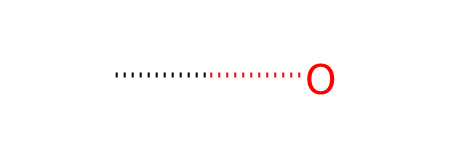

In [48]:
m = Chem.MolFromSmiles('OCC1=C(CO)C=CC=C1')
patt = Chem.MolFromSmarts('C[OH]')
patt

In [49]:
flag = m.HasSubstructMatch(patt)

print(flag)

if flag:
    atomids = m.GetSubstructMatch(patt)
    print(atomids)

True
(1, 0)


In [ ]:
#酰胺基-一个H

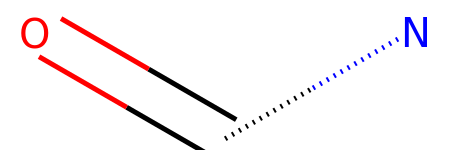

In [36]:
m = Chem.MolFromSmiles('NC(C1=CC=CC(C(NC)=O)=C1)=O')
patt = Chem.MolFromSmarts('C([NH])=O')
patt

In [37]:
flag = m.HasSubstructMatch(patt)

print(flag)

if flag:
    atomids = m.GetSubstructMatch(patt)
    print(atomids)

True
(7, 8, 10)


In [ ]:
#酰胺基-2个H

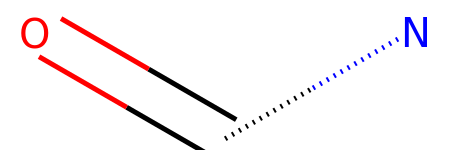

In [38]:
m = Chem.MolFromSmiles('NC(C1=CC=CC(C(NC)=O)=C1)=O')
patt = Chem.MolFromSmarts('C([NH2])=O')
patt

In [39]:
flag = m.HasSubstructMatch(patt)

print(flag)

if flag:
    atomids = m.GetSubstructMatch(patt)
    print(atomids)

True
(1, 0, 12)


In [40]:
#磺胺基-1个H

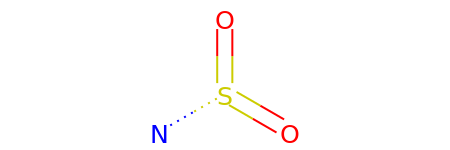

In [41]:
m = Chem.MolFromSmiles('O=S(CC1=CC2=C(S(=O)(NC)=O)C=CC=C2C=C1)(N)=O')
patt = Chem.MolFromSmarts('O=S([NH])=O')
patt

In [42]:
flag = m.HasSubstructMatch(patt)

print(flag)

if flag:
    atomids = m.GetSubstructMatch(patt)
    print(atomids)

True
(8, 7, 9, 11)


In [ ]:
#磺胺基-2个H

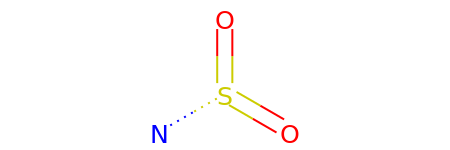

In [43]:
m = Chem.MolFromSmiles('O=S(CC1=CC2=C(S(=O)(NC)=O)C=CC=C2C=C1)(N)=O')
patt = Chem.MolFromSmarts('O=S([NH2])=O')
patt

In [44]:
flag = m.HasSubstructMatch(patt)

print(flag)

if flag:
    atomids = m.GetSubstructMatch(patt)
    print(atomids)

True
(0, 1, 18, 19)


In [ ]:
#羧基

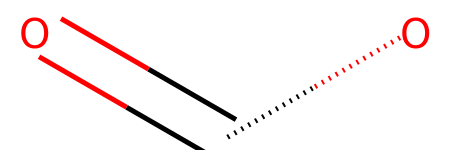

In [76]:
m = Chem.MolFromSmiles('OC1=CC(CC(O)=O)=C(O)C(CO)=C1')
patt = Chem.MolFromSmarts('OC=O')
patt

In [77]:
flag = m.HasSubstructMatch(patt)

print(flag)

if flag:
    atomids = m.GetSubstructMatch(patt)
    print(atomids)

True
(6, 5, 7)


In [91]:
get_acidic_atom_class('OC1=CC(CC(O)=O)=C(O)C(CO)=C1CCC(CNC(CC(N)=O)=O)CC(CCCS(=O)(NC)=O)S(=O)(N)=O')

{0: 'Phenol',
 9: 'Phenol',
 6: 'Carboxylic Acid',
 12: 'Alcohol',
 18: 'Amide',
 22: 'Amide',
 32: 'Sulfa',
 37: 'Sulfa'}

In [92]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs

In [93]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

In [94]:
mol = Chem.MolFromSmiles("OC1=CC(CC(O)=O)=C(O)C(CO)=C1CCC(CNC(CC(N)=O)=O)CC(CCCS(=O)(NC)=O)S(=O)(N)=O")

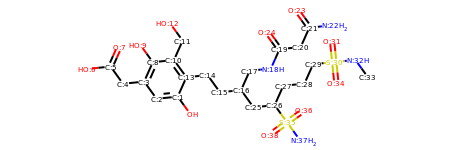

In [95]:
mol_with_atom_index(mol)

In [ ]:
磺胺基一个H

In [ ]:
O=S([NH])=O

In [ ]:
磺胺基2个H

In [ ]:
#酰胺基-2个H

In [35]:
flag = m.HasSubstructMatch(patt)

print(flag)

if flag:
    atomids = m.GetSubstructMatch(patt)
    print(atomids)

False


In [24]:
# 羧基

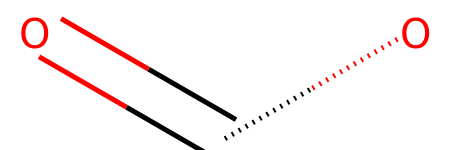

In [25]:
m = Chem.MolFromSmiles('OC1=CC(C(O)=O)=CC=C1')
patt = Chem.MolFromSmarts('C([OH])=O')
patt

In [20]:
flag = m.HasSubstructMatch(patt)

print(flag)

if flag:
    atomids = m.GetSubstructMatch(patt)
    print(atomids)

True
(4, 5, 6)


In [ ]:
m = Chem.MolFromSmiles('OC1=CC(C(O)=O)=CC=C1')
patt = Chem.MolFromSmarts('C([OH])=O')
patt